In [7]:
import copy
import glob
import os
import sys
from typing import Any, Callable, NamedTuple, Sequence

import dill as pickle

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
import flax
import flax.linen as nn
import jax
import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import numba as nb
import numpy as np
import optax
import prettypyplot as pplt
import scipy
import seaborn as sns
from flax import core, struct, traverse_util
from flax.core import freeze, unfreeze
from flax.training.train_state import TrainState
from jax import numpy as jnp
from jax import random
from matplotlib import ticker

import extq
import ivac
import vpm

In [4]:
sys.path.insert(1, "../../../python")
sys.path.insert(1, "../../../..")
import plotting
import util

In [5]:
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)
pplt.load_cmaps()

In [9]:
DATA_DIR = "/project/dinner/scguo/ci-vsd/data"
# S4 translocation/rotation data
cv_trajs = list(np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True))
cv_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton2.npy")[:115])
# salt bridge distances for states
sb_trajs = list(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton2.npy")[:115])
# committors
lag = 500
# weights
weights = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True)

sb_arr = np.concatenate(sb_trajs)
cv_arr = np.concatenate(cv_trajs)

In [10]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [11]:
print(jax.devices())

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]


In [12]:
rng = random.PRNGKey(0)
rng, key = random.split(rng)

# States

In [137]:
# states to do stopping
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
sb1 = sb_arr[:, 42]  # R226-D129
sb2 = sb_arr[:, 47]  # R226-D186
sb3 = sb_arr[:, 48]  # R229-D129
sb4 = sb_arr[:, 53]  # R229-D186
sb5 = sb_arr[:, 59]  # R232-D186


# # ellipse centered at down centroid with radii 1.1 nm and 8 deg (1 sigma in each direction)
# # take points where R2-D186 < 0.5 (lower salt bridges), R2-D129 > 0.6 (upper salt bridge)
# dist_ax_down = (dist + 4.240) / 1.1
# rot_ax_down = (rot + 56.95) / 8
# down_ids = ((dist_ax_down**2 + rot_ax_down**2) < 1) & (sb1 > 0.6) & (sb2 < 0.5)

# # ellipse centered at up centroid with radii 0.84 nm and 7.6 deg (2 sigma in each direction)
# # take points where R2-D129 (up) < 0.5, R3-D129 < 1.1, R3/R4-D186 salt bridges < 0.75/0.6 nm
# up_ids = (
#     ((((dist + 0.506) / 0.84) ** 2 + ((rot - 3.94) / 7.6) ** 2) < 1)
#     & (sb1 < 0.5)
#     & (sb3 < 1.1)
#     & (sb4 < 0.75)
#     & (sb5 < 0.6)
# )

zero = np.zeros_like(dist)
dist_ax_down = np.maximum(dist + 4.240, zero) / 1.1
rot_ax_down = np.maximum(rot + 56.95, zero) / 8
down_ids = ((dist_ax_down**2 + rot_ax_down**2) < 1) & (sb1 > 0.6) & (sb2 < 0.5)
# include points cut out by salt bridges outside of 
down_ids_alt = (dist < -5.34) & (rot < -64.95) & ~down_ids
down_ids = down_ids | down_ids_alt

# take points where R2-D129 (up) < 0.5, R3-D129 < 1.1, R3/R4-D186 salt bridges < 0.75/0.6 nm
dist_ax_up = np.minimum(dist + 0.506, zero) / 0.84
rot_ax_up = np.minimum(rot - 3.94, zero) / 7.6
up_ids = ((dist_ax_up**2 + rot_ax_up**2) < 1) & (sb1 < 0.5) & (sb3 < 1.1) & (sb4 < 0.75) & (sb5 < 0.6)
up_ids_alt = (dist > 0.334) & (rot > 11.5) & ~up_ids
up_ids = up_ids | up_ids_alt

In [138]:
traj_inds = util.split_indices(cv_trajs)
in_A = np.split(down_ids[..., None], traj_inds)
in_B = np.split(up_ids[..., None], traj_inds)
guess = np.split(np.zeros_like(up_ids), traj_inds)
in_domain = np.split(~up_ids, traj_inds)

# Training functions

In [16]:
class Batch(NamedTuple):
    batch_idx: jnp.ndarray
    xt: jnp.ndarray
    xtp: jnp.ndarray
    bt: jnp.ndarray
    btp: jnp.ndarray
    integral: jnp.ndarray

In [41]:
class TimeLaggedDataset:
    def __init__(self, lag, trajs, b_trajs, in_domain, batch_size: int = 1024):
        # self.dataset = self._generate_dataset(lag, trajs, in_domain)
        # self.b_data = self._generate_dataset(lag, b_trajs, in_domain)
        # self.integral = self._integrate(lag, in_domain)
        self._generate_dataset(lag, trajs, b_trajs, in_domain)
        self.batch_size = batch_size
        self.size = self.dataset.shape[1]

    def _generate_dataset(self, lag, trajs, b_trajs, in_domain):
        xt, xt_stop, bt, bt_stop, integral = [], [], [], [], []
        # stopped trajectories
        for d, traj, b in zip(in_domain, trajs, b_trajs):
            stop_times = np.minimum(np.arange(lag, len(traj)), extq.stop.forward_stop(d)[:-lag])
            xt.append(traj[:-lag])
            xt_stop.append(traj[stop_times])
            bt.append(b[:-lag])
            bt_stop.append(b[stop_times])
            time_to_dc = stop_times - np.arange(len(traj) - lag)
            integral.append(time_to_dc)
        # return jnp.stack((jnp.concatenate(xt), jnp.concatenate(xt_stop)), axis=0)
        self.dataset = jnp.stack((jnp.concatenate(xt), jnp.concatenate(xt_stop)), axis=0)
        self.b_data = jnp.stack((jnp.concatenate(bt), jnp.concatenate(bt_stop)), axis=0)
        self.integral = jnp.concatenate(integral)[:, None]

    def __next__(self):
        batch_idx = np.random.choice(self.size, size=(self.batch_size,), replace=True)
        x = self.dataset[:, batch_idx, :]
        b = self.b_data[:, batch_idx]
        integral = self.integral[batch_idx]
        return Batch(batch_idx, x[0], x[1], b[0], b[1], integral)

    def __len__(self):
        return self.size

In [119]:
class MFPTNetSI(nn.Module):
    output_dim: int
    layer_widths: Sequence[int]
    act: Callable

    @nn.compact
    def __call__(self, x, b):
        g = nn.Dense(features=self.layer_widths[0])(x)
        g = self.act(g)
        for w in self.layer_widths[1:]:
            g = nn.Dense(features=w)(g)
            g = self.act(g)
        g = nn.Dense(features=self.output_dim)(g)
        # boundary conditions (0 in B)
        return g * (1 - b)

In [210]:
def initialize(rng, model, opt, lr, input_dim, output_dim, **kwargs) -> TrainState:
    """Initialize a given model for subspace iteration and returns a TrainState

    Arguments
    ---------
        rng : random number seed
        model : a nn.Module
        lr : learning rate
        input_dim : dimension of input
        output_dim : dimension of output basis. Note that the first function is constant
            and is not learned by the network

    Returns
    -------
        state : initialized state
    """
    rng, key1, key2 = random.split(rng, num=3)
    params = model.init(key1, jnp.ones(shape=(1, input_dim)), jnp.ones(shape=(1, 1)))

    # initialize matrix A and v for normalization
    flat_params = traverse_util.flatten_dict(params, sep="/")
    unfrozen_params = unfreeze(params)
    unfrozen_params["A"] = jnp.eye(output_dim)
    unfrozen_params["v"] = jnp.zeros(shape=(output_dim - 1,))
    params = freeze(unfrozen_params)

    tx = opt(learning_rate=lr)
    state = TrainState.create(apply_fn=model.apply, params=params, tx=tx)
    return state


@jax.jit
def train_step(
    state: TrainState,
    batch: jnp.ndarray,
    batch_prev: jnp.ndarray,
    alpha: float,
    gamma: float = 1,
    lamb: float = 1,
):
    """Performs a single optimization step for subspace iteration.

    Arguments
    ---------
        state : train state
        batch : (xt, xtp) pairs of data points sampled from p and the transition kernel
        batch_prev : basis at the previous power iteration step evaluated at (xt, xtp).
            shape (2, n_batch, n_basis)
        alpha : damping factor
        gamma : penalty on non-diagonal terms of K matrix
        lamb : penalty on normalization

    Returns
    -------
        new_state : updated training state
    """
    xt, xtp, bt, btp, integral = batch.xt, batch.xtp, batch.bt, batch.btp, batch.integral
    phi_xt_prev = batch_prev[0, ...]  # shape: n_batch x n_basis
    # first basis is Richardson iterate; incorporate cost data (integral term in FK)
    rich_iterate = batch_prev[1, :, 0:1] + integral
    phi_xtp_prev = jnp.concatenate((rich_iterate, batch_prev[1, :, 1:]), axis=-1)

    @jax.jit
    def loss_fn(params):
        Phi = state.apply_fn({"params": params["params"]}, xt, bt)  # shape: n_batch x n_basis
        A, v = params["A"], params["v"]
        phi_A = Phi @ A
        term1 = 0.5 * jnp.mean(phi_A**2)
        term2 = jnp.mean(phi_A * phi_xt_prev)
        term3 = jnp.mean(phi_A * phi_xtp_prev)
        # sum of off diagonal elements squared
        term4 = jnp.sum((A - jnp.diag(jnp.diag(A))) ** 2)
        # normalization term (not Richardson iterate)
        norm = jnp.sum(2 * v * (jnp.mean(Phi[..., 1:] ** 2, axis=0) - 1) - v**2)
        return term1 - (1 - alpha) * term2 - alpha * term3 + gamma * term4 + lamb * norm

    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)
    flat_grads = traverse_util.flatten_dict(grads, sep="/")
    # enforce A to be upper triangular
    flat_grads["A"] = jnp.triu(flat_grads["A"])
    # gradient ascent on normalization term
    flat_grads["v"] = -flat_grads["v"]
    unflat_grads = traverse_util.unflatten_dict(flat_grads, sep="/")
    unflat_grads = freeze(unflat_grads)

    new_state = state.apply_gradients(grads=unflat_grads)
    return new_state, loss


def subspace_iteration(
    epoch: int,
    state: TrainState,
    dataset: jnp.ndarray,
    basis_prev: jnp.ndarray,
    rng,
    inner_iter: int = 1000,
    print_loss_every: int = 10,
    alpha: float = 1.0,
    gamma: float = 1.0,
    lamb: float = 1.0,
    l2: float = 1.0,
):
    """Performs a single step of subspace iteration for the eigenproblem.

    Arguments
    ---------
        epoch : iteration number
        state : train state containing parameters, model apply function, and optimizers
        dataset : dataset of (xt, xtp) pairs. The first axis must be 0 or 1 corresponding
            to the time lag, the second axis must be the number of data points, and the
            last axis is the number of features for each datapoint
        basis_prev : basis set from previous power iteration step. shape (2, n, n_basis)
        rng : random seed
        inner_iter : optional, number of inner minimization steps to perform
        print_loss_every : optional, how often to print loss during inner minimization
        nalpha : optional, after how many power iterations to turn on damping (and then sqrt{t + 1})

    Returns
    -------
        epoch_loss : minimum loss during inner iterations
        state : updated TrainState
        Phi_tilde : new basis (orthonormalized). shape (2, n, n_basis)
        R : orthogonalizing matrix of shape (n_basis, n_basis)
    """
    epoch_loss = []

    for i in range(inner_iter):
        # draw batch
        batch = next(dataset)
        batch_prev = basis_prev[:, batch.batch_idx, :]
        # perform a training step
        state, loss = train_step(state, batch, batch_prev, alpha, gamma=gamma, lamb=lamb)
        # print loss
        epoch_loss.append(loss)
        if i % print_loss_every == 0:
            print(f"Loss: {loss:>7e} [{i:>5d} / {inner_iter:>5}]")

    Phi = state.apply_fn({"params": state.params["params"]}, dataset.dataset, dataset.b_data)
    # convert to double precision
    Phi = np.array(Phi, dtype=float, copy=True)
    Phi_t = Phi[0, ...]
    # orthogonalize using QR, but don't normalization
    Norm = np.linalg.norm(Phi_t, axis=0)
    Q, R = np.linalg.qr(Phi_t)
    Phi_tilde = Phi @ (np.linalg.inv(R) @ np.diag(Norm))

    # least squares estimate for K
    unfrozen_params = unfreeze(state.params)
    unfrozen_params["A"] = (np.linalg.inv(R) @ np.diag(Norm)) @ least_squares_triu(Phi_tilde, l2_penalty=l2)
    params = freeze(unfrozen_params)
    state = state.replace(params=params)

    epoch_loss = np.min(epoch_loss)
    return epoch_loss, state, Phi_tilde, R


def least_squares_triu(basis, l2_penalty=0):
    k = basis.shape[-1]
    result = np.zeros((k, k))
    result[0, 0] = (np.dot(basis[0, :, 0], basis[0, :, 0]) ** (-1)) * np.dot(basis[0, :, 0], basis[1, :, 0])
    for i in range(1, k):
        regularization_mat = np.eye(i + 1) * l2_penalty
        regularization_mat[-1, -1] = 0
        c0_regularized = basis[0, :, : i + 1].T @ basis[0, :, : i + 1] + regularization_mat
        ct = basis[0, :, : i + 1].T @ basis[1, :, i]
        result[0 : i + 1, i] = np.linalg.inv(c0_regularized) @ ct
    return result


def solve_dga(basis, rhs, guess):
    c0 = basis[0].T @ basis[0]
    ct = basis[0].T @ basis[1]
    b_dga = basis[0].T @ (rhs + guess[1] - guess[0])
    A_dga = c0 - ct
    coeff = np.linalg.solve(A_dga, b_dga)
    ans = basis @ coeff
    return coeff, ans

# Configuration and setup

In [211]:
import ml_collections

In [212]:
def baseline_config():
    cfg = ml_collections.ConfigDict()
    cfg.lag = 100

    cfg.lr = 1e-3
    cfg.opt = optax.adam

    cfg.layer_widths = [128] * 6
    cfg.act = nn.relu
    cfg.input_dim = 60
    cfg.output_dim = 5

    cfg.batch_size = 2048
    cfg.n_power_iter = 200
    cfg.inner_iter = 2000
    cfg.print_loss_every = 500

    cfg.sigma = 50
    cfg.gamma = 0.1
    cfg.lamb = 1.0

    return cfg

In [126]:
def make_dataset(config, trajs, b_trajs, in_domain):
    return TimeLaggedDataset(config.lag, trajs, b_trajs, in_domain, batch_size=config.batch_size)


def setup(config, rng):
    model = MFPTNetSI(output_dim=config.output_dim, layer_widths=config.layer_widths, act=config.act)
    state = initialize(rng, model, config.opt, config.lr, config.input_dim, config.output_dim)
    return model, state

In [59]:
def start_dataset(trajs, lag):
    ans = []
    for traj in trajs:
        ans.append(traj[:-lag])
    return np.concatenate(ans)

# Baseline test

In [213]:
config_base = baseline_config()

In [214]:
dataset = make_dataset(config_base, sb_trajs, in_B, in_domain)
key, k2 = random.split(key)
random_basis = dataset.dataset @ jax.random.normal(
    k2, shape=(config_base.input_dim, config_base.output_dim - 1)
)
basis = np.concatenate((~dataset.b_data * 10, random_basis), axis=-1)

In [215]:
guess = np.zeros((2, len(dataset), 1))

/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in divide
  return numer / denom


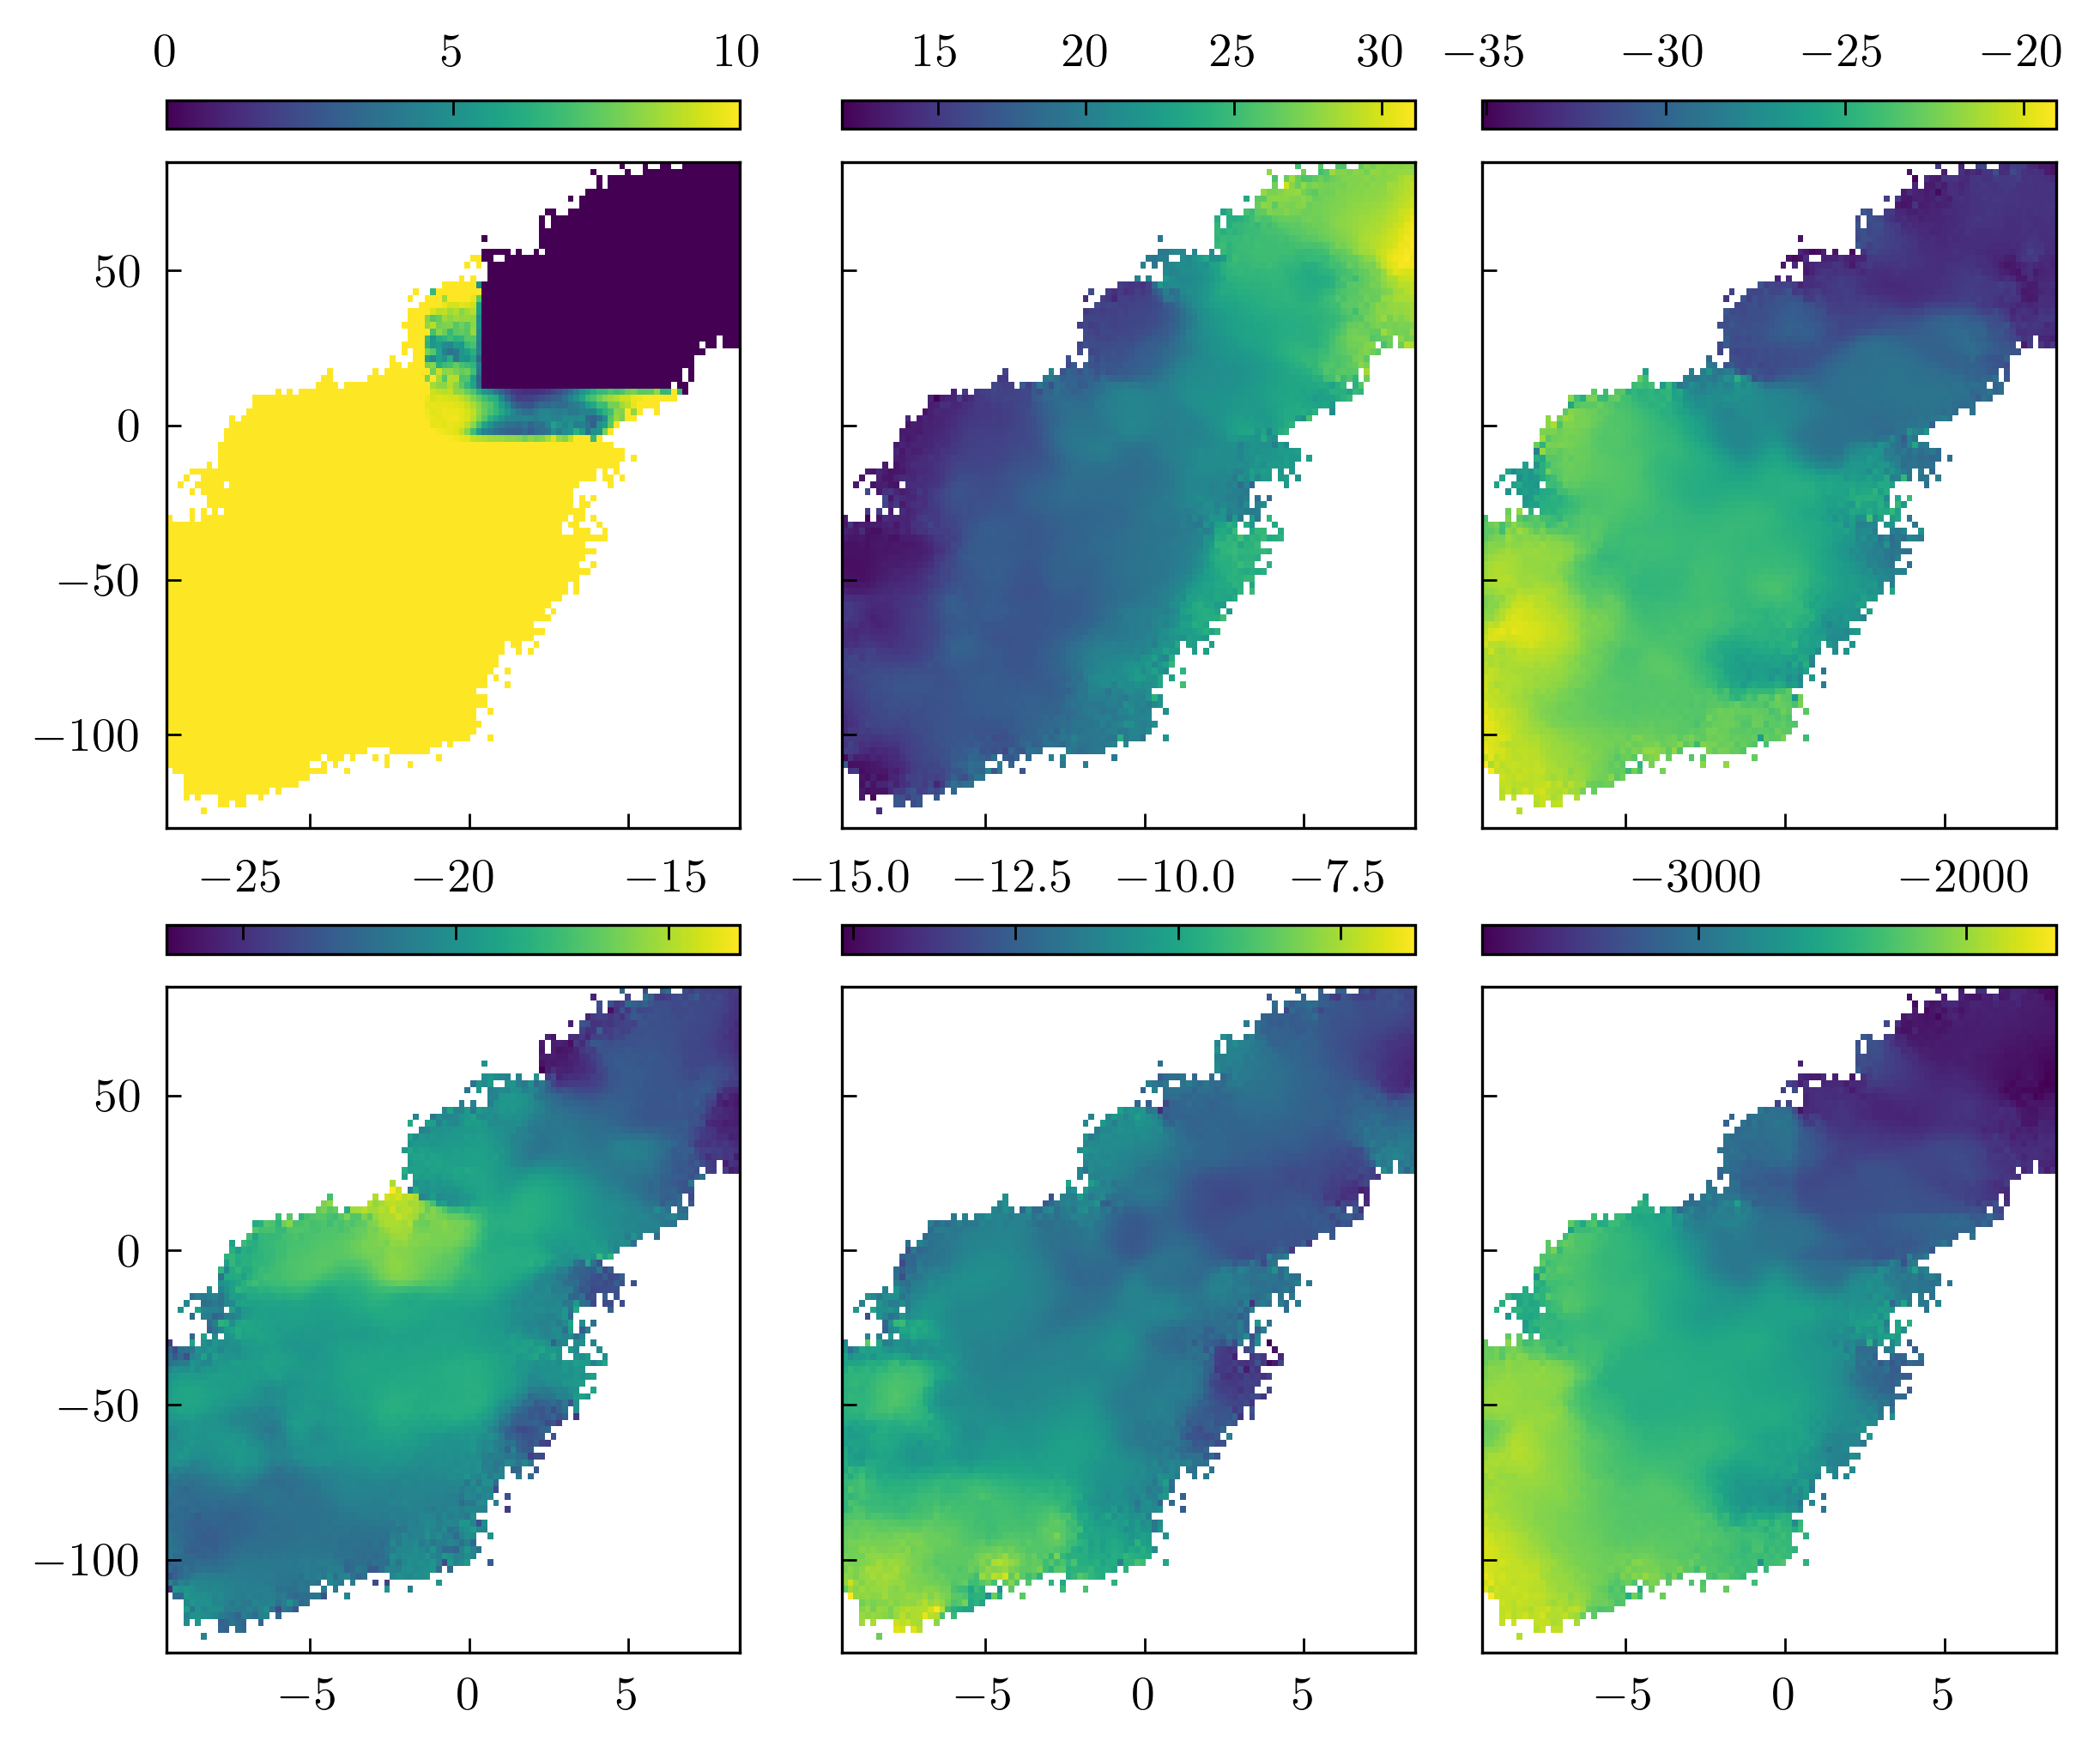

In [216]:
# plot initial network output
f, axs = plt.subplots(2, 3, figsize=(6, 5), sharex=True, sharey=True, dpi=200, constrained_layout=True)
xmin, xmax, ymin, ymax = -9.5, 8.5, -130, 85
xe = np.linspace(xmin, xmax, 101)
ye = np.linspace(ymin, ymax, 101)
xcent = (xe[1:] + xe[:-1]) / 2
ycent = (ye[1:] + ye[:-1]) / 2

cv_dataset = start_dataset(cv_trajs, config_base.lag)
w_dataset = start_dataset(weights[0], config_base.lag)

for i in range(5):
    ax = axs.flat[i]
    basis_bin = extq.projection.average2d([cv_dataset[:, 0]], [cv_dataset[:, 1]], [basis[0, :, i]], [w_dataset], xe, ye)
    pc = ax.pcolormesh(xcent, ycent, basis_bin.T)
    plt.colorbar(pc, ax=ax, location='top')
    
coeffs, mfpt = solve_dga(basis, dataset.integral, guess)
mfpt_bin = extq.projection.average2d([cv_dataset[:, 0]], [cv_dataset[:, 1]], [mfpt[0, :, 0]], [w_dataset], xe, ye)
pc = axs[-1, -1].pcolormesh(xcent, ycent, mfpt_bin.T * 0.1)
plt.colorbar(pc, ax=axs[-1, -1], location='top')

In [125]:
def train_loop(config, metrics, rng, state, dataset, basis, guess):
    for epoch in range(config.n_power_iter):
        rng, new_key = random.split(rng)
        if epoch < config.sigma:
            alpha = 1.0
        else:
            alpha = (epoch - config.sigma + 1) ** (-0.5)

        print(f"Epoch {epoch + 1} / {config.n_power_iter}")
        print("============================")

        epoch_loss, state, basis, R = subspace_iteration(
            epoch,
            state,
            dataset,
            basis,
            new_key,
            inner_iter=config.inner_iter,
            print_loss_every=config.print_loss_every,
            alpha=alpha,
            gamma=config.gamma,
            lamb=config.lamb,
            l2=config.lamb,
        )
        metrics["loss"].append(epoch_loss)
        metrics["params"].append(state.params)
        print(f"Min epoch loss: {epoch_loss:>7e}")
        print("===========================")

        coeffs, mfpt = solve_dga(basis, dataset.integral, guess)
        mfpt_bin = extq.projection.average2d([cv_dataset[:, 0]], [cv_dataset[:, 1]], [mfpt[0, :, 0]], [w_dataset], xe, ye)
        fig = plt.figure(figsize=(3, 2.5), dpi=200)
        ax = plt.gca()
        pc = ax.pcolormesh(xcent, ycent, mfpt_bin.T * 0.0001)
        plt.colorbar(pc, ax=ax, location='right', label="MFPT / $\mu$s")
        plt.show()
    return state, metrics, basis

In [150]:
key, k3, k4 = random.split(key, num=3)
model, state = setup(config_base, k3)

In [128]:
print(model.tabulate(rng, jnp.ones(shape=(1, config_base.input_dim)), jnp.ones(shape=(1, 1))))


                               MFPTNetSI Summary                                
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module    ┃ inputs          ┃ outputs        ┃ params              ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│         │ MFPTNetSI │ - float32[1,60] │ float32[1,5]   │                     │
│         │           │ - float32[1,1]  │                │                     │
├─────────┼───────────┼─────────────────┼────────────────┼─────────────────────┤
│ Dense_0 │ Dense     │ float32[1,60]   │ float32[1,128] │ bias: float32[128]  │
│         │           │                 │                │ kernel:             │
│         │           │                 │                │ float32[60,128]     │
│         │           │                 │                │                     │
│         │           │                 │                │ 7,808 (31.2 KB)     │
├─────────┼───────────┼────

Epoch 1 / 200
Loss: -9.811057e+01 [    0 /  2000]
Loss: -9.083671e+02 [  500 /  2000]
Loss: -9.239115e+02 [ 1000 /  2000]
Loss: -9.001549e+02 [ 1500 /  2000]
Min epoch loss: -9.510606e+02


/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in divide
  return numer / denom


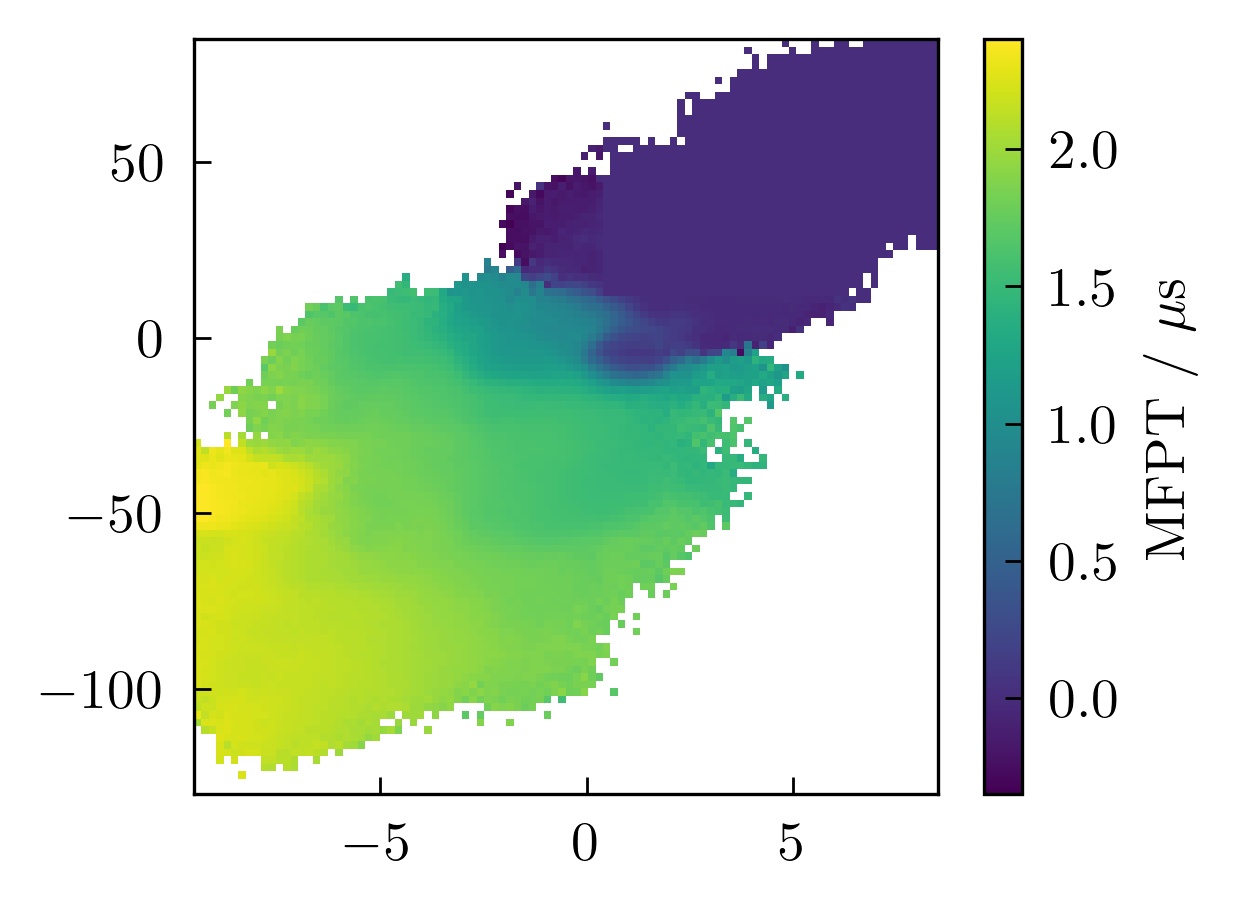

Epoch 2 / 200
Loss: 6.358425e+02 [    0 /  2000]
Loss: -3.852329e+01 [  500 /  2000]
Loss: -3.914942e+01 [ 1000 /  2000]
Loss: -3.880452e+01 [ 1500 /  2000]
Min epoch loss: -4.175399e+01


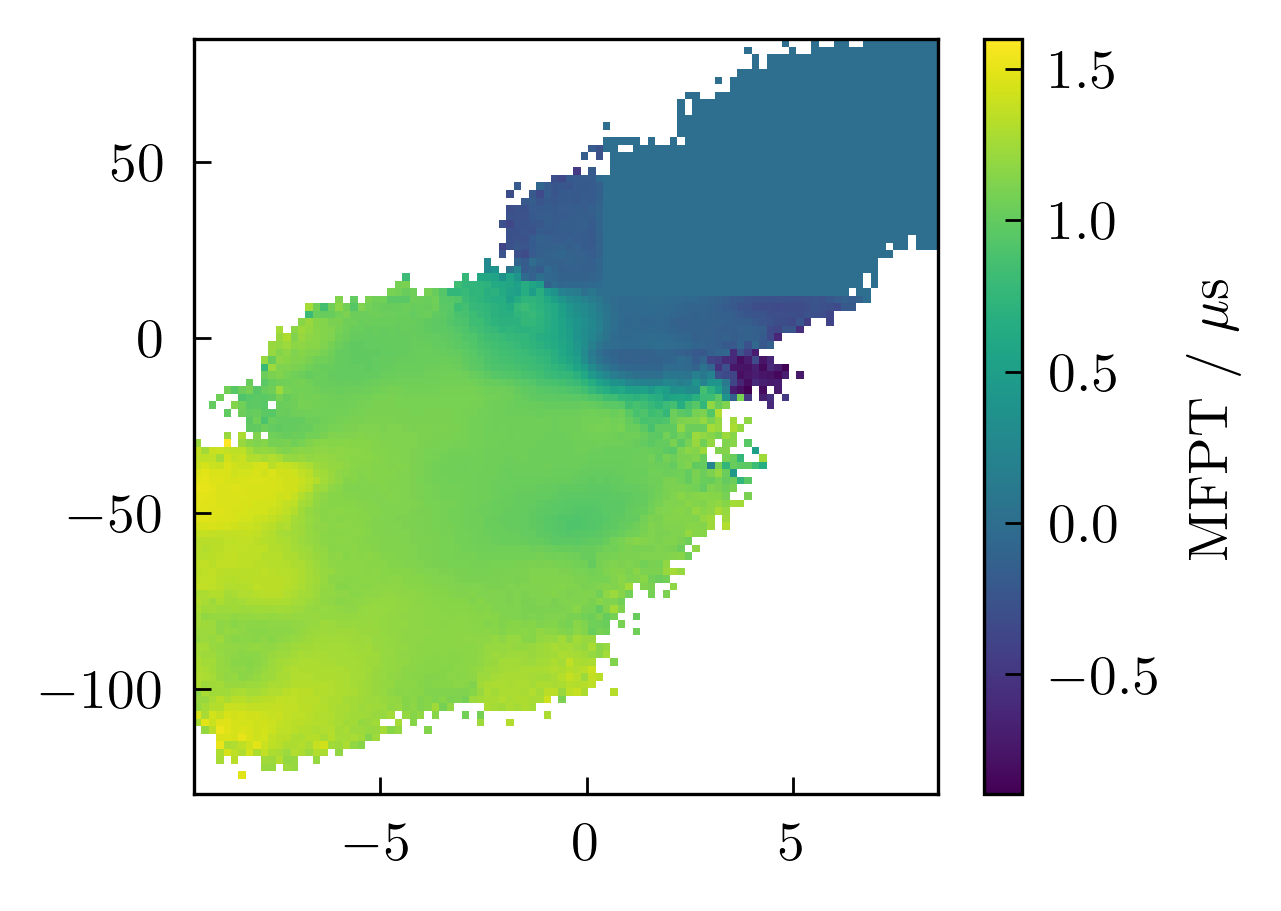

Epoch 3 / 200
Loss: 2.960739e+02 [    0 /  2000]
Loss: -3.498271e+02 [  500 /  2000]
Loss: -3.589037e+02 [ 1000 /  2000]
Loss: -3.553326e+02 [ 1500 /  2000]
Min epoch loss: -3.826880e+02


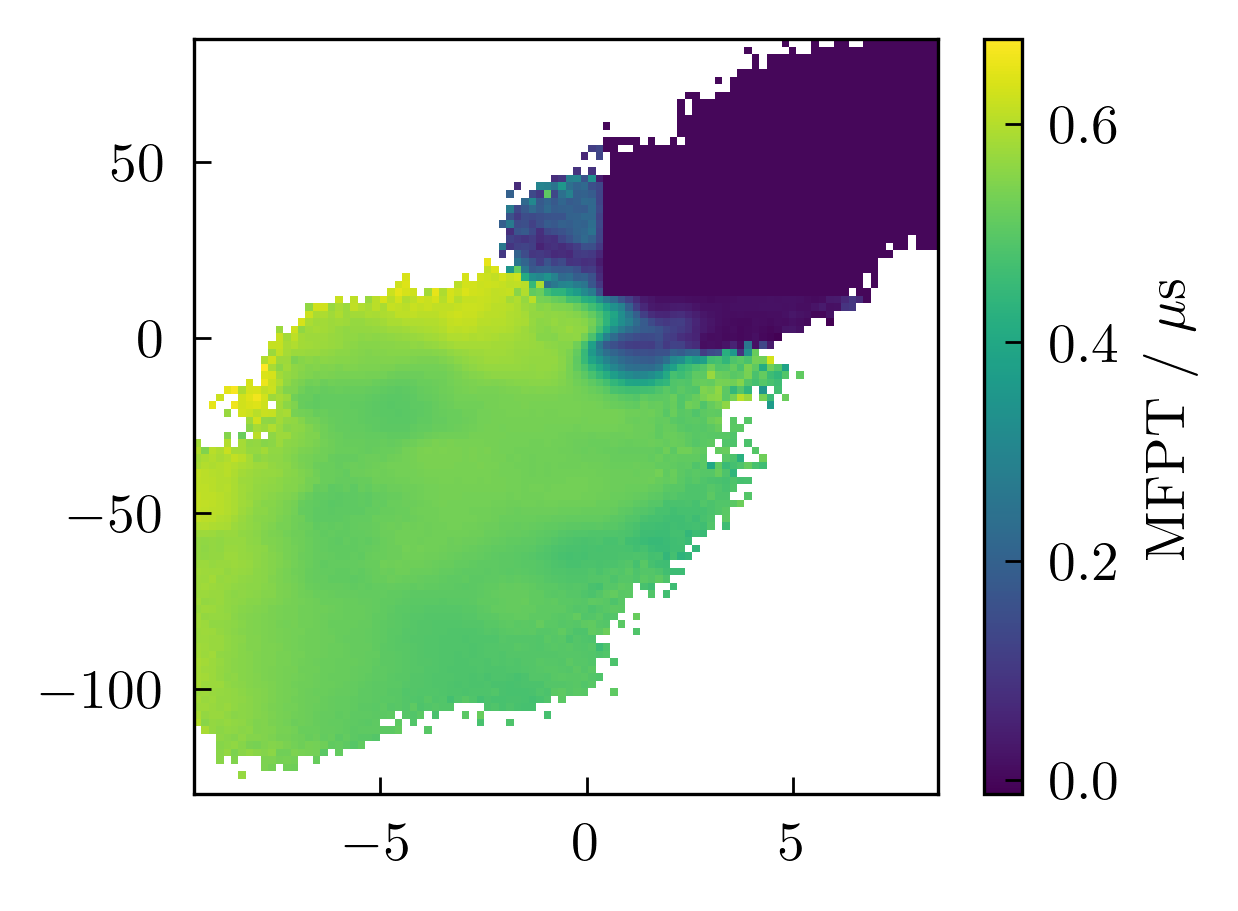

Epoch 4 / 200
Loss: 6.225337e+02 [    0 /  2000]
Loss: -3.666309e+01 [  500 /  2000]
Loss: -3.760098e+01 [ 1000 /  2000]
Loss: -3.616225e+01 [ 1500 /  2000]
Min epoch loss: -3.889674e+01


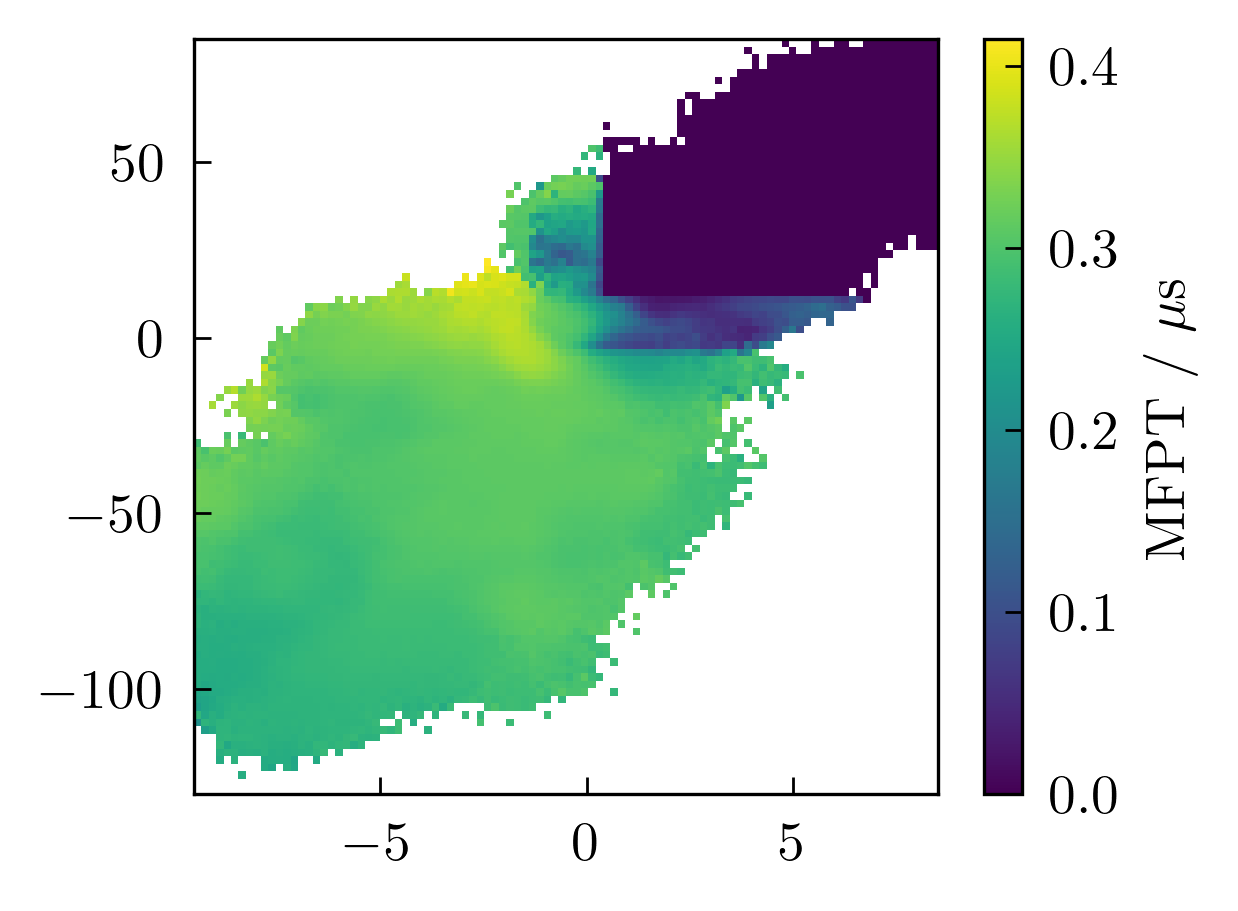

Epoch 5 / 200
Loss: 3.318492e+02 [    0 /  2000]
Loss: -3.346475e+02 [  500 /  2000]
Loss: -3.346794e+02 [ 1000 /  2000]
Loss: -3.344007e+02 [ 1500 /  2000]
Min epoch loss: -3.595736e+02


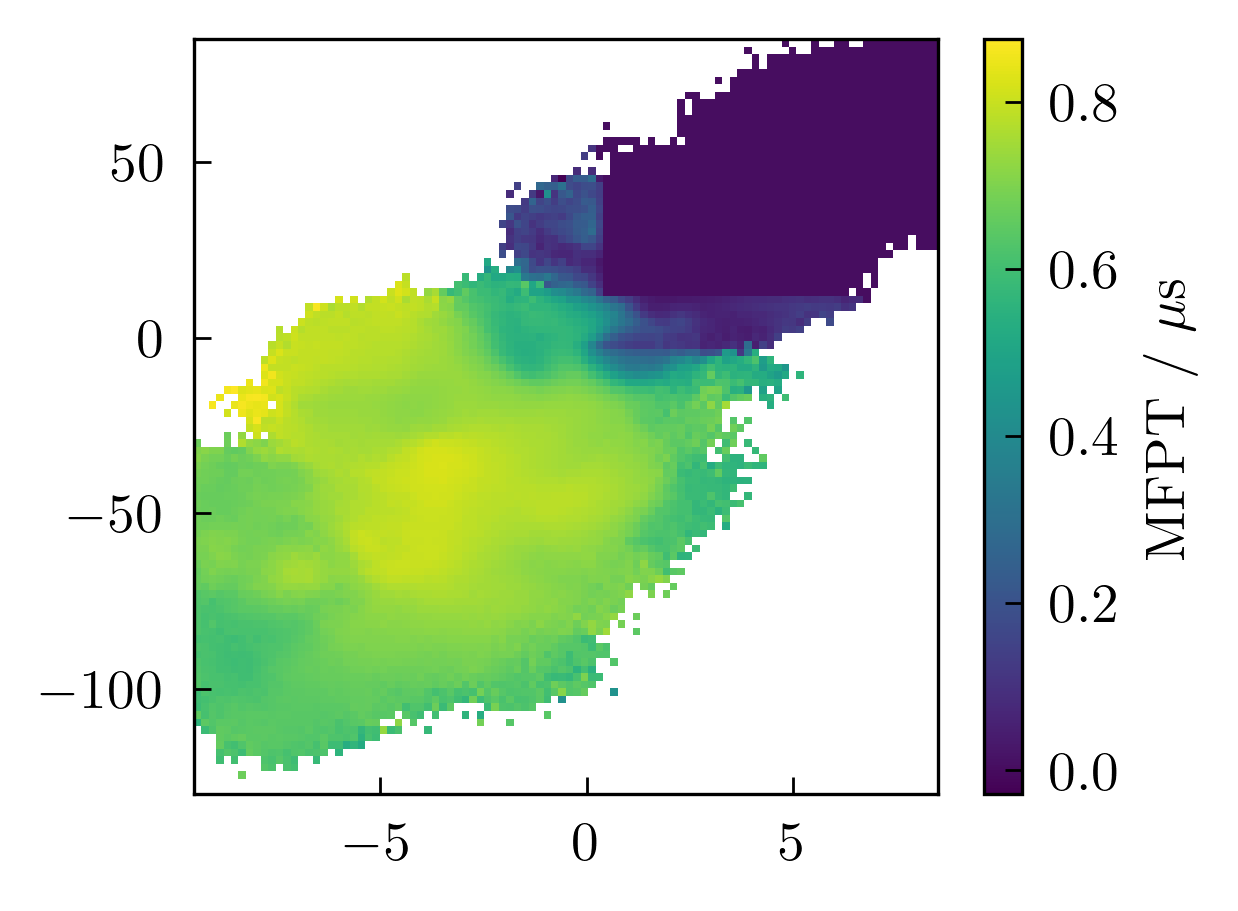

Epoch 6 / 200
Loss: 6.417318e+02 [    0 /  2000]
Loss: -2.946082e+01 [  500 /  2000]
Loss: -3.018370e+01 [ 1000 /  2000]
Loss: -3.093253e+01 [ 1500 /  2000]
Min epoch loss: -3.494070e+01


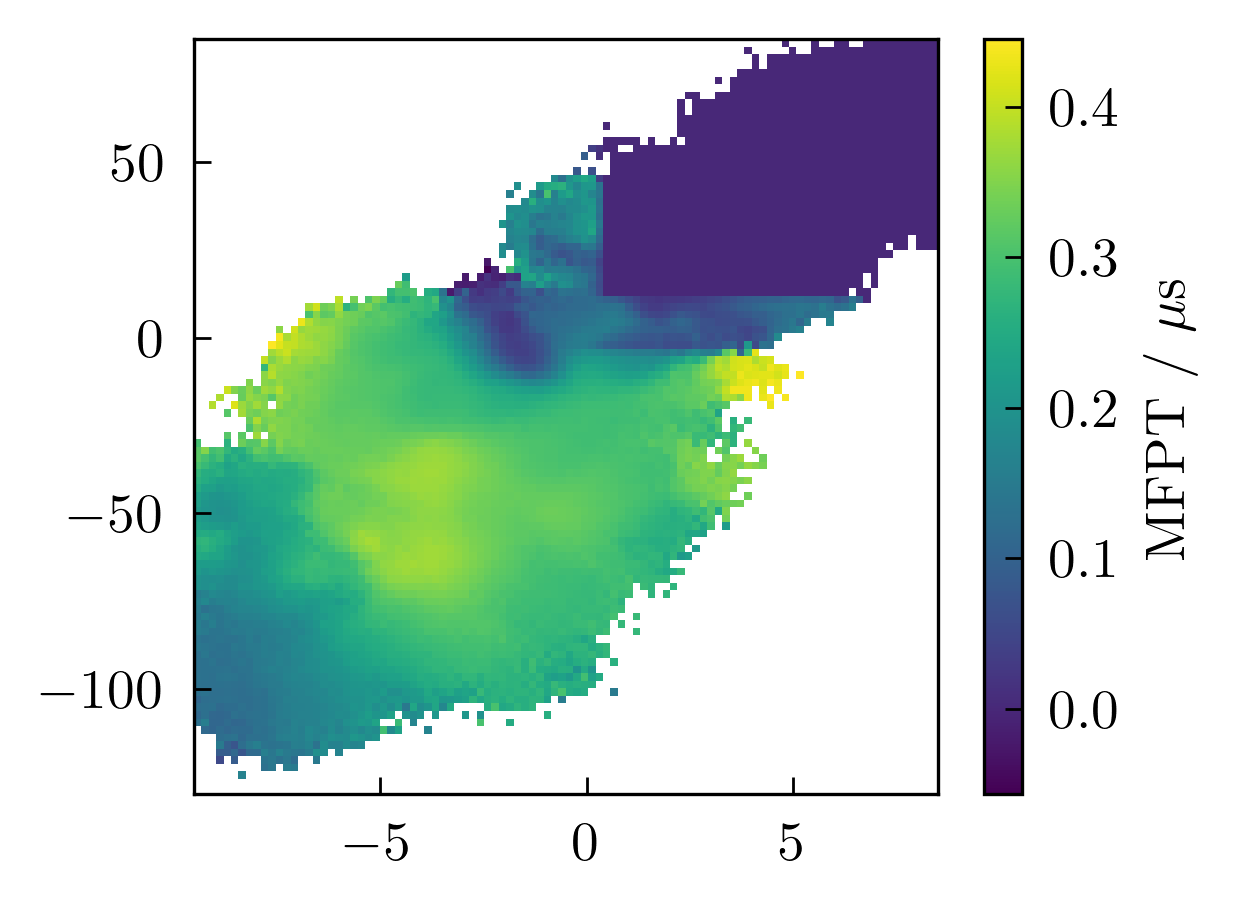

Epoch 7 / 200
Loss: 3.049930e+02 [    0 /  2000]
Loss: -3.368895e+02 [  500 /  2000]
Loss: -3.412126e+02 [ 1000 /  2000]
Loss: -3.531493e+02 [ 1500 /  2000]
Min epoch loss: -3.661994e+02


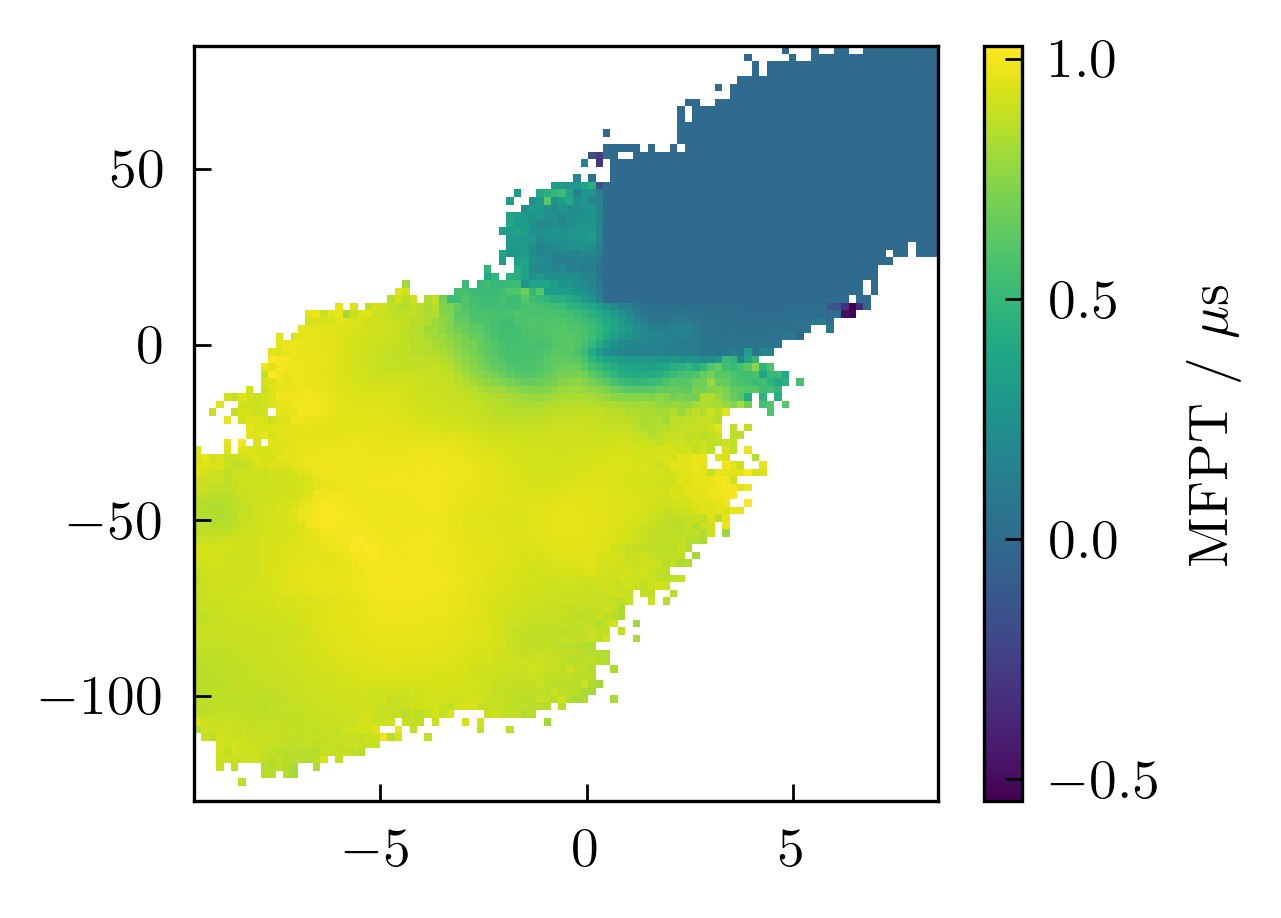

Epoch 8 / 200
Loss: 6.640026e+02 [    0 /  2000]
Loss: -1.321411e+01 [  500 /  2000]
Loss: -1.375083e+01 [ 1000 /  2000]
Loss: -1.520374e+01 [ 1500 /  2000]
Min epoch loss: -1.835187e+01


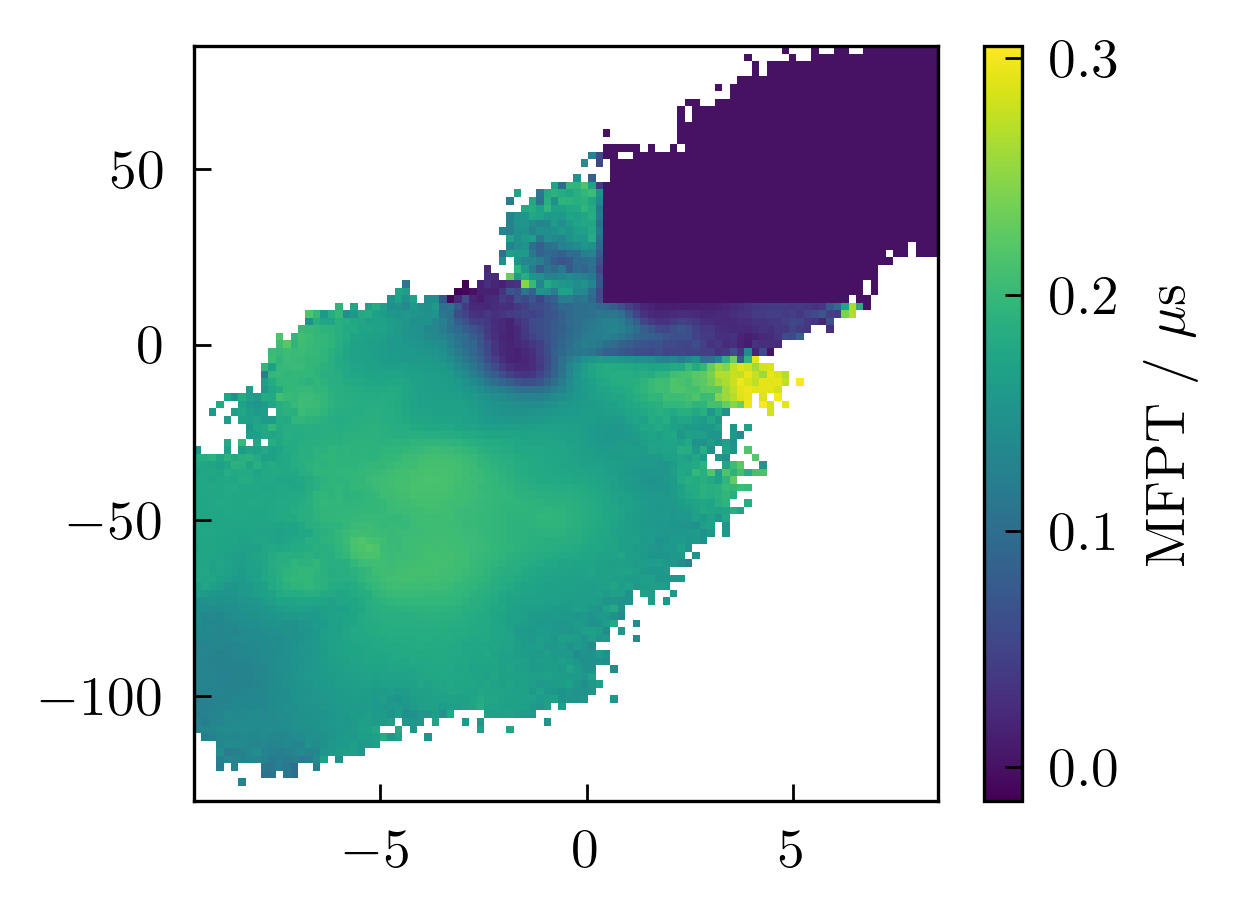

Epoch 9 / 200
Loss: 2.915641e+02 [    0 /  2000]
Loss: -3.673344e+02 [  500 /  2000]
Loss: -3.613937e+02 [ 1000 /  2000]
Loss: -3.628922e+02 [ 1500 /  2000]
Min epoch loss: -3.807709e+02


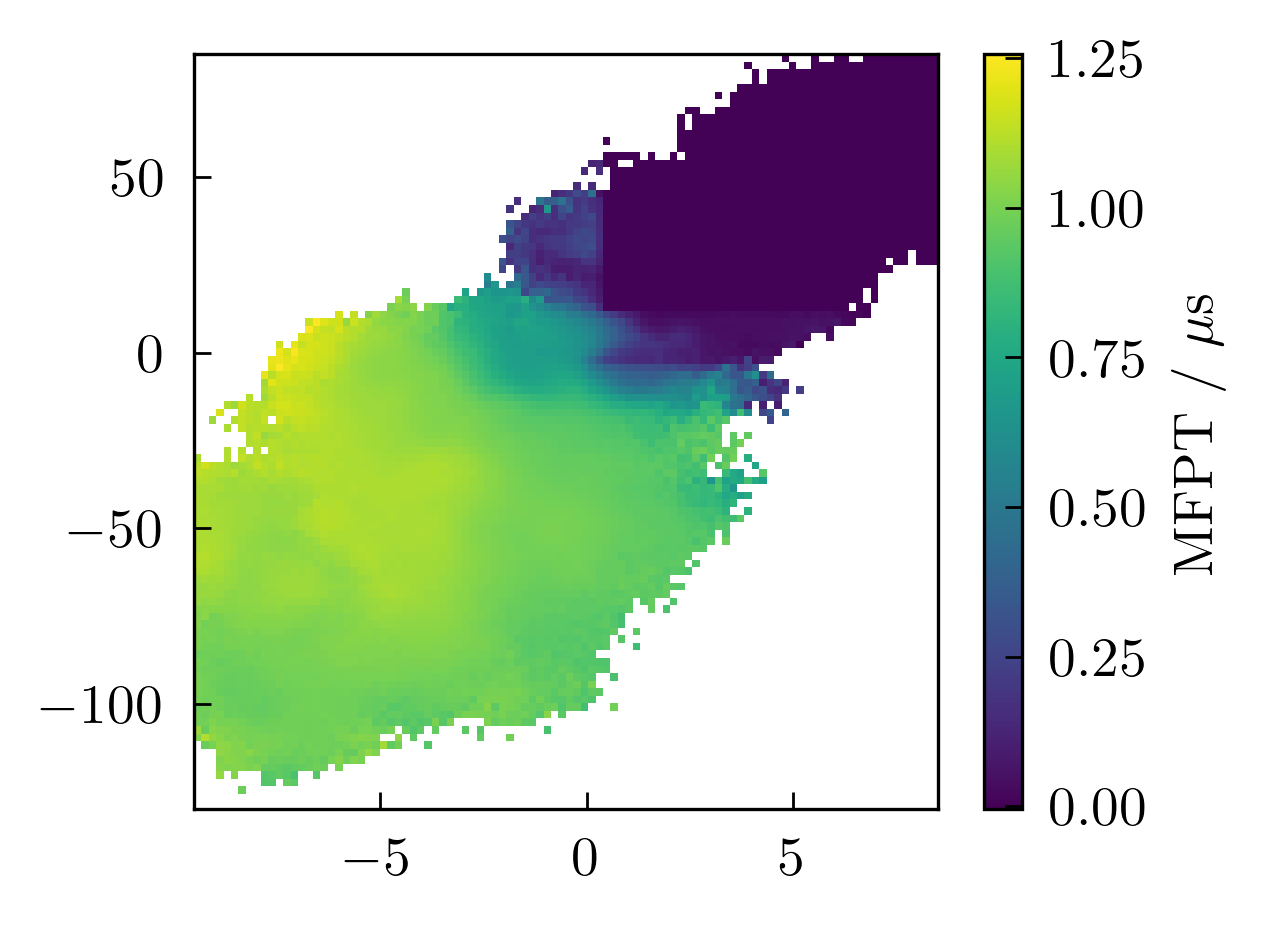

Epoch 10 / 200
Loss: 6.988686e+02 [    0 /  2000]
Loss: 1.833216e+01 [  500 /  2000]
Loss: 1.572357e+01 [ 1000 /  2000]
Loss: 1.605120e+01 [ 1500 /  2000]
Min epoch loss: 1.275327e+01


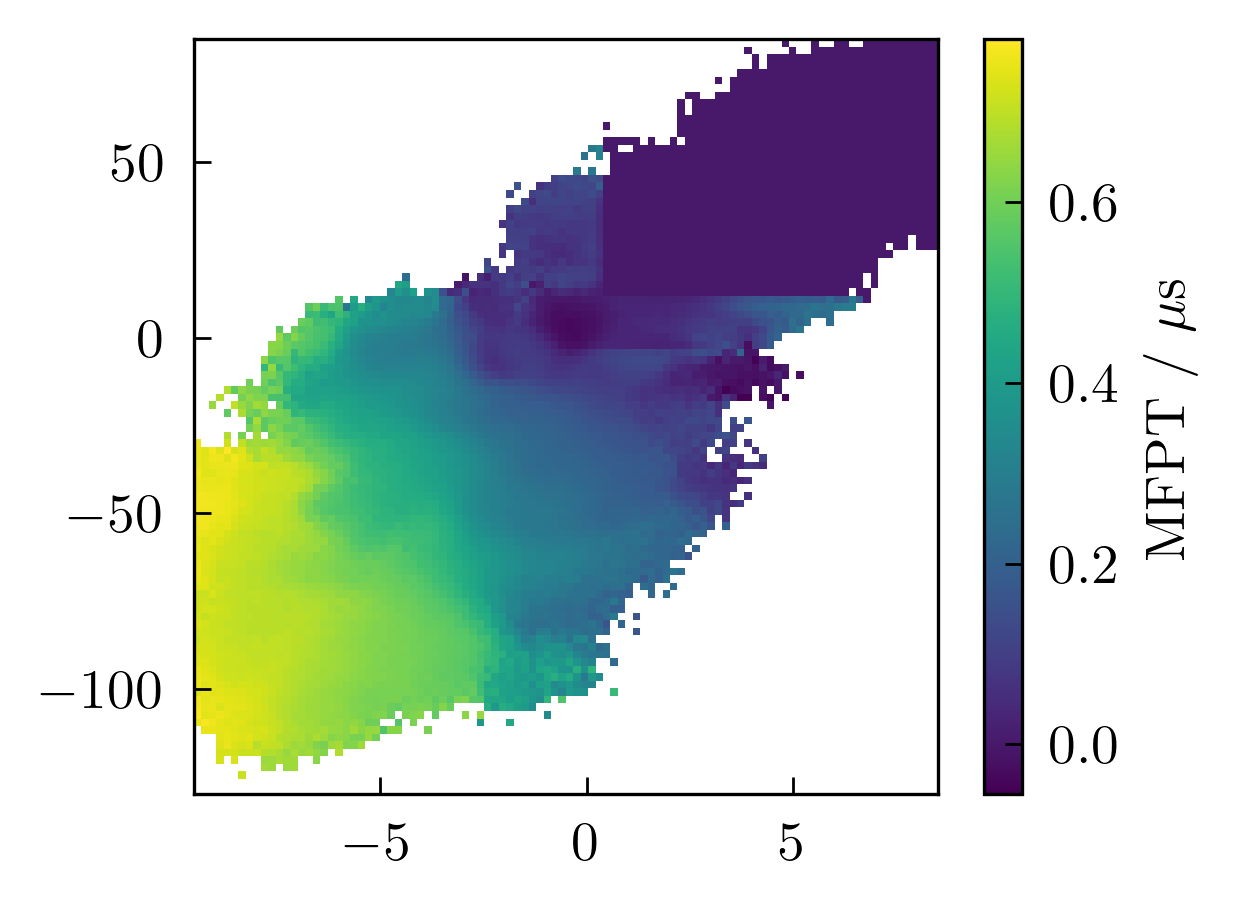

Epoch 11 / 200
Loss: 2.500365e+02 [    0 /  2000]
Loss: -4.012397e+02 [  500 /  2000]
Loss: -4.106042e+02 [ 1000 /  2000]
Loss: -4.083701e+02 [ 1500 /  2000]
Min epoch loss: -4.290636e+02


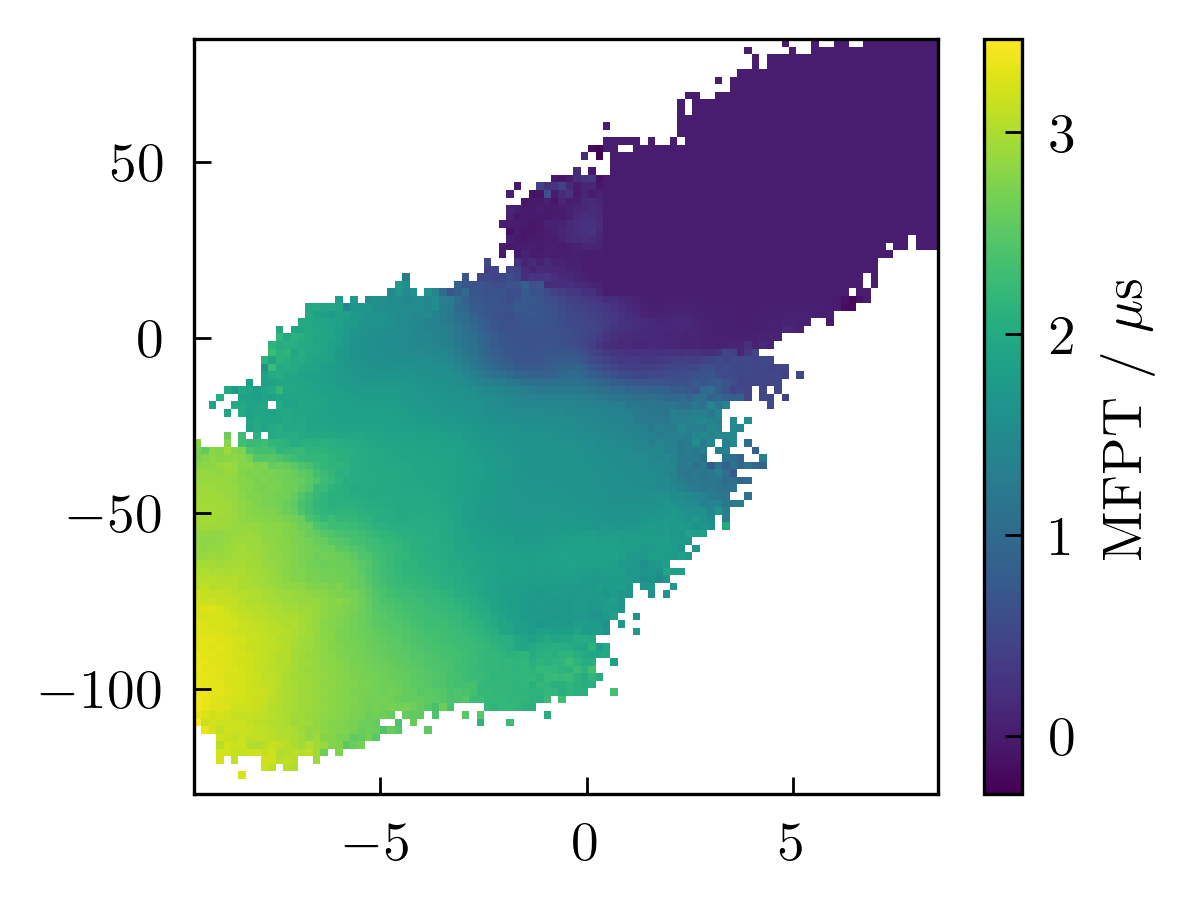

Epoch 12 / 200
Loss: 7.257119e+02 [    0 /  2000]
Loss: 7.203158e+01 [  500 /  2000]
Loss: 7.062752e+01 [ 1000 /  2000]
Loss: 7.028979e+01 [ 1500 /  2000]
Min epoch loss: 6.746895e+01


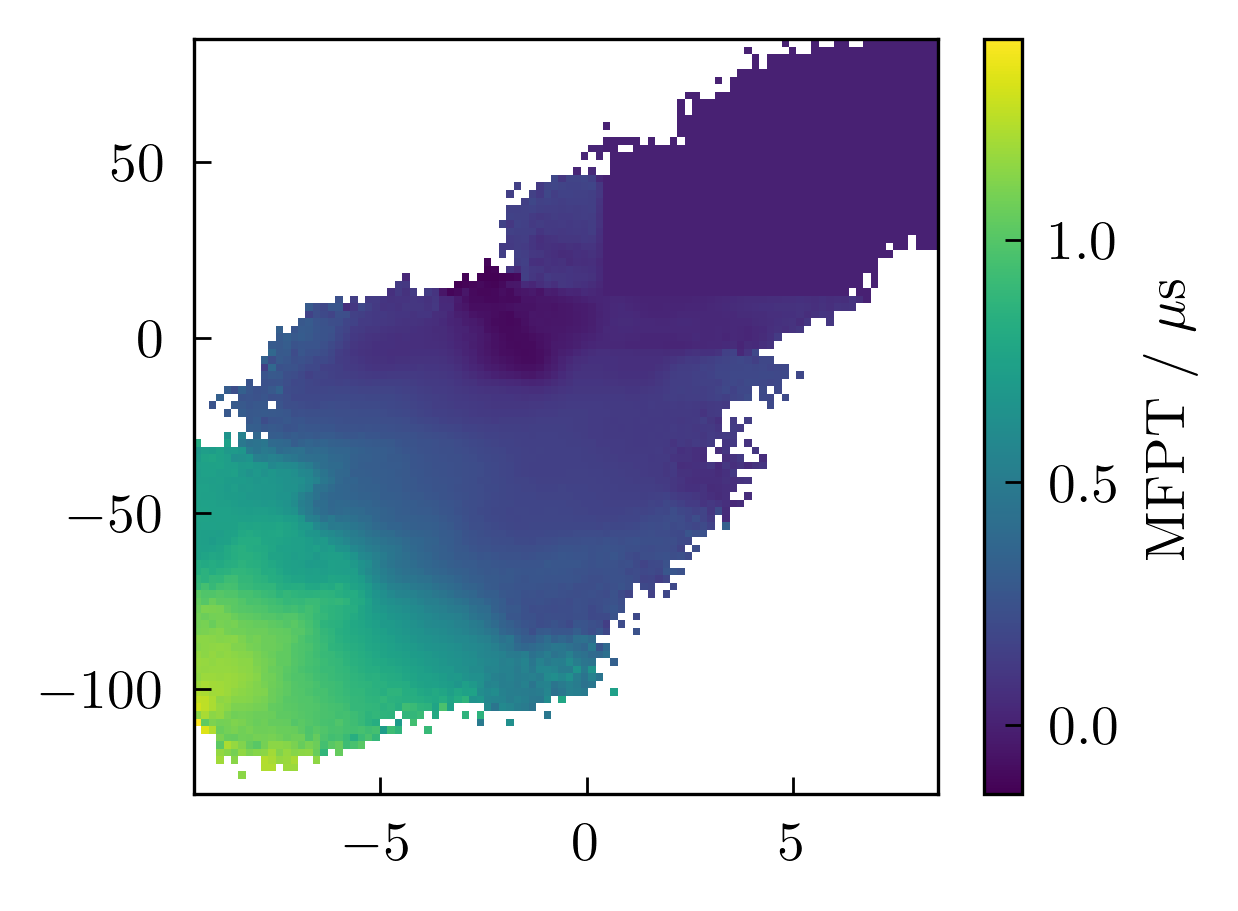

Epoch 13 / 200
Loss: 1.730306e+02 [    0 /  2000]
Loss: -4.714815e+02 [  500 /  2000]
Loss: -4.552704e+02 [ 1000 /  2000]
Loss: -4.613715e+02 [ 1500 /  2000]
Min epoch loss: -4.952881e+02


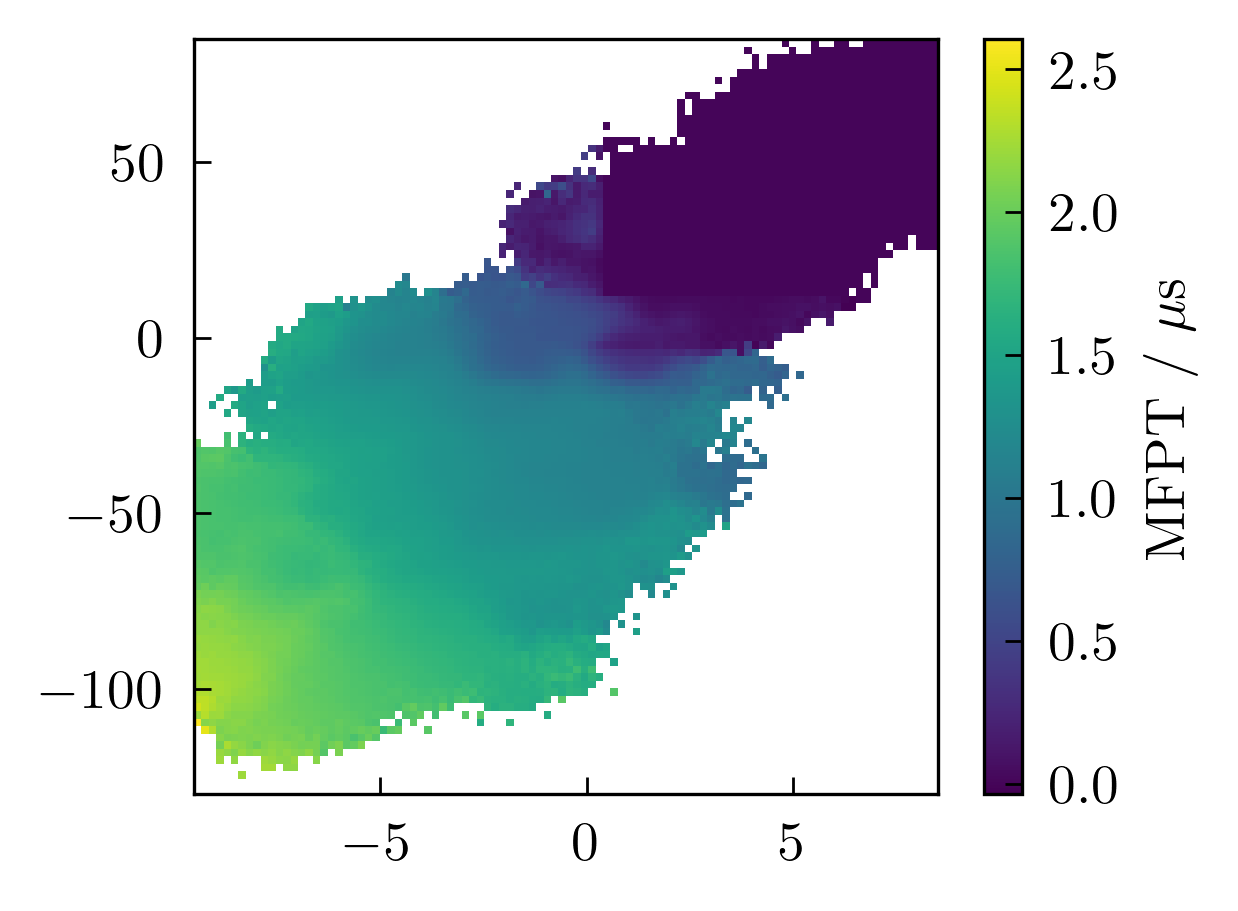

Epoch 14 / 200
Loss: 7.216680e+02 [    0 /  2000]
Loss: 4.569944e+01 [  500 /  2000]
Loss: 4.452866e+01 [ 1000 /  2000]
Loss: 4.473668e+01 [ 1500 /  2000]
Min epoch loss: 4.173322e+01


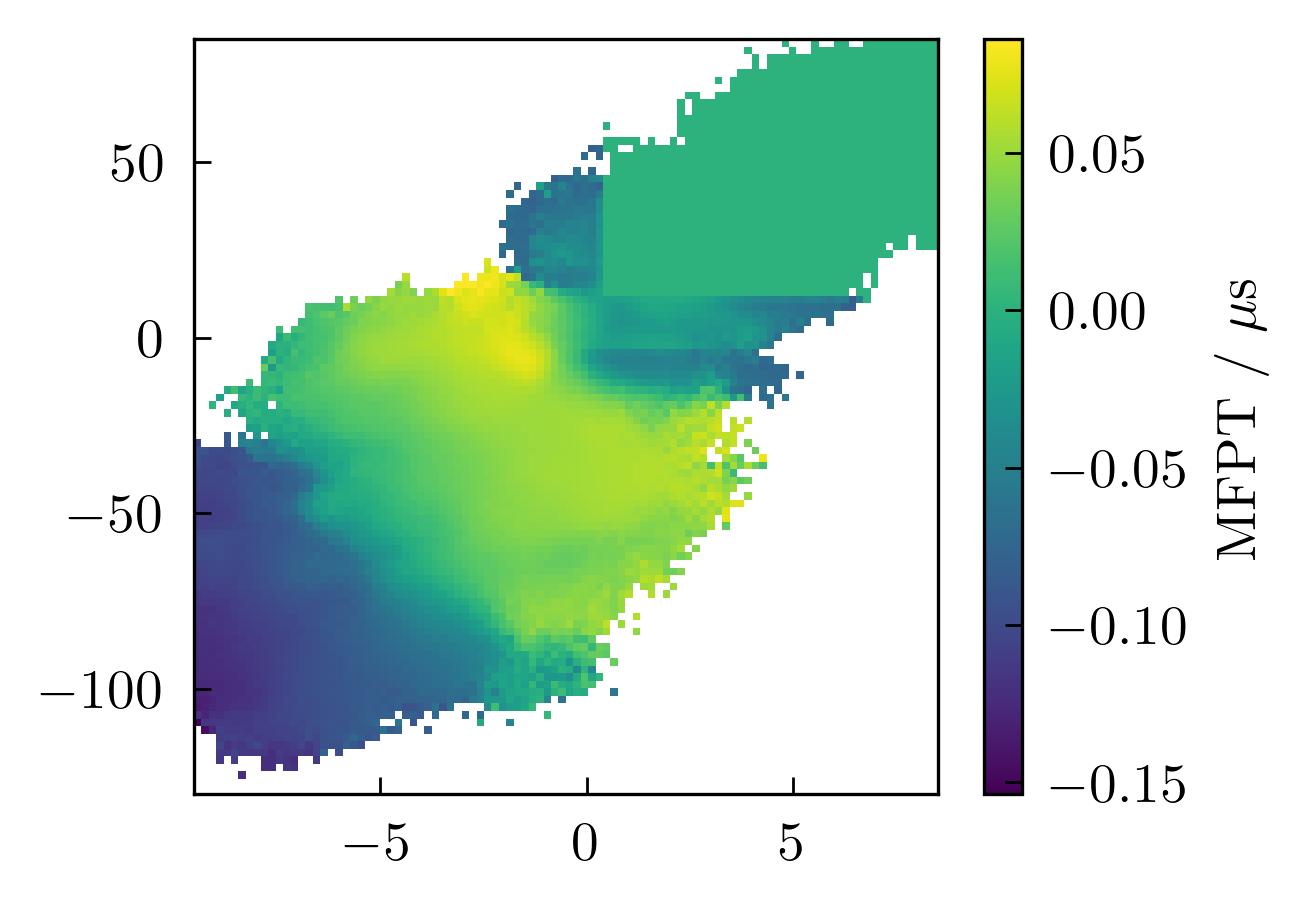

Epoch 15 / 200
Loss: 1.086099e+02 [    0 /  2000]
Loss: -5.232131e+02 [  500 /  2000]
Loss: -5.300725e+02 [ 1000 /  2000]
Loss: -5.236682e+02 [ 1500 /  2000]
Min epoch loss: -5.665759e+02


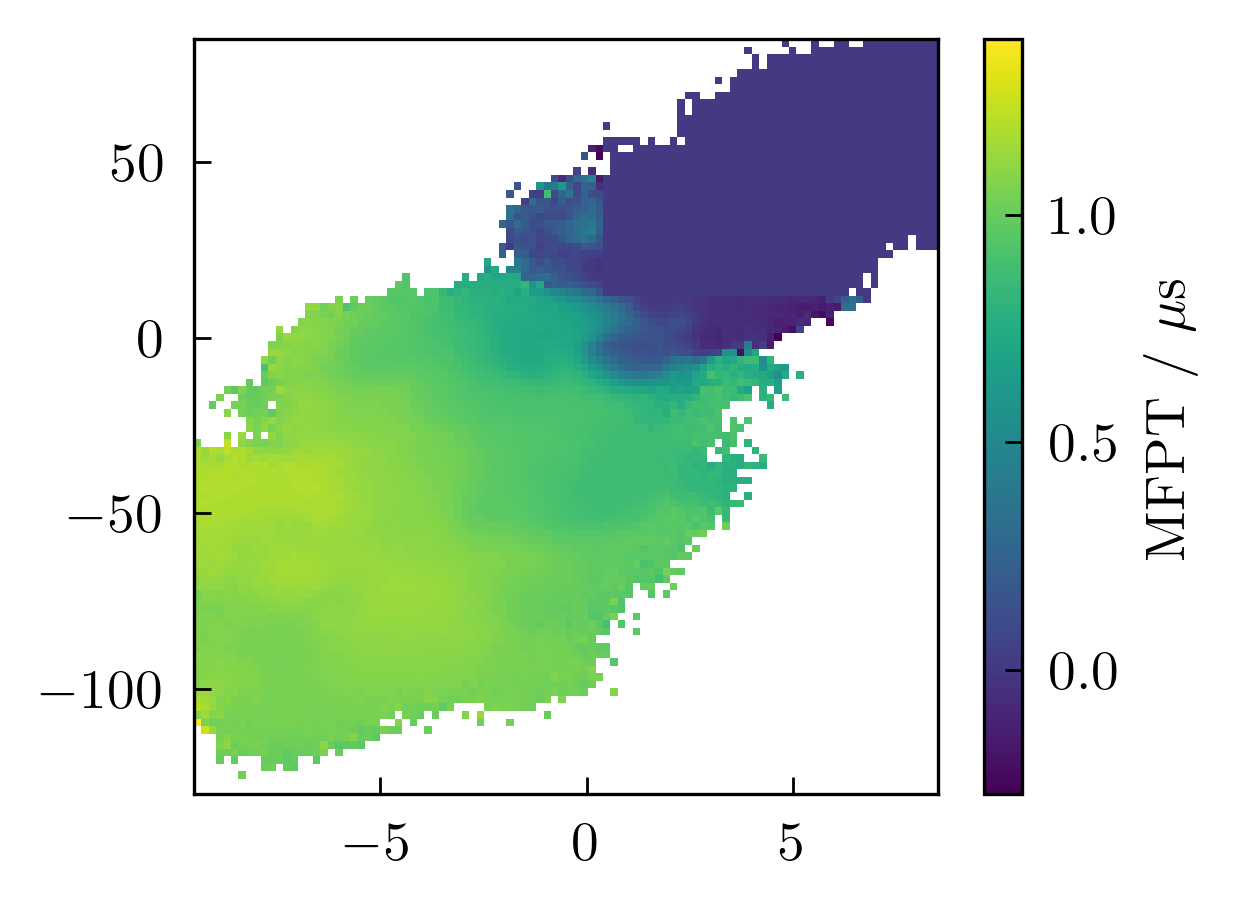

Epoch 16 / 200
Loss: 6.525872e+02 [    0 /  2000]
Loss: 3.373273e+00 [  500 /  2000]
Loss: 1.269965e+00 [ 1000 /  2000]
Loss: 1.825039e+00 [ 1500 /  2000]
Min epoch loss: -2.081310e-01


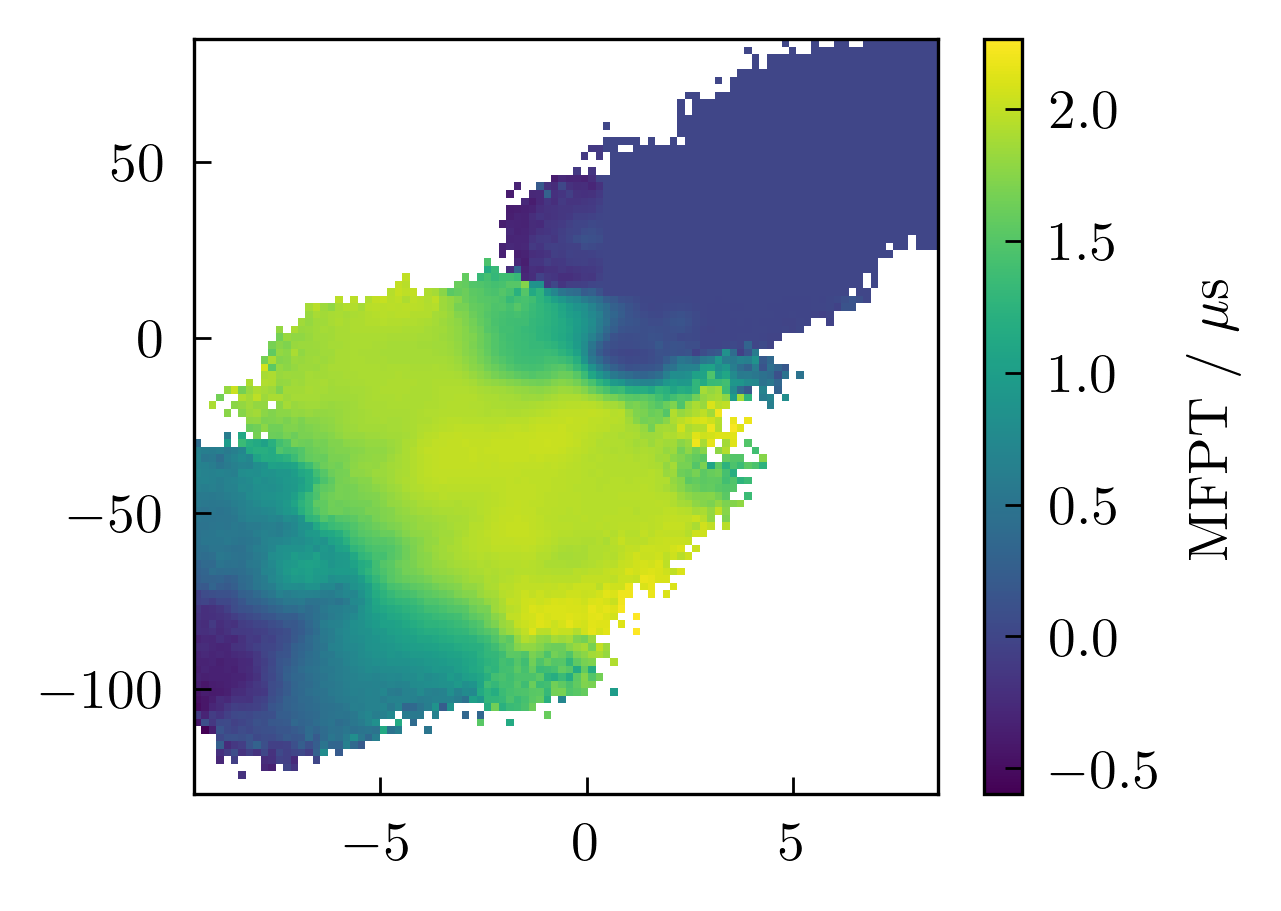

Epoch 17 / 200
Loss: 3.416500e+02 [    0 /  2000]
Loss: -2.986067e+02 [  500 /  2000]
Loss: -3.040257e+02 [ 1000 /  2000]
Loss: -3.133948e+02 [ 1500 /  2000]
Min epoch loss: -3.334132e+02


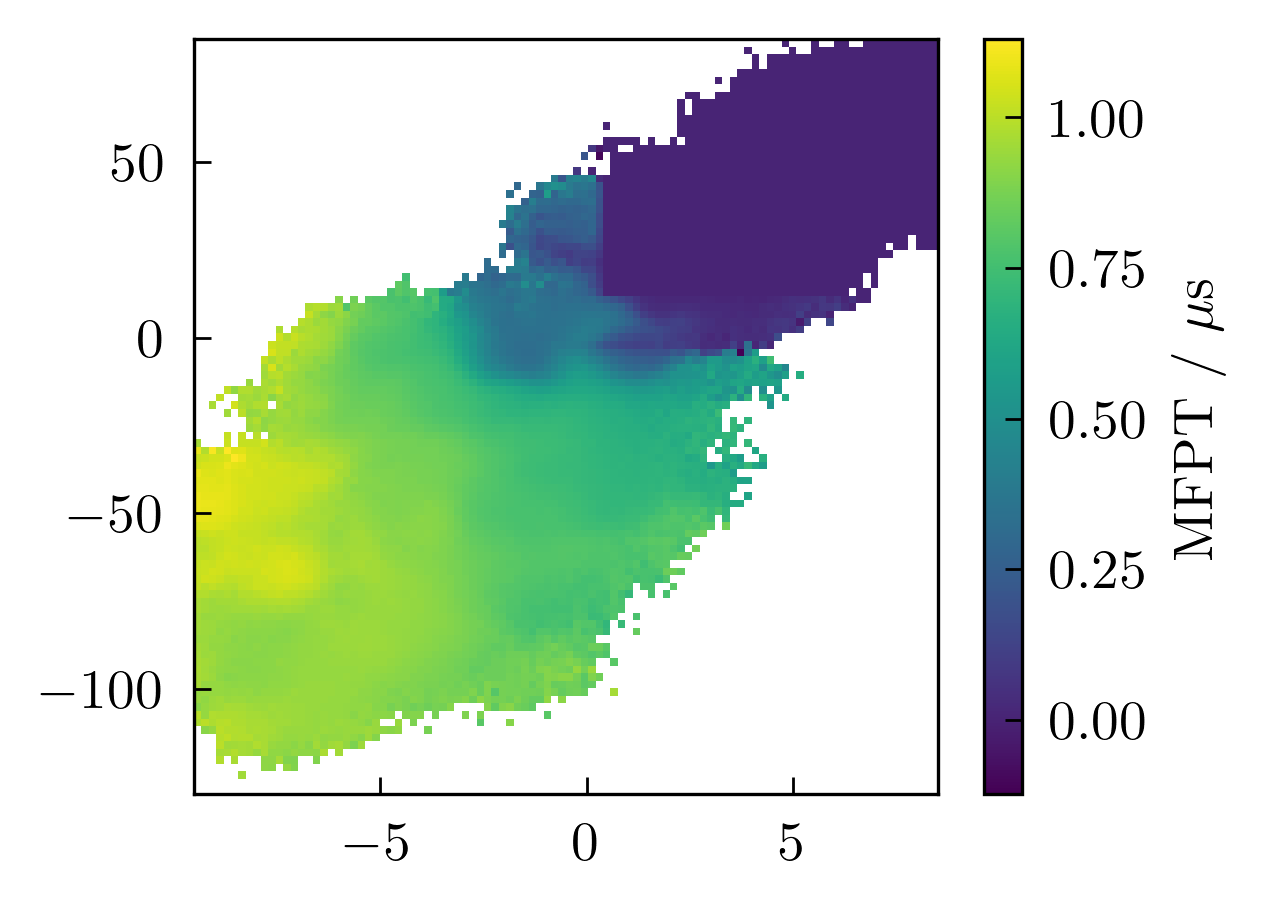

Epoch 18 / 200
Loss: 6.812085e+02 [    0 /  2000]
Loss: 1.095968e+01 [  500 /  2000]
Loss: 1.274091e+01 [ 1000 /  2000]
Loss: 1.198927e+01 [ 1500 /  2000]
Min epoch loss: 9.305792e+00


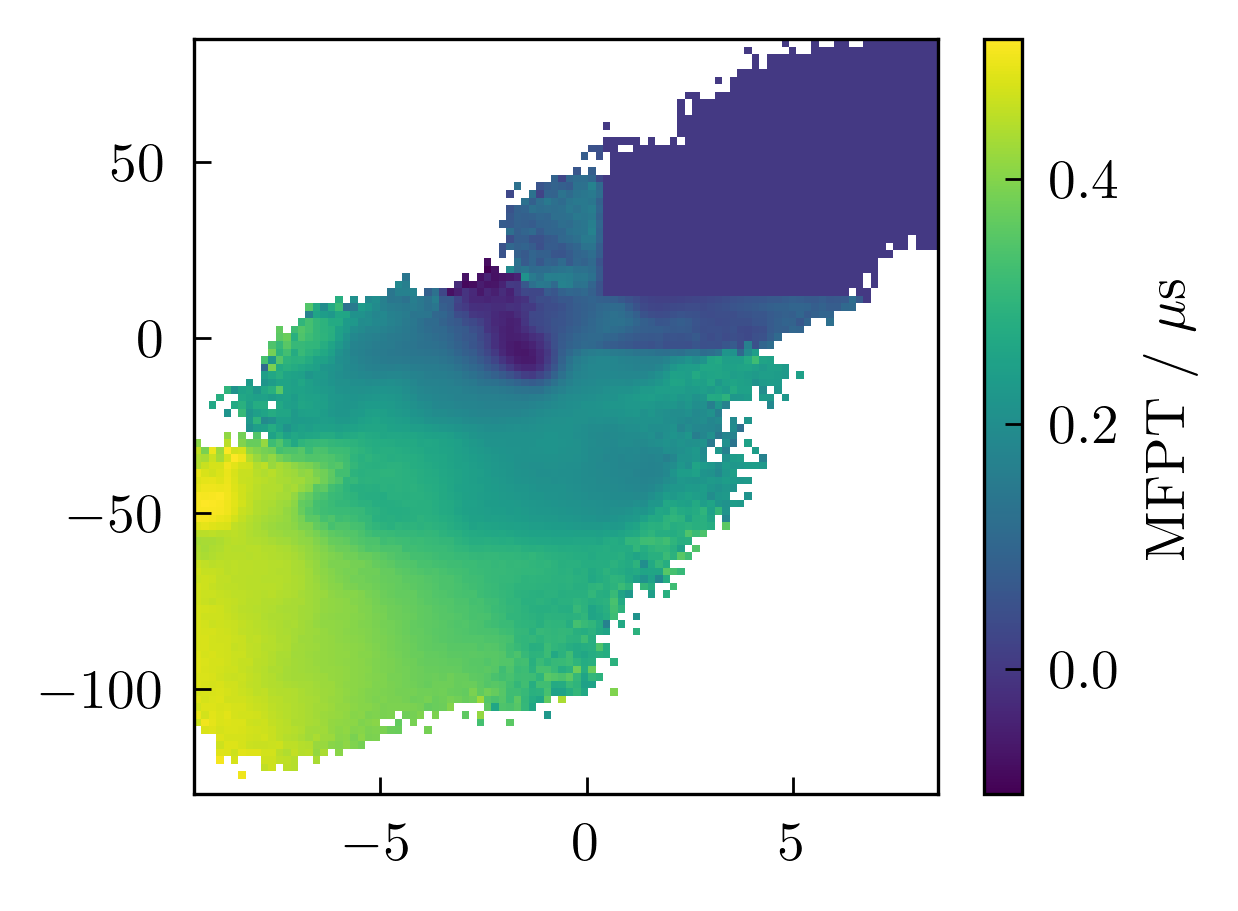

Epoch 19 / 200
Loss: 2.308645e+02 [    0 /  2000]
Loss: -4.315787e+02 [  500 /  2000]
Loss: -4.306613e+02 [ 1000 /  2000]
Loss: -4.256912e+02 [ 1500 /  2000]
Min epoch loss: -4.524513e+02


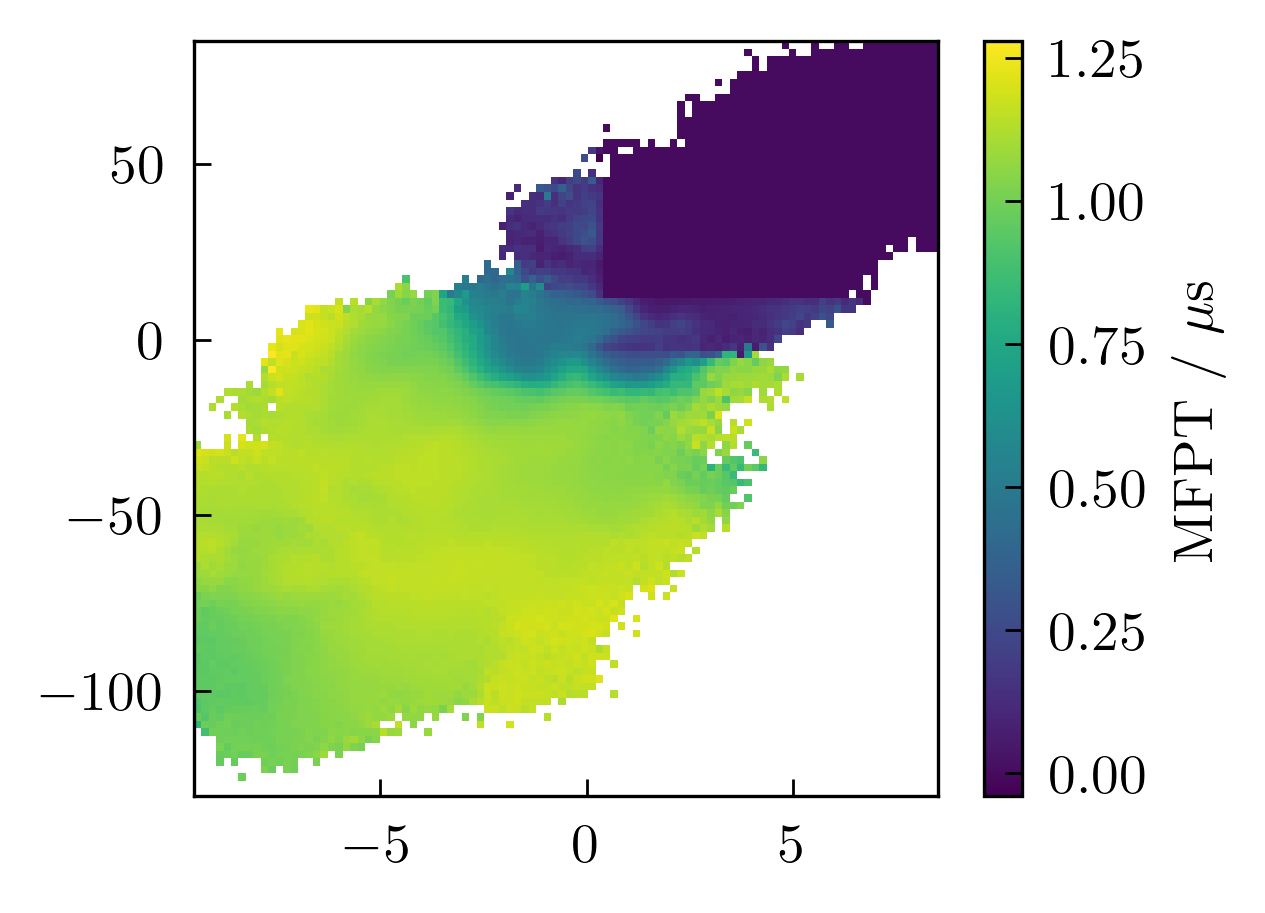

Epoch 20 / 200
Loss: 6.841683e+02 [    0 /  2000]
Loss: -1.010851e+01 [  500 /  2000]
Loss: -1.194987e+01 [ 1000 /  2000]
Loss: -1.111460e+01 [ 1500 /  2000]
Min epoch loss: -1.353631e+01


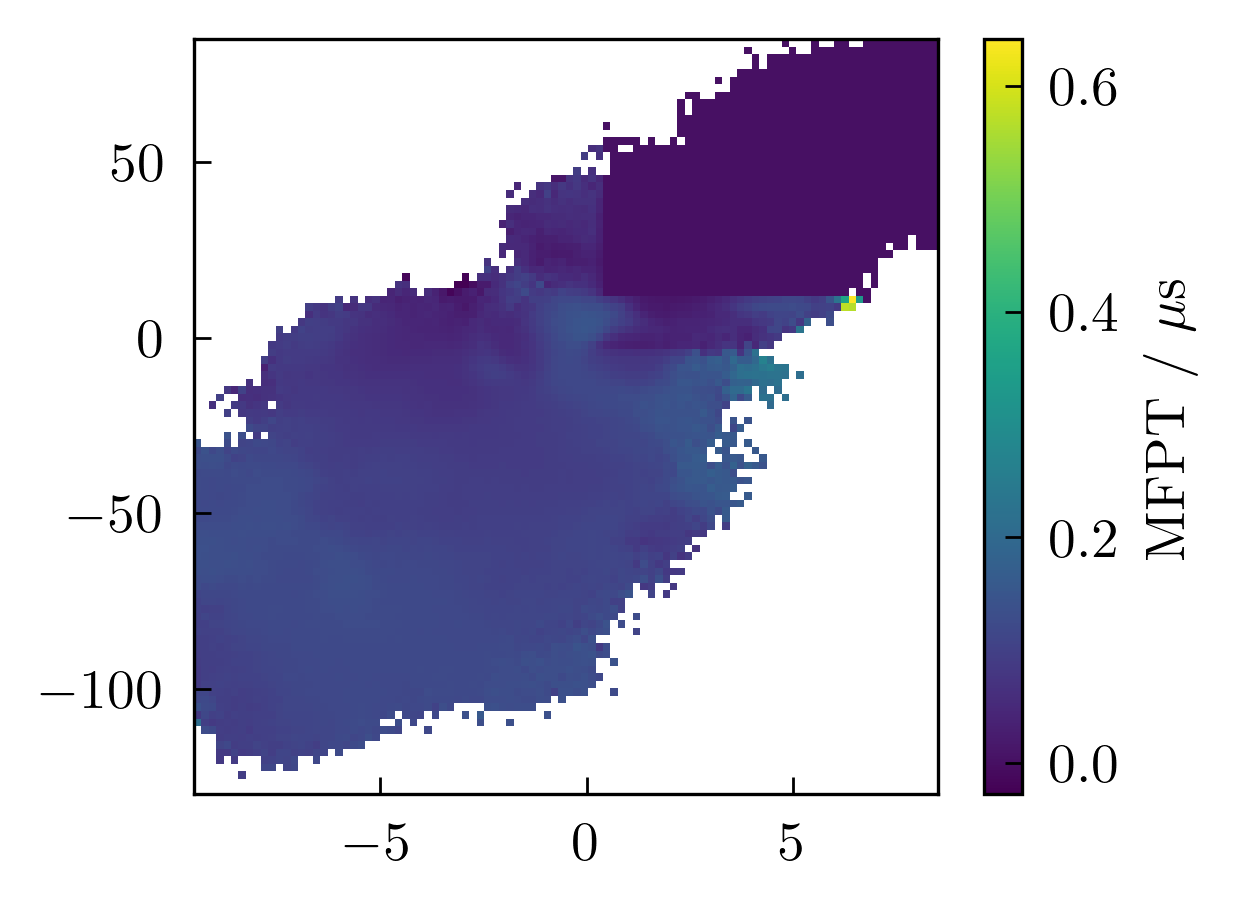

Epoch 21 / 200
Loss: 1.545927e+02 [    0 /  2000]
Loss: -5.029887e+02 [  500 /  2000]
Loss: -4.920808e+02 [ 1000 /  2000]
Loss: -4.988702e+02 [ 1500 /  2000]
Min epoch loss: -5.210856e+02


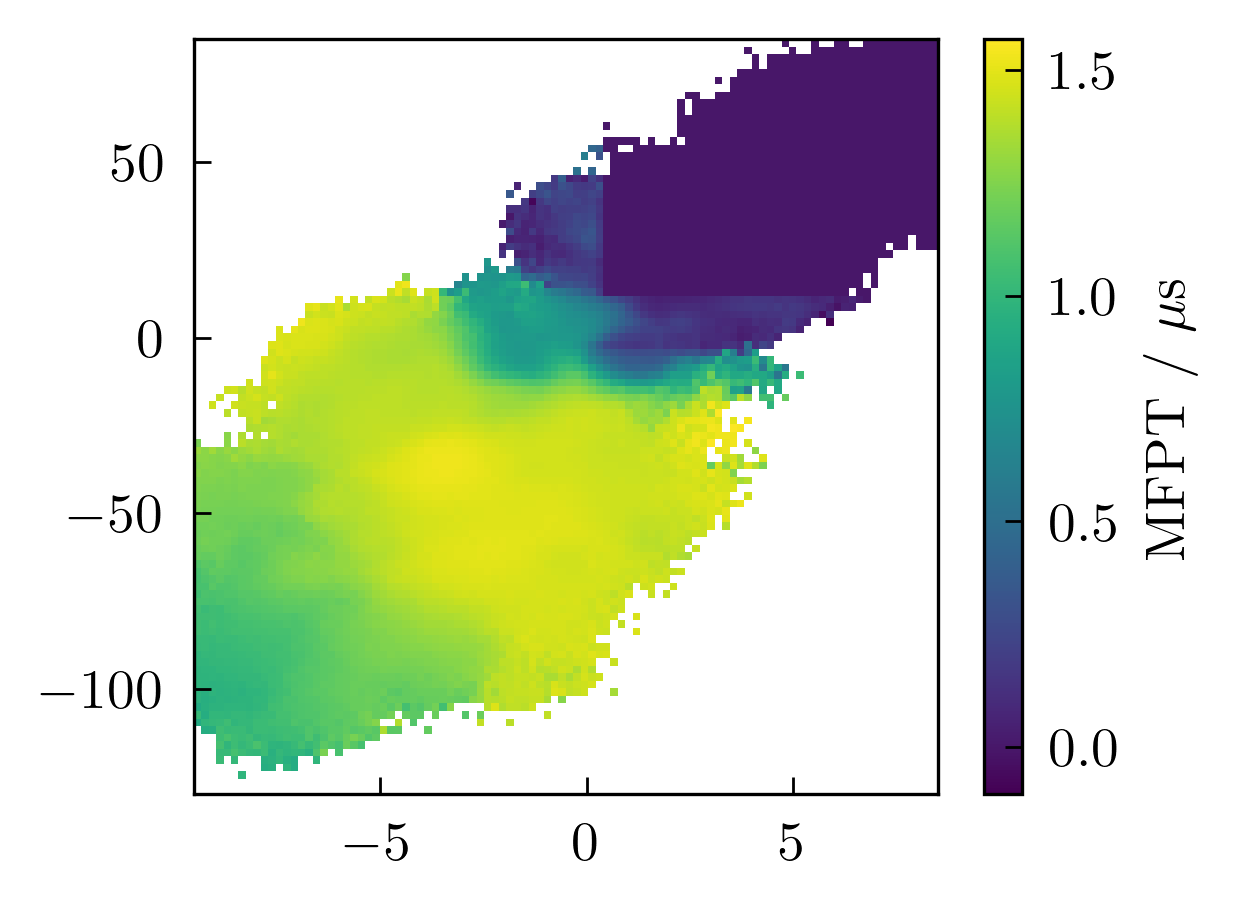

Epoch 22 / 200
Loss: 6.710944e+02 [    0 /  2000]
Loss: 2.072949e+00 [  500 /  2000]
Loss: 1.239334e+00 [ 1000 /  2000]
Loss: 9.619018e-01 [ 1500 /  2000]
Min epoch loss: -1.150312e+00


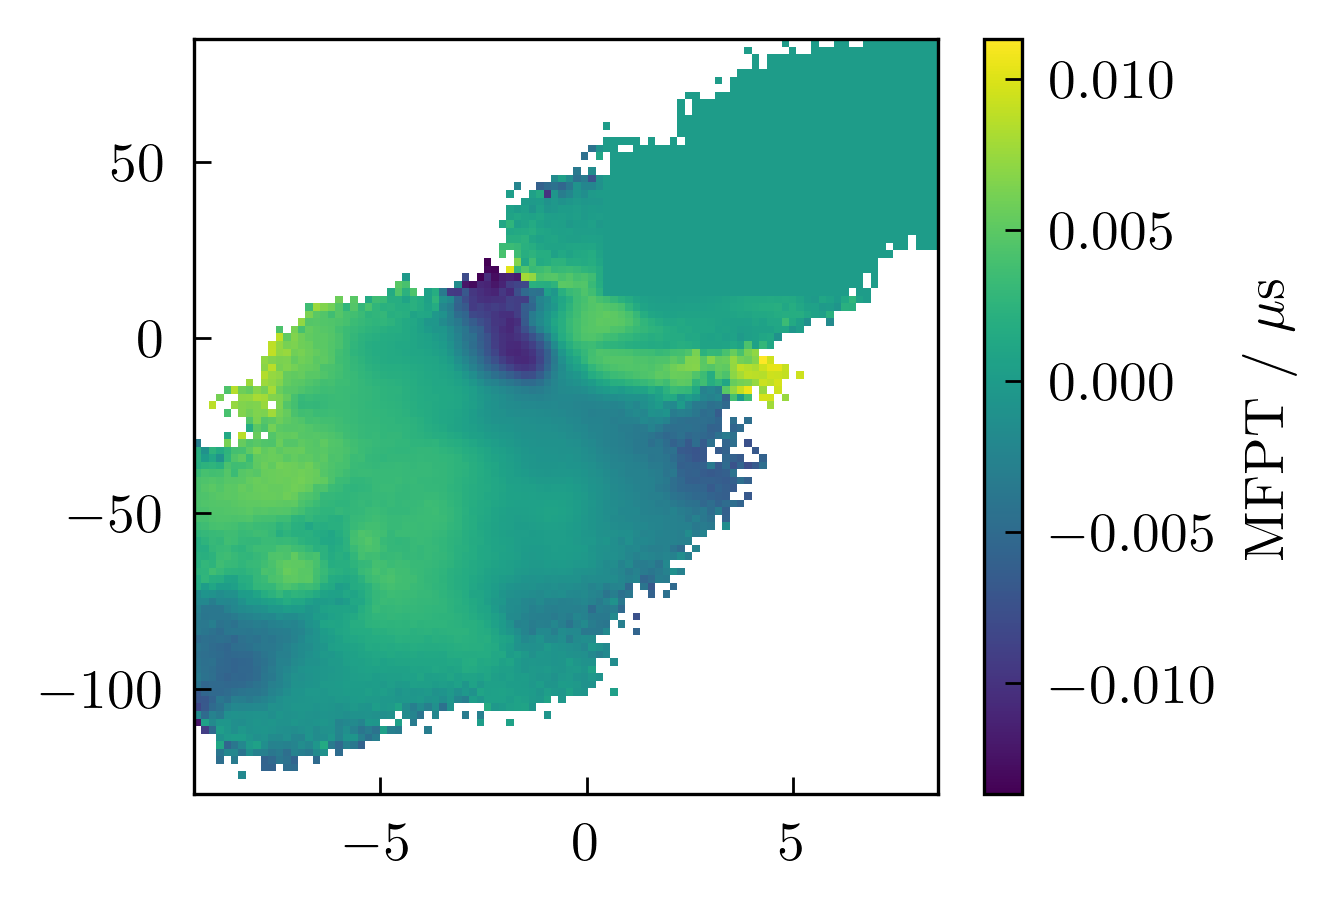

Epoch 23 / 200
Loss: 2.926348e+01 [    0 /  2000]
Loss: -6.430314e+02 [  500 /  2000]
Loss: -6.248176e+02 [ 1000 /  2000]
Loss: -6.534526e+02 [ 1500 /  2000]
Min epoch loss: -6.717509e+02


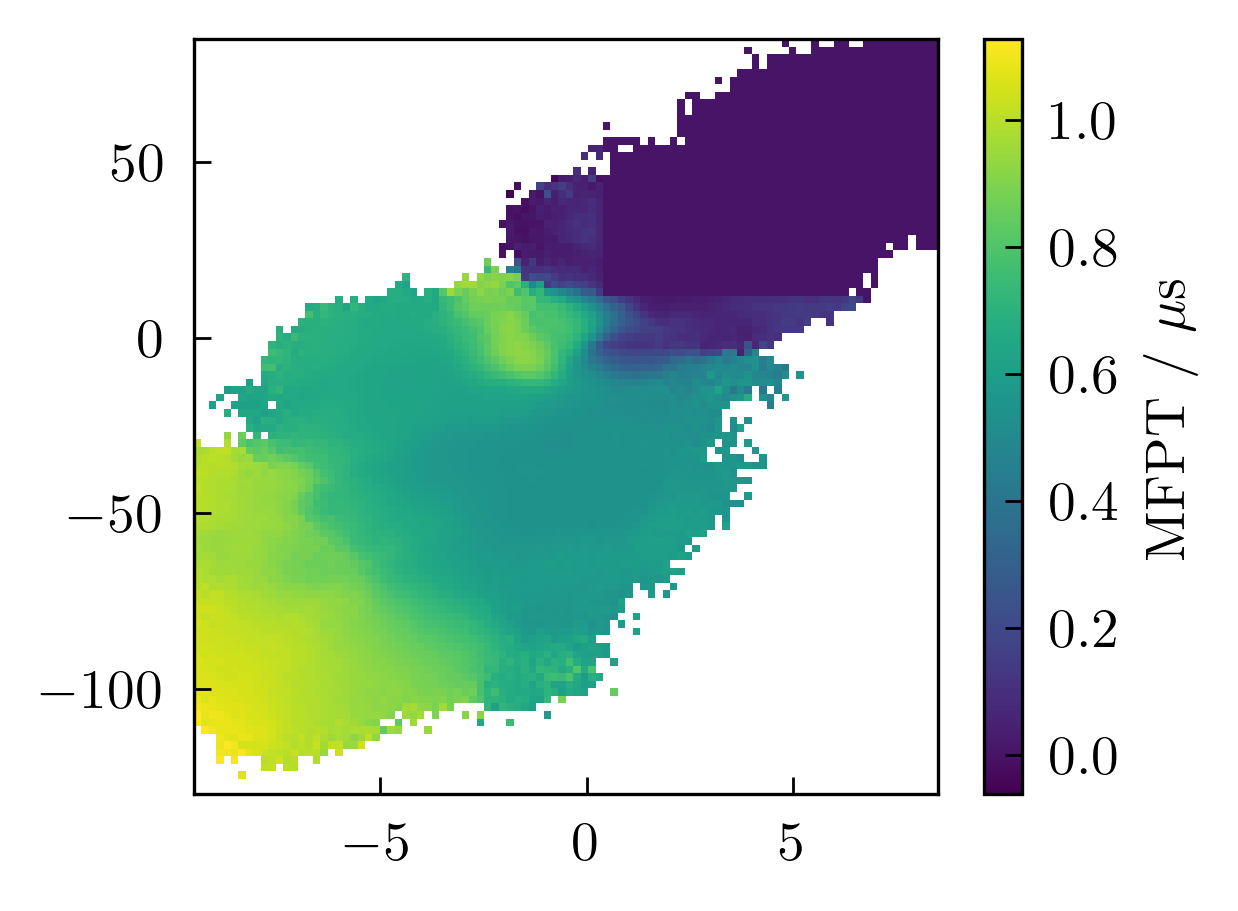

Epoch 24 / 200
Loss: 4.212313e+02 [    0 /  2000]
Loss: -2.607448e+02 [  500 /  2000]
Loss: -2.776032e+02 [ 1000 /  2000]
Loss: -2.621908e+02 [ 1500 /  2000]
Min epoch loss: -2.777293e+02


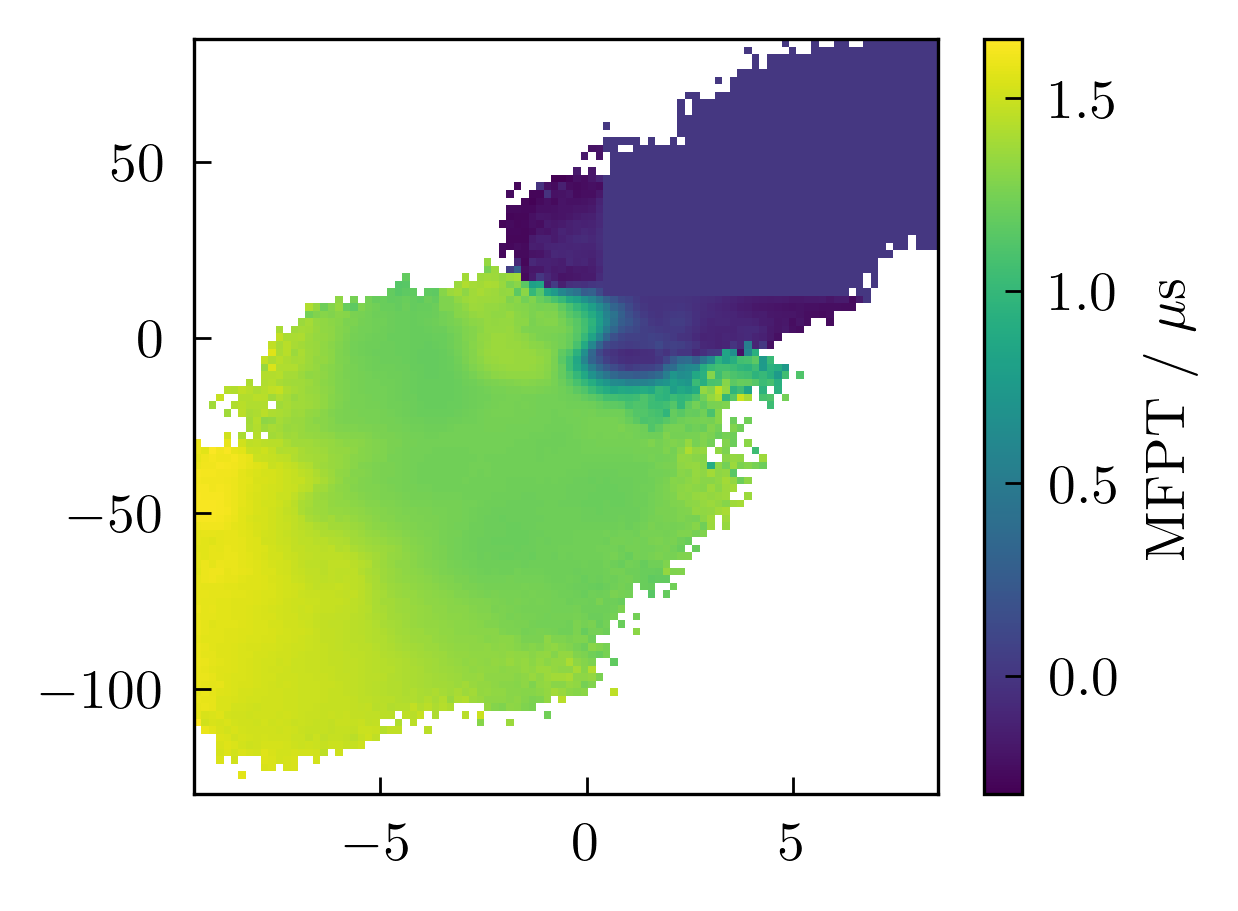

Epoch 25 / 200
Loss: 6.169099e+02 [    0 /  2000]
Loss: -4.431940e+01 [  500 /  2000]
Loss: -4.585651e+01 [ 1000 /  2000]
Loss: -4.946241e+01 [ 1500 /  2000]
Min epoch loss: -5.629266e+01


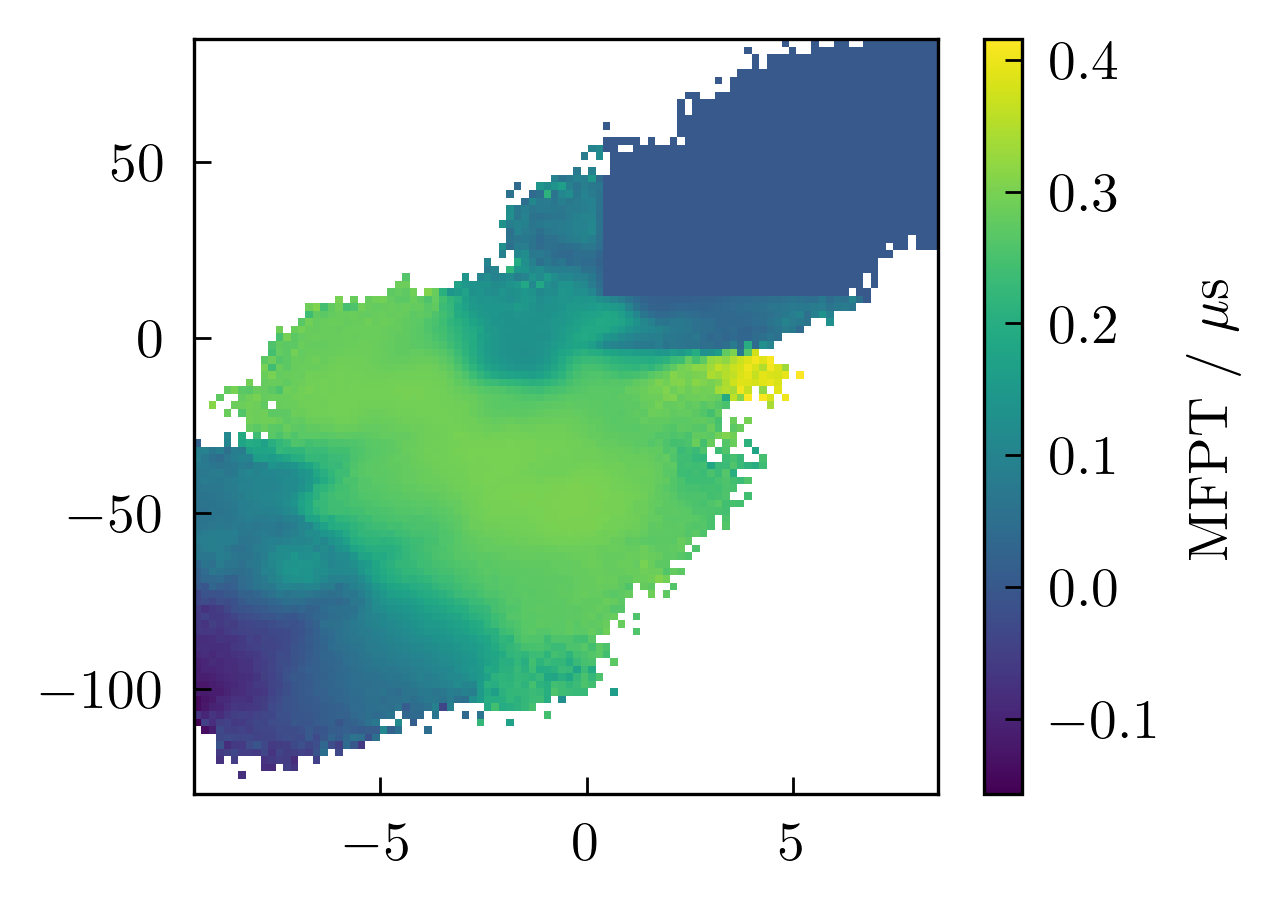

Epoch 26 / 200
Loss: 4.008793e+02 [    0 /  2000]
Loss: -2.560488e+02 [  500 /  2000]
Loss: -2.698417e+02 [ 1000 /  2000]
Loss: -2.666546e+02 [ 1500 /  2000]
Min epoch loss: -2.821961e+02


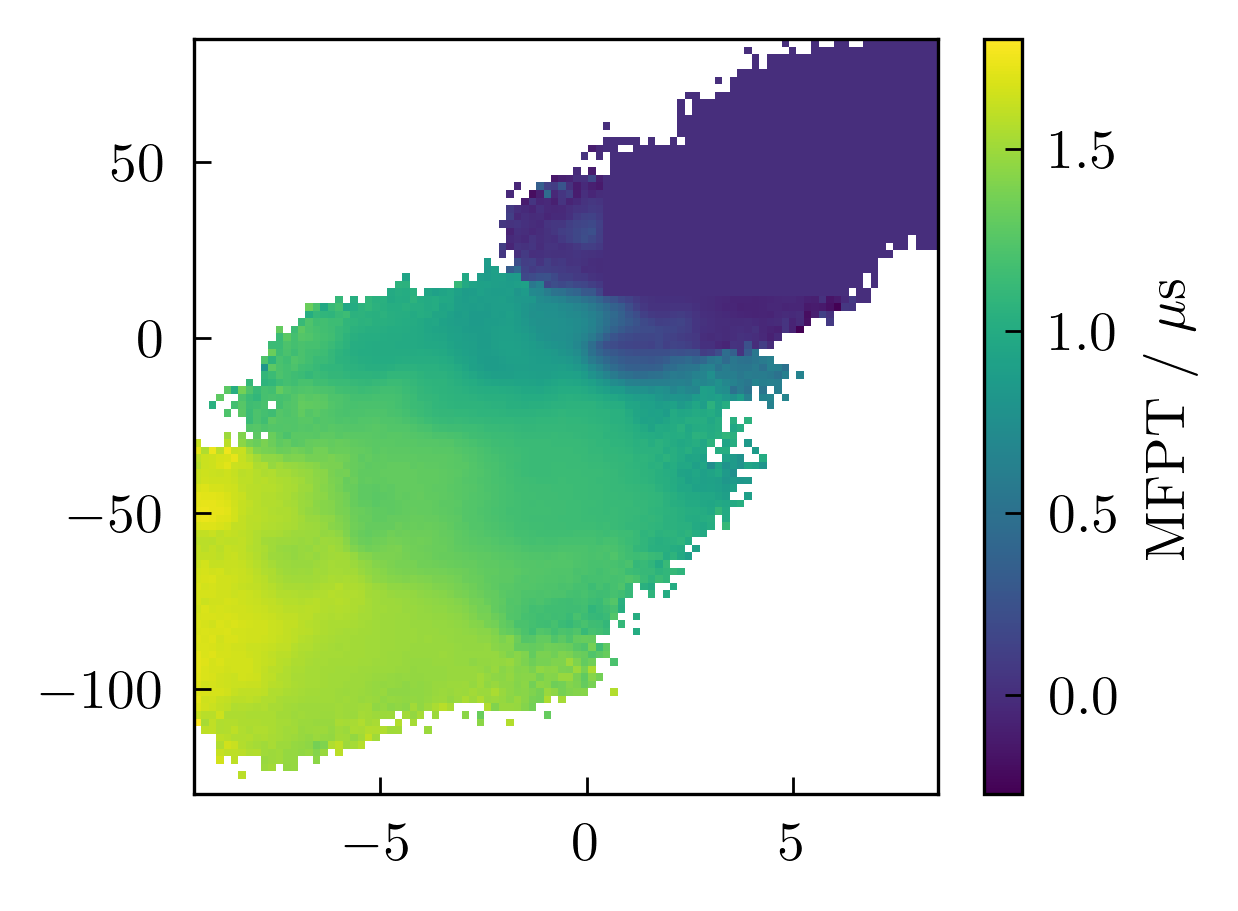

Epoch 27 / 200
Loss: 6.118563e+02 [    0 /  2000]
Loss: -6.437464e+01 [  500 /  2000]
Loss: -6.827573e+01 [ 1000 /  2000]
Loss: -6.772977e+01 [ 1500 /  2000]
Min epoch loss: -7.161526e+01


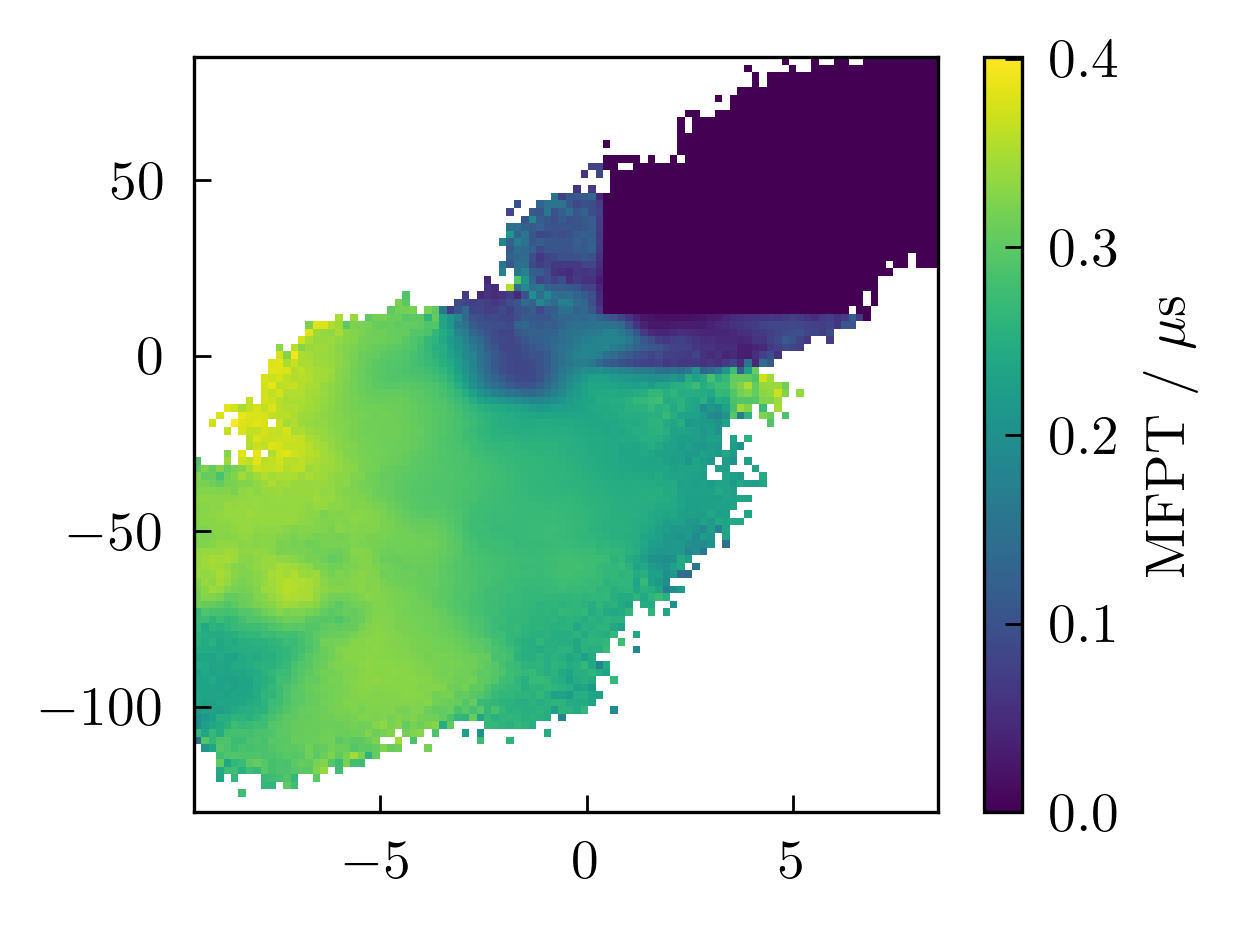

Epoch 28 / 200
Loss: 3.737151e+02 [    0 /  2000]
Loss: -2.849598e+02 [  500 /  2000]
Loss: -2.856957e+02 [ 1000 /  2000]
Loss: -2.871047e+02 [ 1500 /  2000]
Min epoch loss: -3.035623e+02


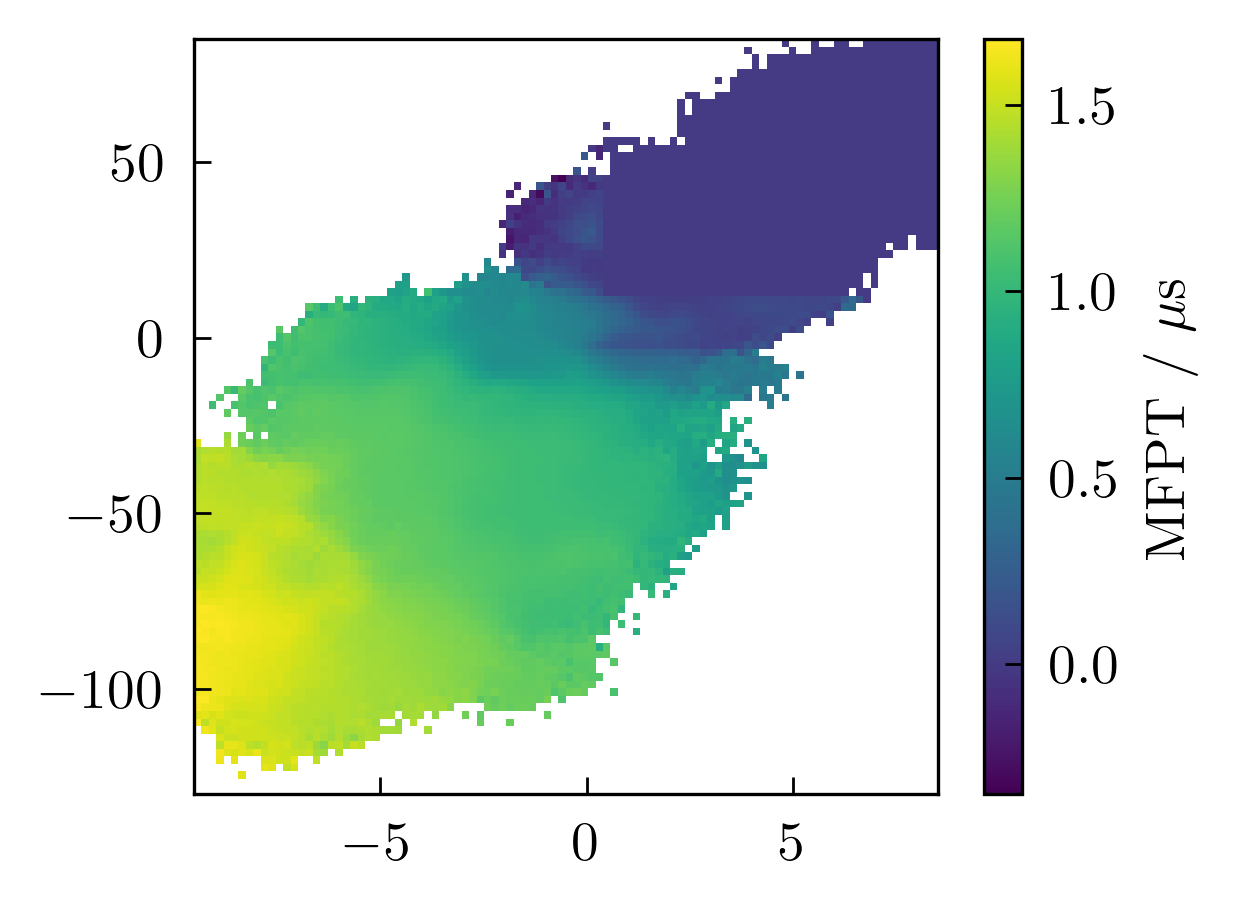

Epoch 29 / 200
Loss: 6.419308e+02 [    0 /  2000]
Loss: -3.556459e+01 [  500 /  2000]
Loss: -3.475760e+01 [ 1000 /  2000]
Loss: -3.579805e+01 [ 1500 /  2000]
Min epoch loss: -3.943979e+01


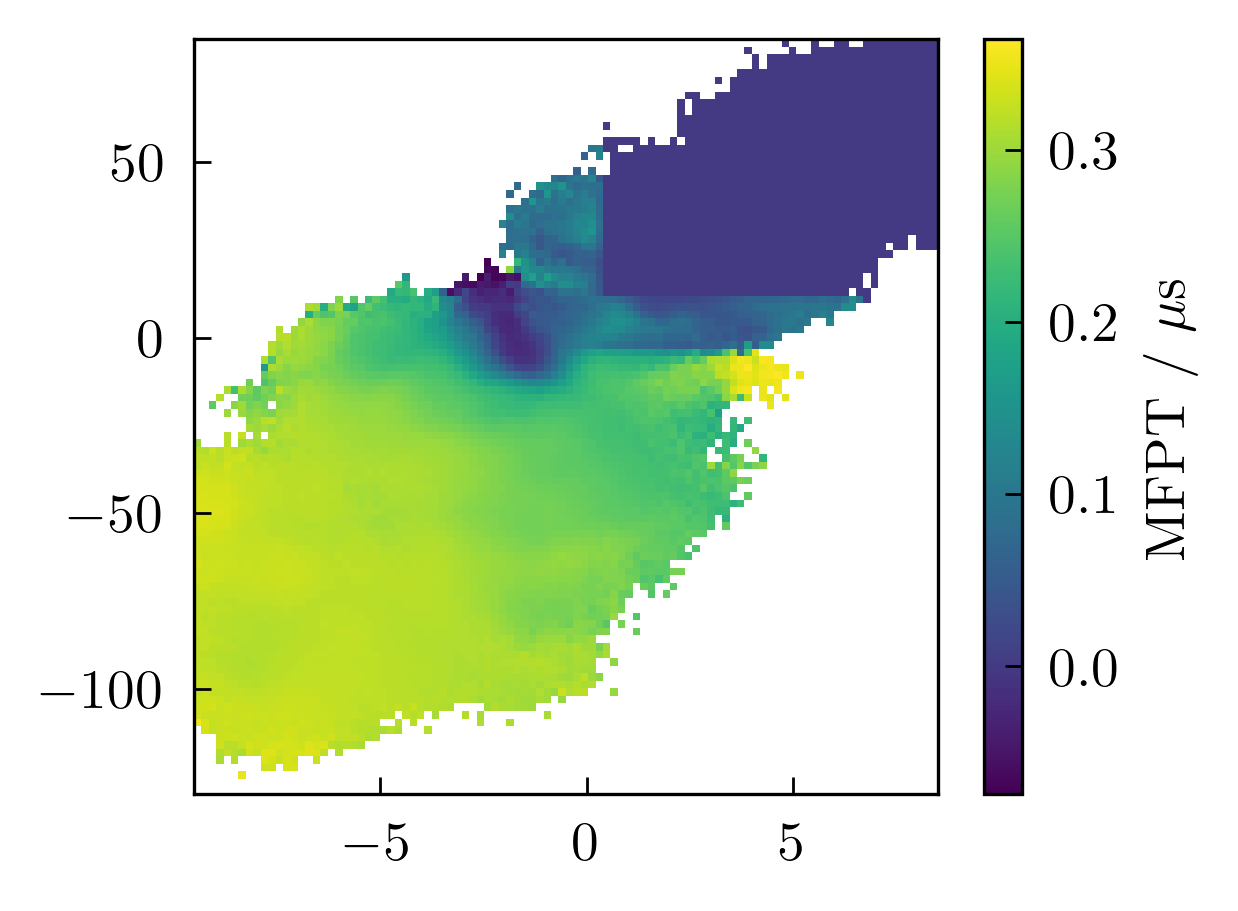

Epoch 30 / 200
Loss: 3.940604e+02 [    0 /  2000]
Loss: -2.618210e+02 [  500 /  2000]
Loss: -2.750453e+02 [ 1000 /  2000]
Loss: -2.637412e+02 [ 1500 /  2000]
Min epoch loss: -2.927185e+02


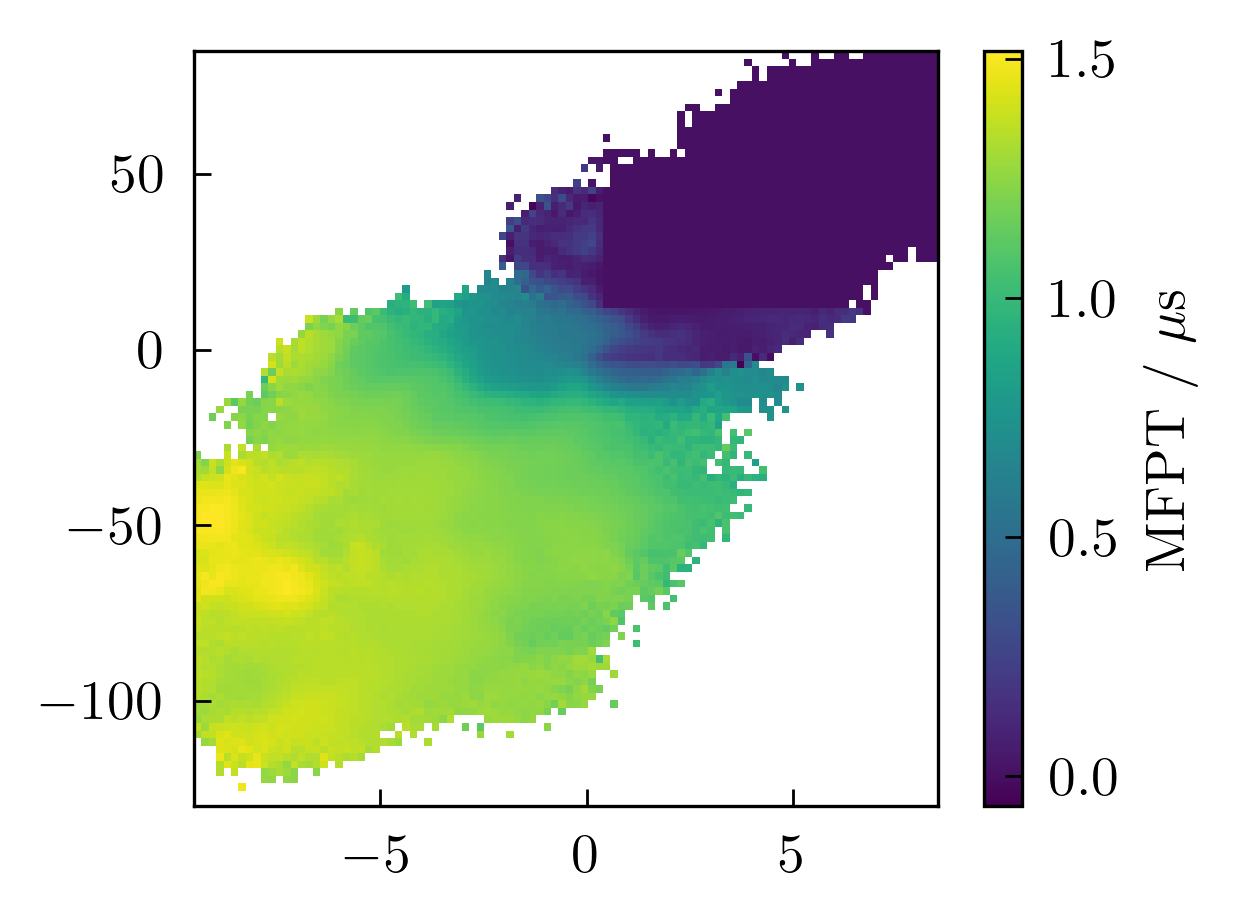

Epoch 31 / 200
Loss: 6.250430e+02 [    0 /  2000]
Loss: -2.827925e+01 [  500 /  2000]
Loss: -3.066754e+01 [ 1000 /  2000]
Loss: -3.092980e+01 [ 1500 /  2000]
Min epoch loss: -3.475213e+01


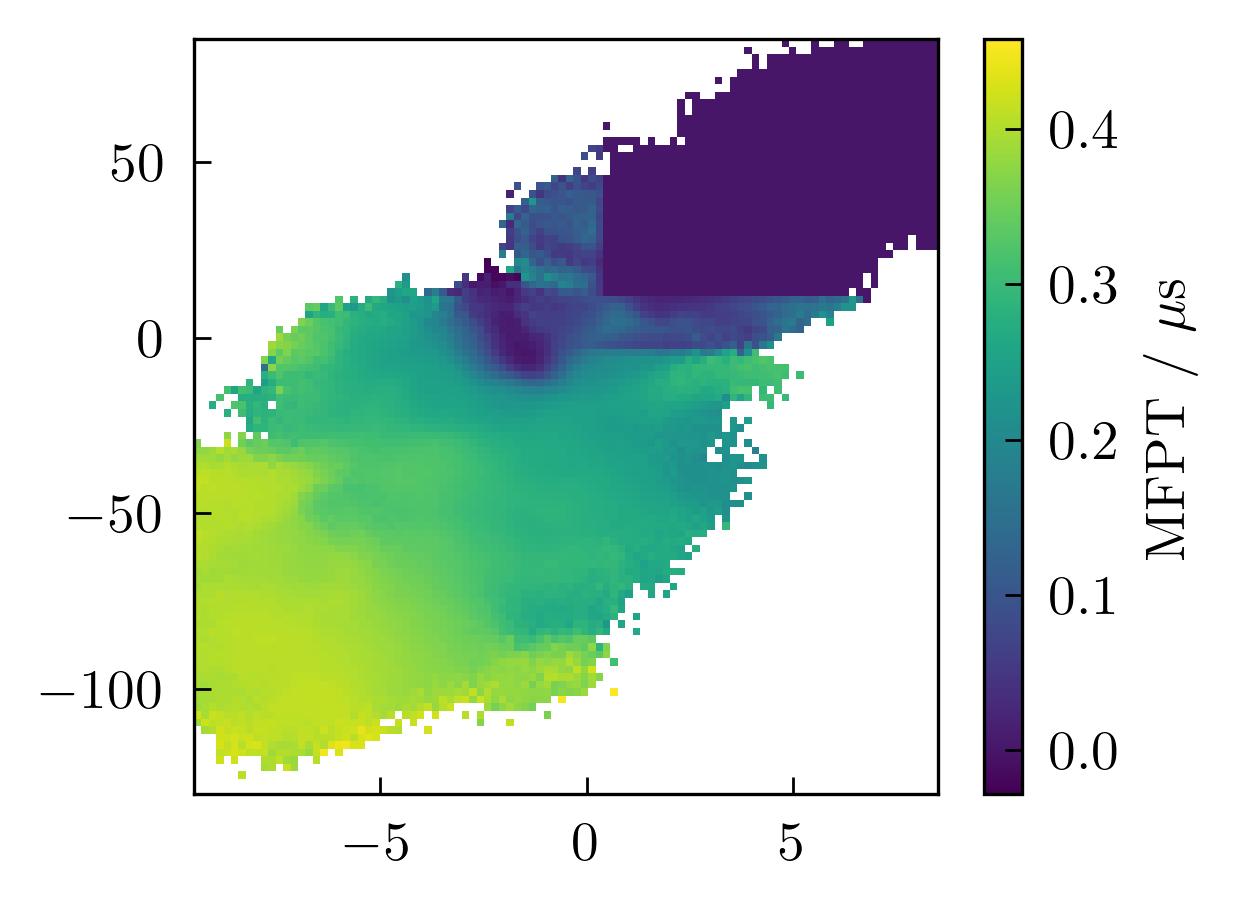

Epoch 32 / 200
Loss: 3.654848e+02 [    0 /  2000]
Loss: -3.011753e+02 [  500 /  2000]
Loss: -2.917794e+02 [ 1000 /  2000]
Loss: -2.990103e+02 [ 1500 /  2000]
Min epoch loss: -3.120264e+02


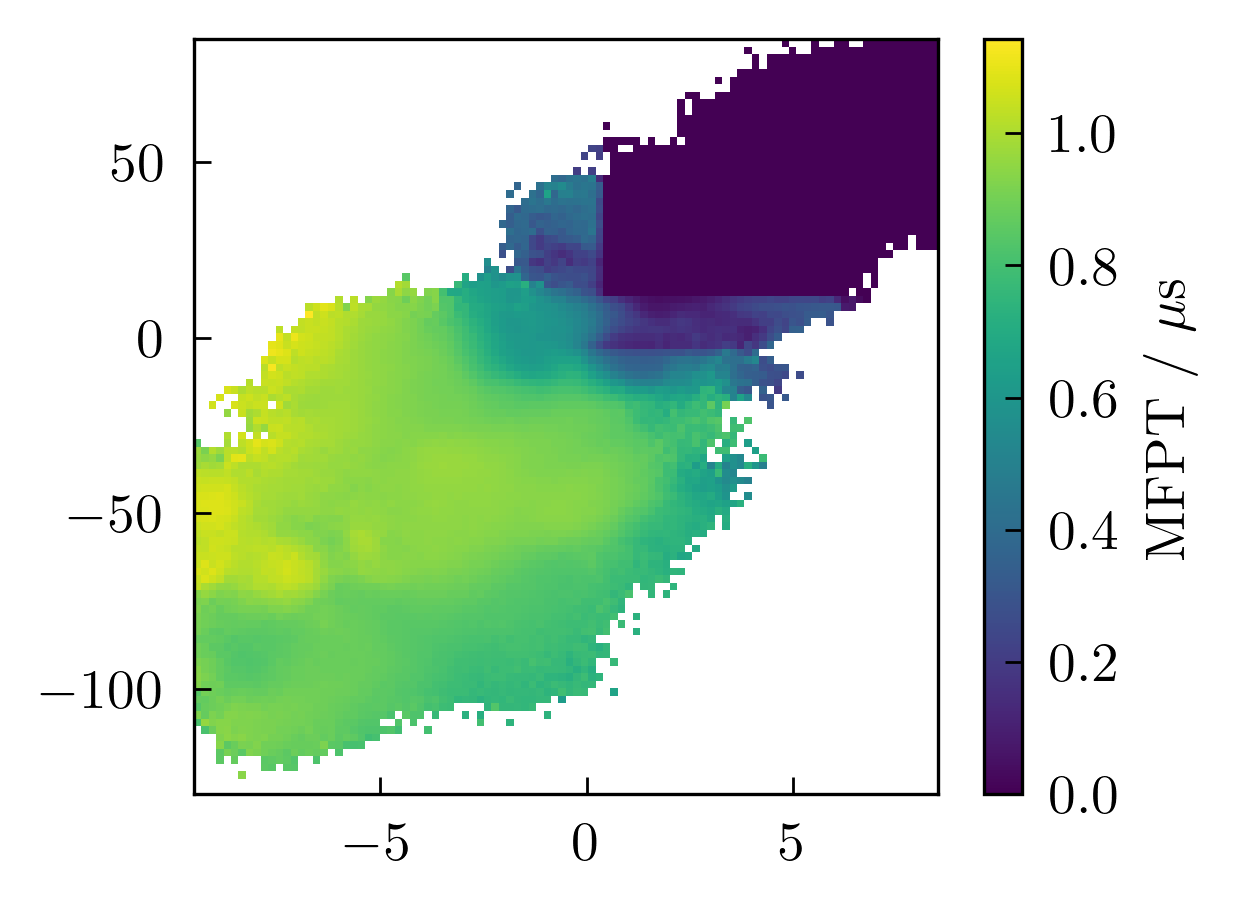

Epoch 33 / 200
Loss: 6.629808e+02 [    0 /  2000]
Loss: -7.697908e-01 [  500 /  2000]
Loss: -6.051413e-01 [ 1000 /  2000]
Loss: -3.936663e+00 [ 1500 /  2000]
Min epoch loss: -5.923232e+00


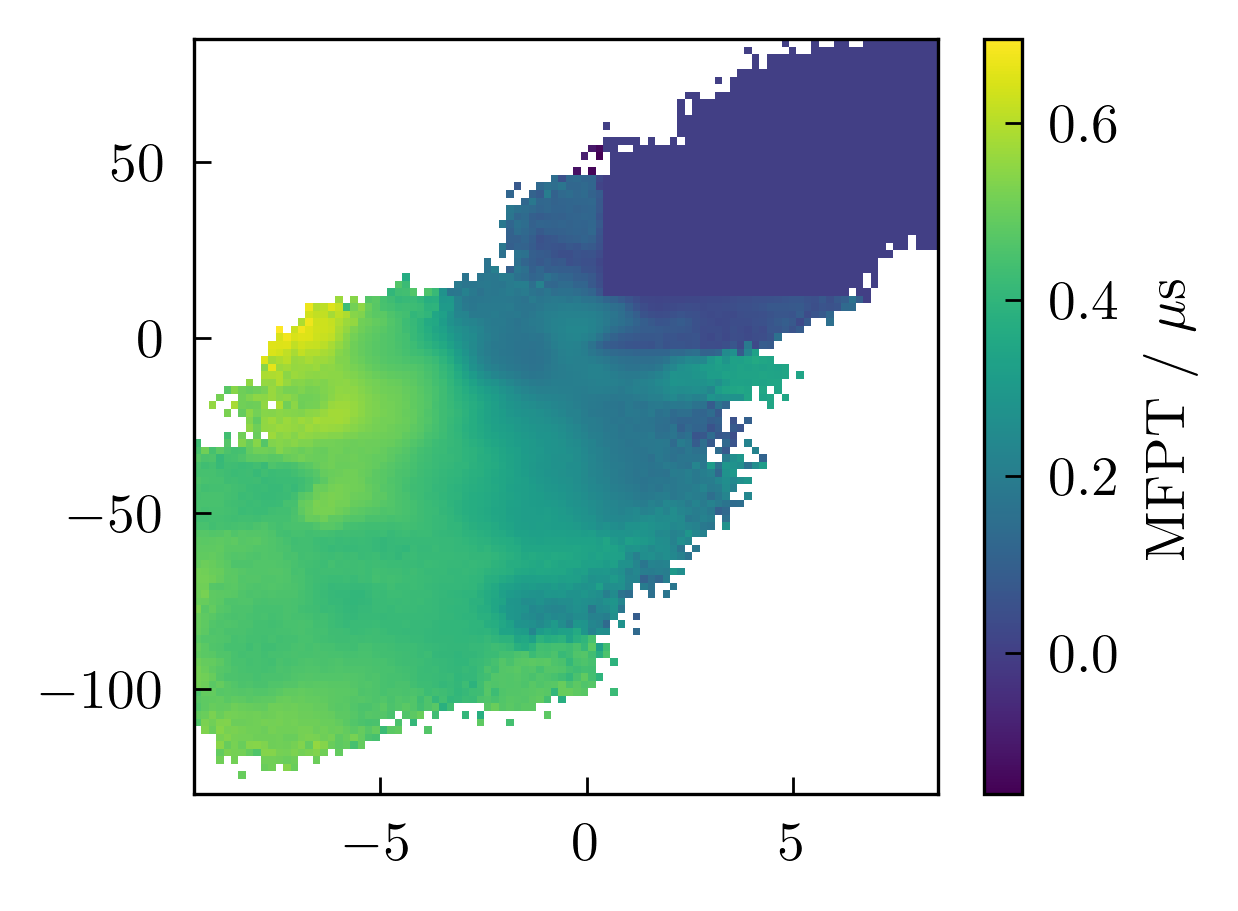

Epoch 34 / 200
Loss: 3.384711e+02 [    0 /  2000]
Loss: -3.235502e+02 [  500 /  2000]
Loss: -3.281996e+02 [ 1000 /  2000]
Loss: -3.272705e+02 [ 1500 /  2000]
Min epoch loss: -3.332115e+02


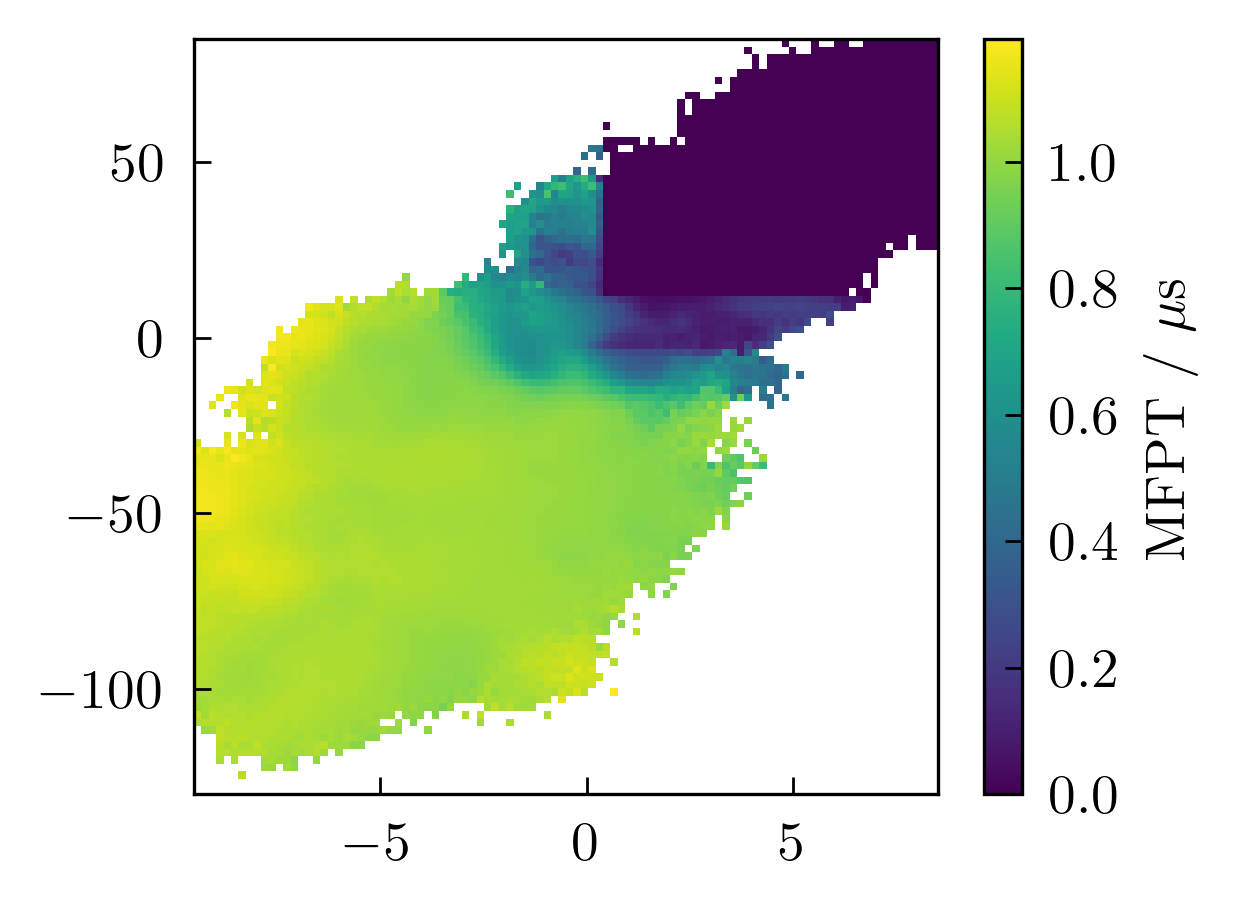

Epoch 35 / 200
Loss: 8.440359e+02 [    0 /  2000]
Loss: 1.732035e+02 [  500 /  2000]
Loss: 1.692885e+02 [ 1000 /  2000]
Loss: 1.701273e+02 [ 1500 /  2000]
Min epoch loss: 1.652725e+02


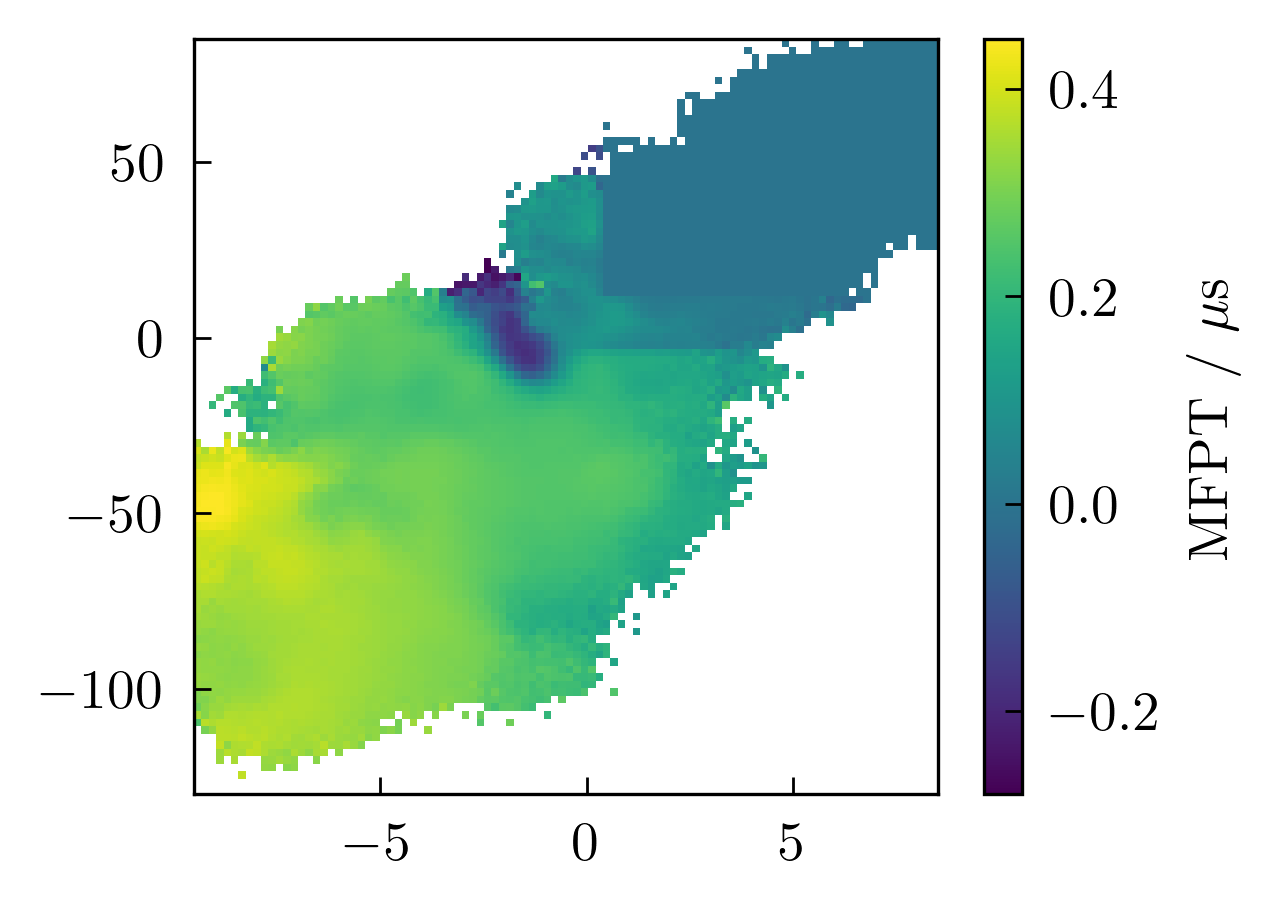

Epoch 36 / 200
Loss: 6.486407e+02 [    0 /  2000]
Loss: 5.621625e+00 [  500 /  2000]
Loss: -5.443524e+00 [ 1000 /  2000]
Loss: -1.857156e+01 [ 1500 /  2000]
Min epoch loss: -2.691942e+01


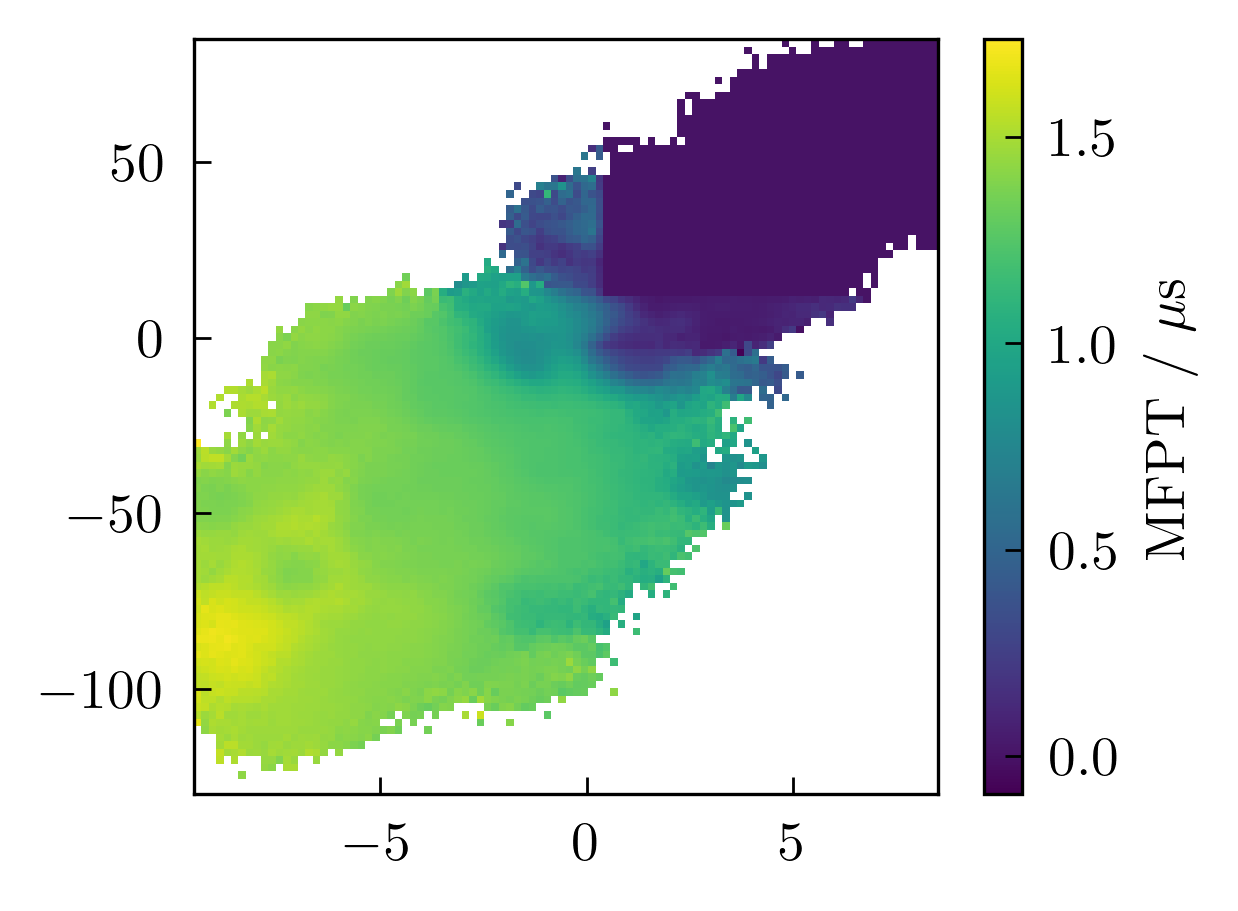

Epoch 37 / 200
Loss: 1.031640e+03 [    0 /  2000]
Loss: 3.582043e+02 [  500 /  2000]
Loss: 3.609413e+02 [ 1000 /  2000]
Loss: 3.600240e+02 [ 1500 /  2000]
Min epoch loss: 3.545296e+02


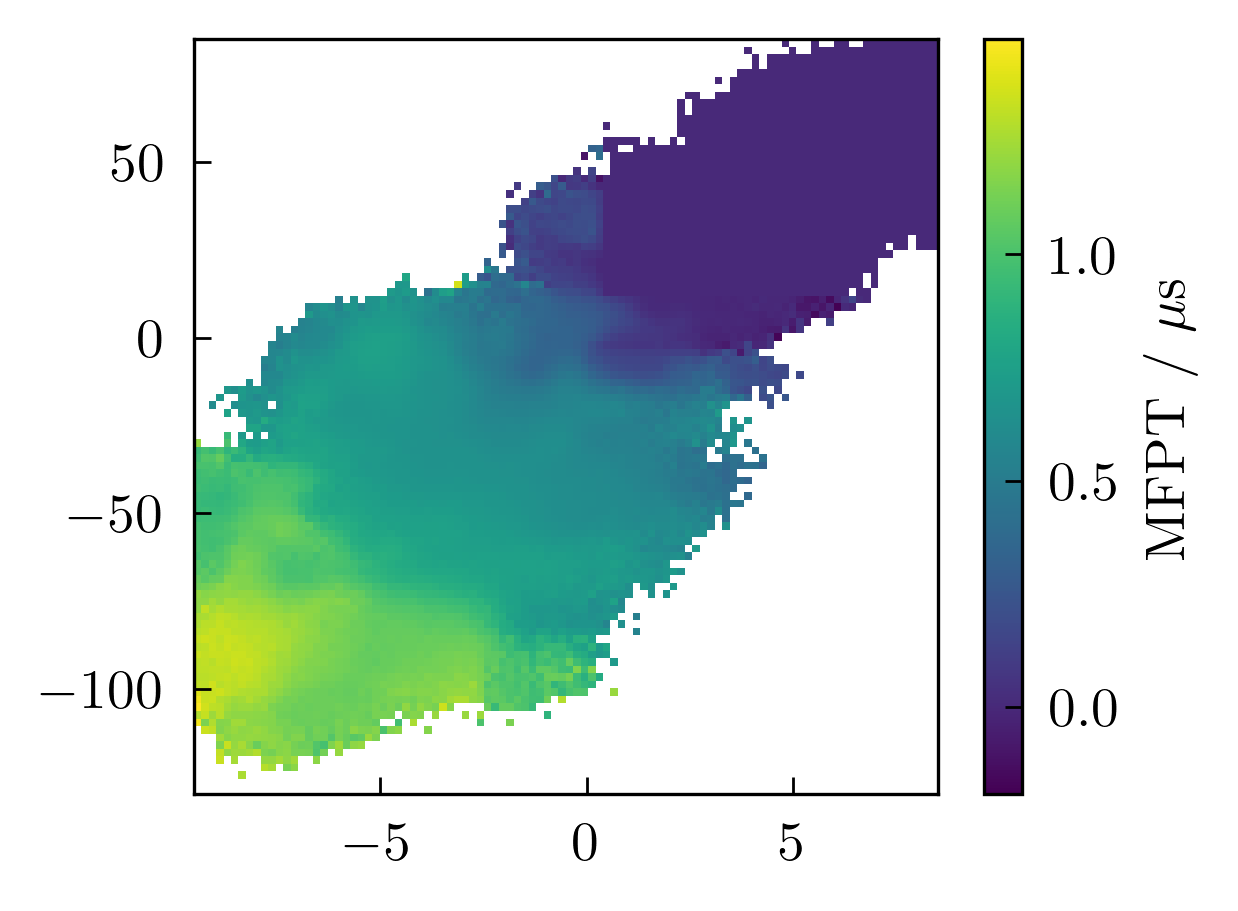

Epoch 38 / 200
Loss: 7.669609e+02 [    0 /  2000]
Loss: 1.178716e+02 [  500 /  2000]
Loss: 1.172199e+02 [ 1000 /  2000]
Loss: 1.141570e+02 [ 1500 /  2000]
Min epoch loss: 9.099233e+01


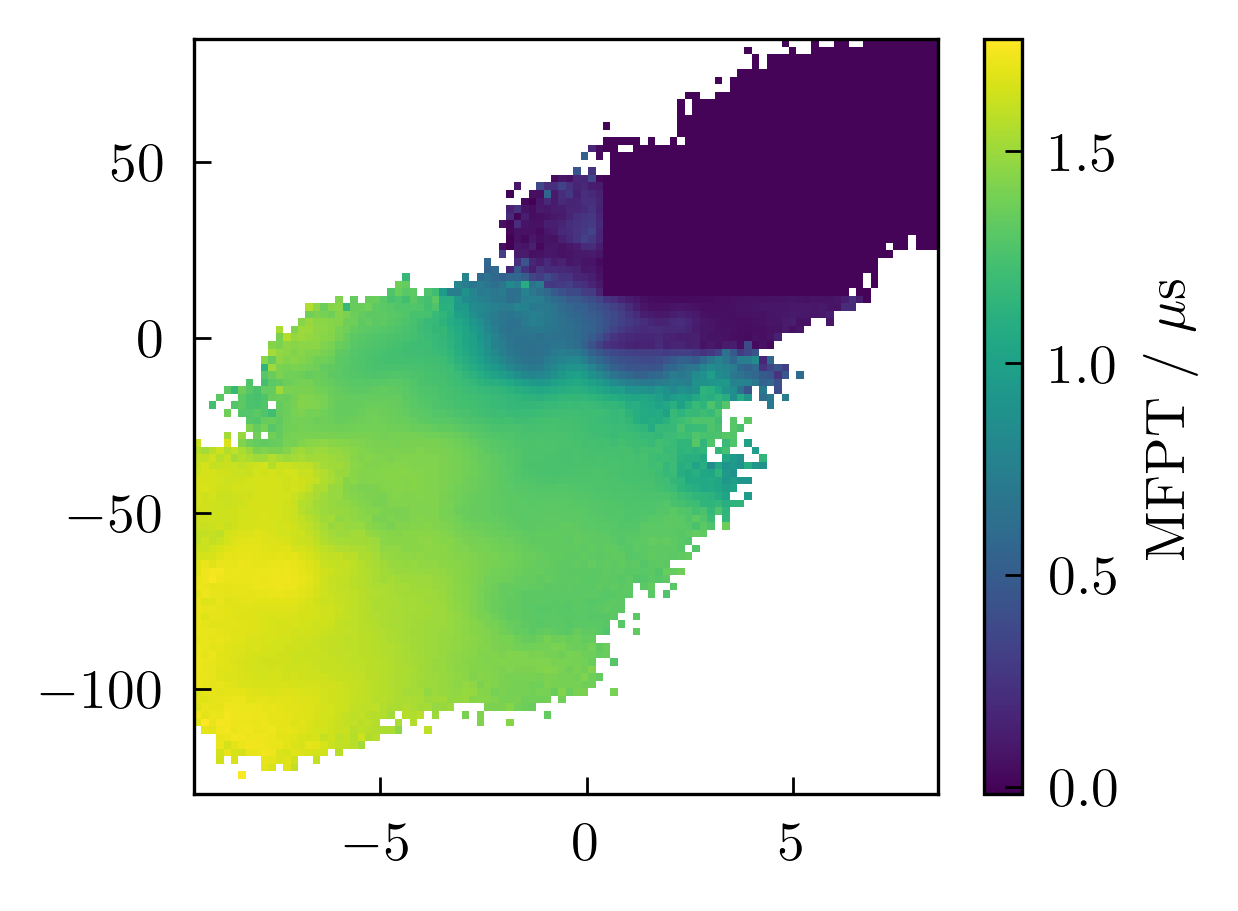

Epoch 39 / 200
Loss: 1.386455e+03 [    0 /  2000]
Loss: 7.324930e+02 [  500 /  2000]
Loss: 7.294756e+02 [ 1000 /  2000]
Loss: 7.286313e+02 [ 1500 /  2000]
Min epoch loss: 7.235372e+02


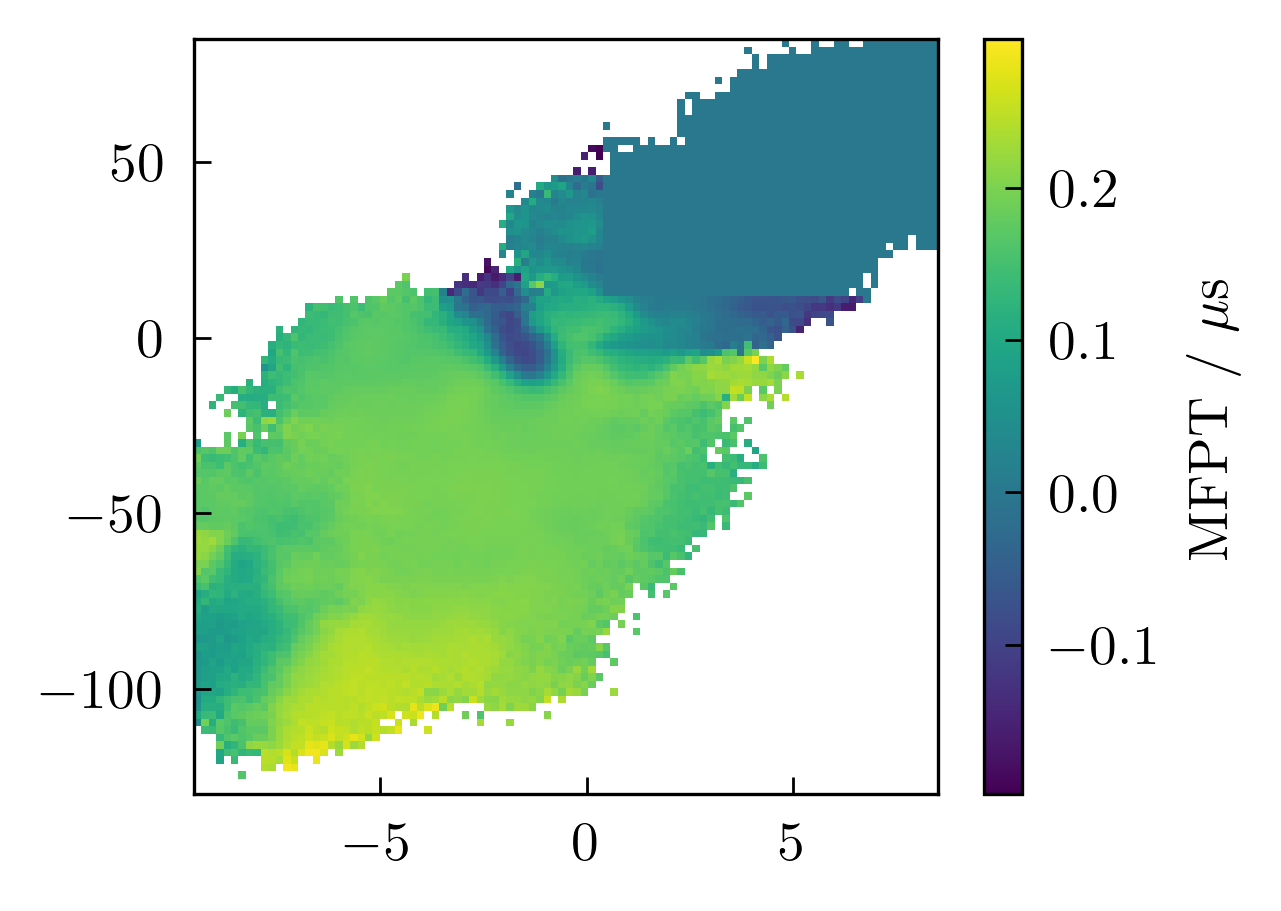

Epoch 40 / 200
Loss: 1.439345e+03 [    0 /  2000]
Loss: 7.776533e+02 [  500 /  2000]
Loss: 7.741122e+02 [ 1000 /  2000]
Loss: 7.810599e+02 [ 1500 /  2000]
Min epoch loss: 7.557833e+02


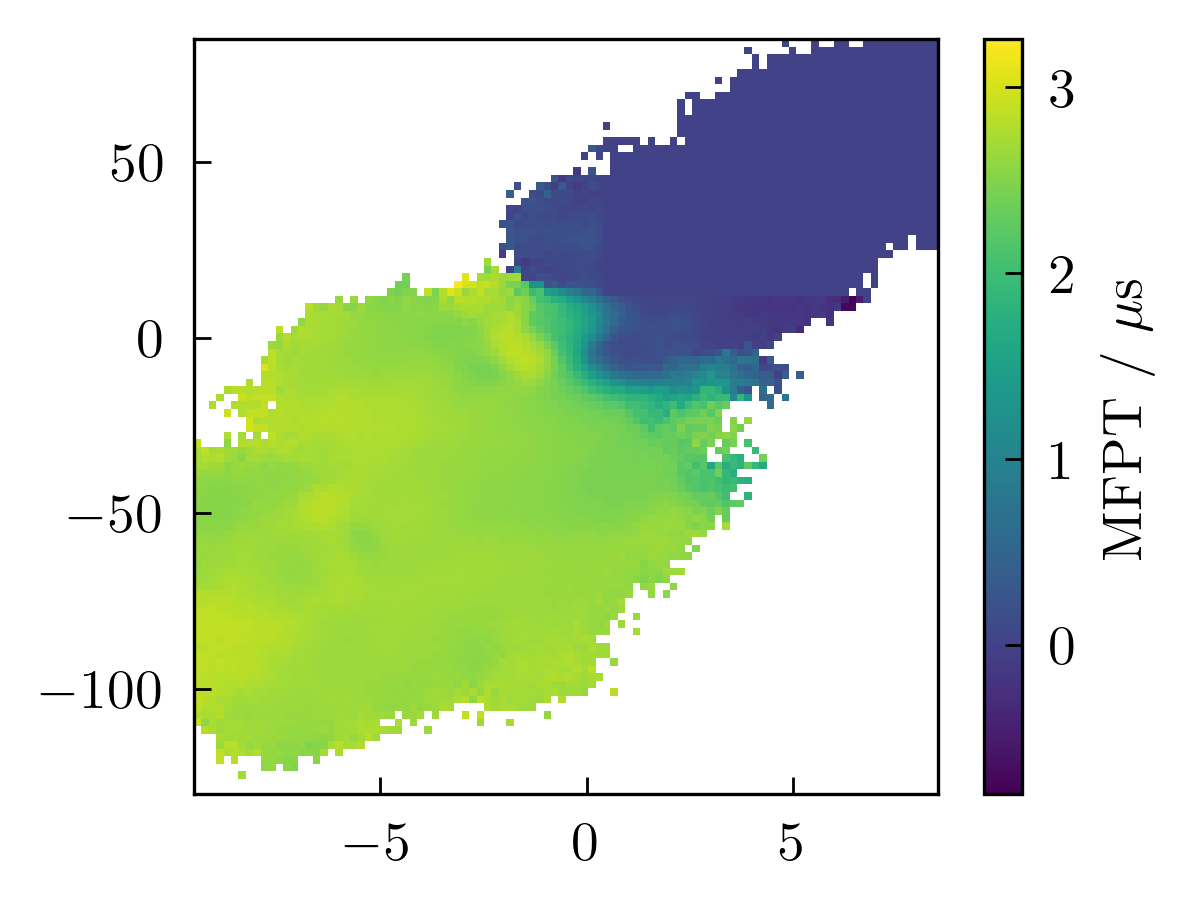

Epoch 41 / 200
Loss: 7.318975e+03 [    0 /  2000]
Loss: 6.658783e+03 [  500 /  2000]
Loss: 6.648326e+03 [ 1000 /  2000]
Loss: 6.646653e+03 [ 1500 /  2000]
Min epoch loss: 6.635378e+03


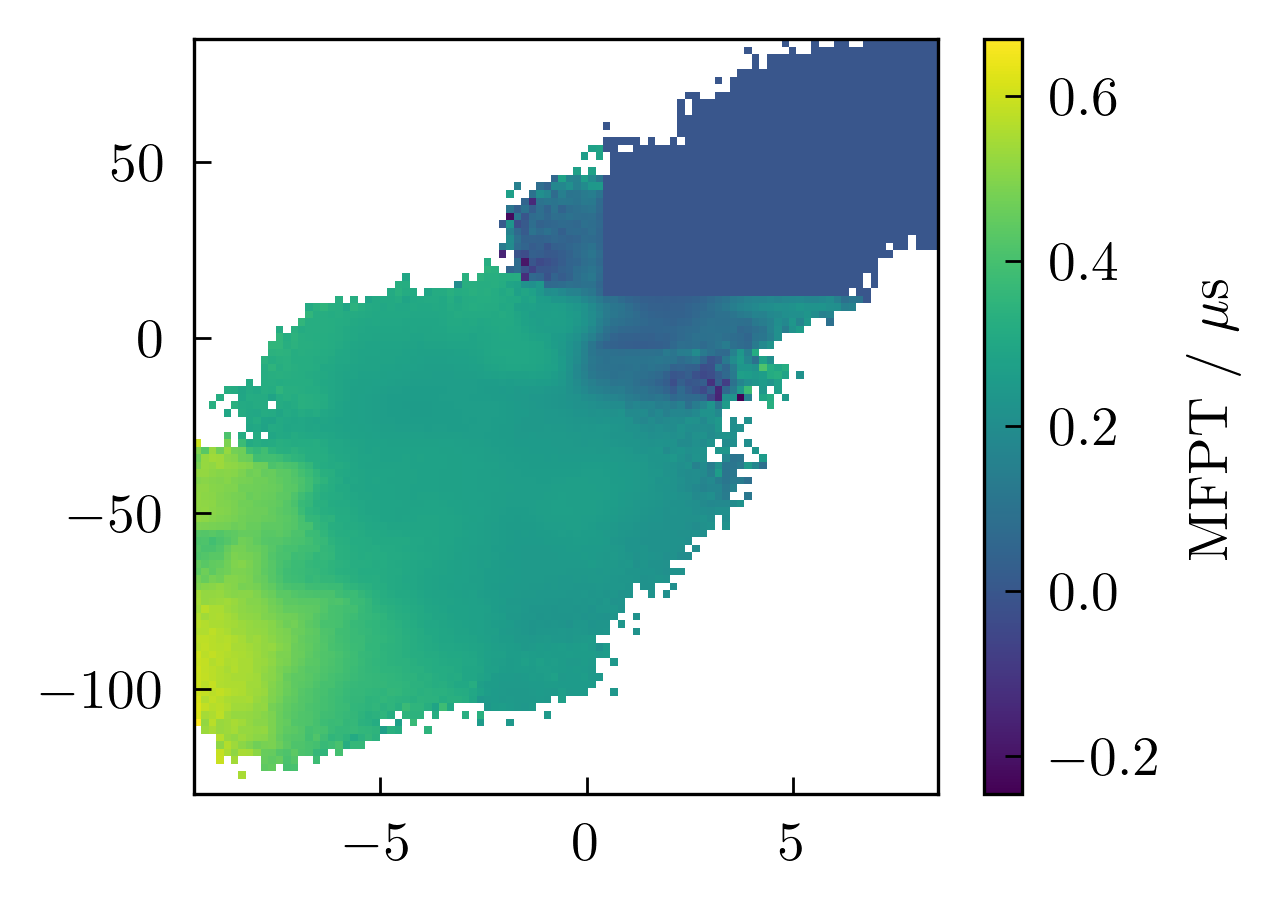

Epoch 42 / 200
Loss: 2.335882e+03 [    0 /  2000]
Loss: 1.706125e+03 [  500 /  2000]
Loss: 1.695026e+03 [ 1000 /  2000]
Loss: 1.678800e+03 [ 1500 /  2000]
Min epoch loss: 1.660352e+03


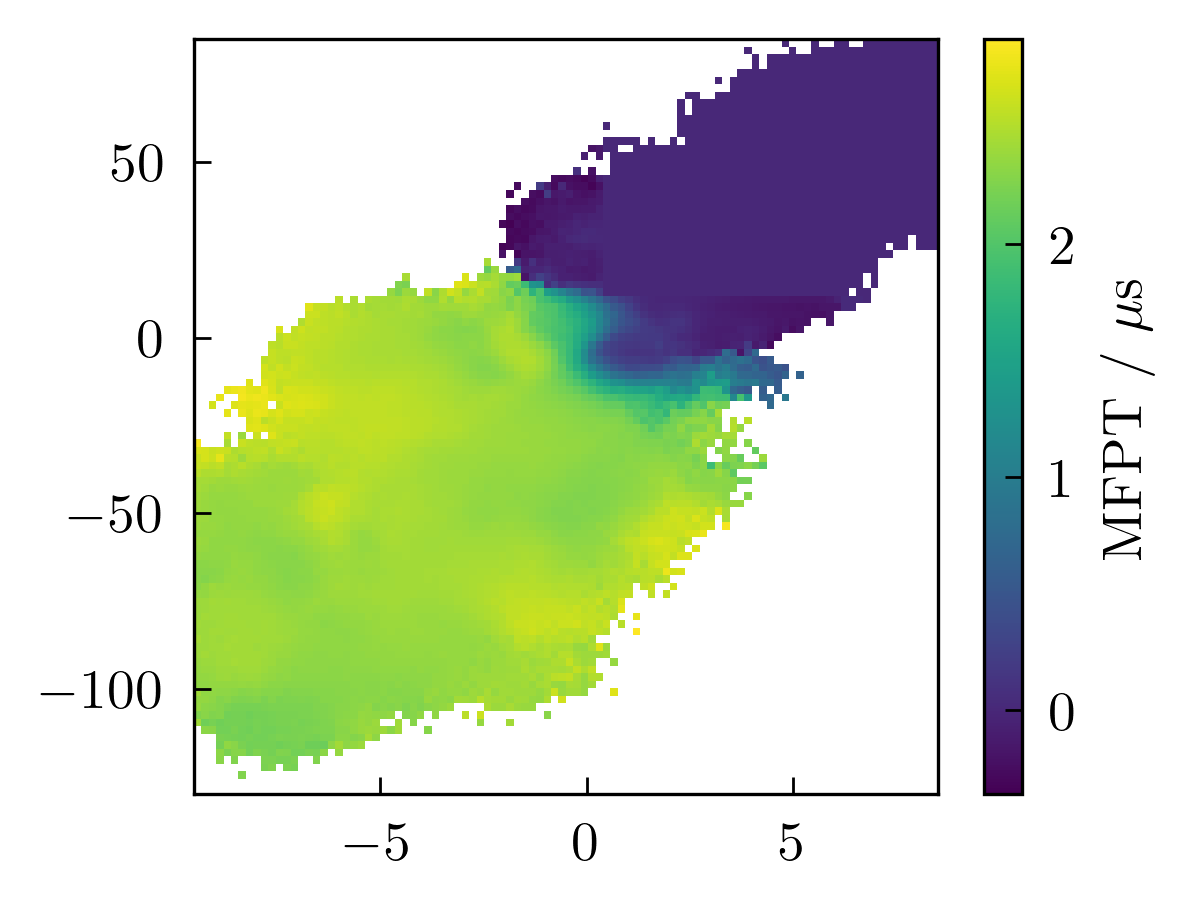

Epoch 43 / 200
Loss: 1.522239e+03 [    0 /  2000]
Loss: 8.549380e+02 [  500 /  2000]
Loss: 8.542071e+02 [ 1000 /  2000]
Loss: 8.517133e+02 [ 1500 /  2000]
Min epoch loss: 8.497043e+02


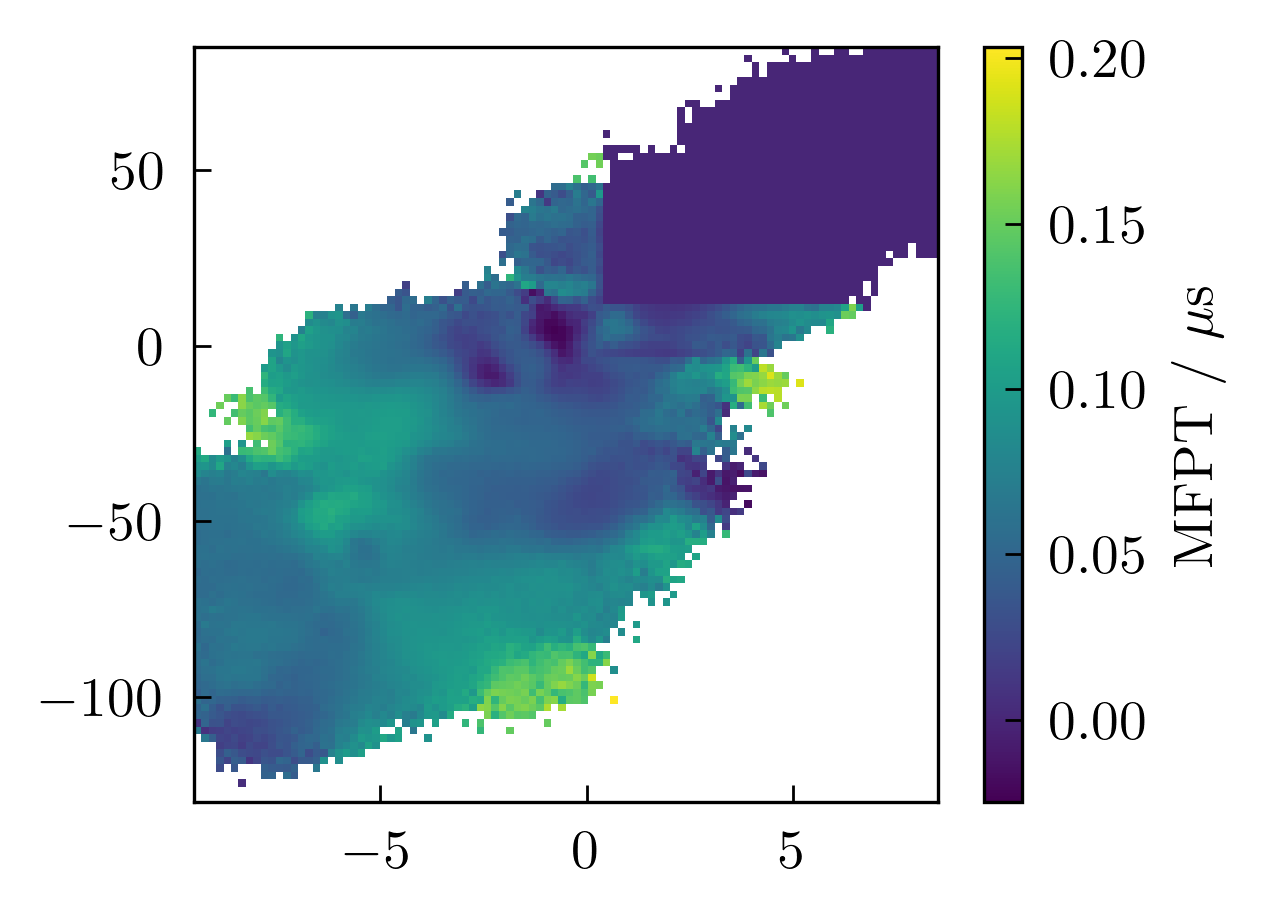

Epoch 44 / 200
Loss: 2.111276e+02 [    0 /  2000]
Loss: 1.330958e+02 [  500 /  2000]
Loss: 1.333345e+02 [ 1000 /  2000]
Loss: 1.335609e+02 [ 1500 /  2000]
Min epoch loss: 1.329496e+02


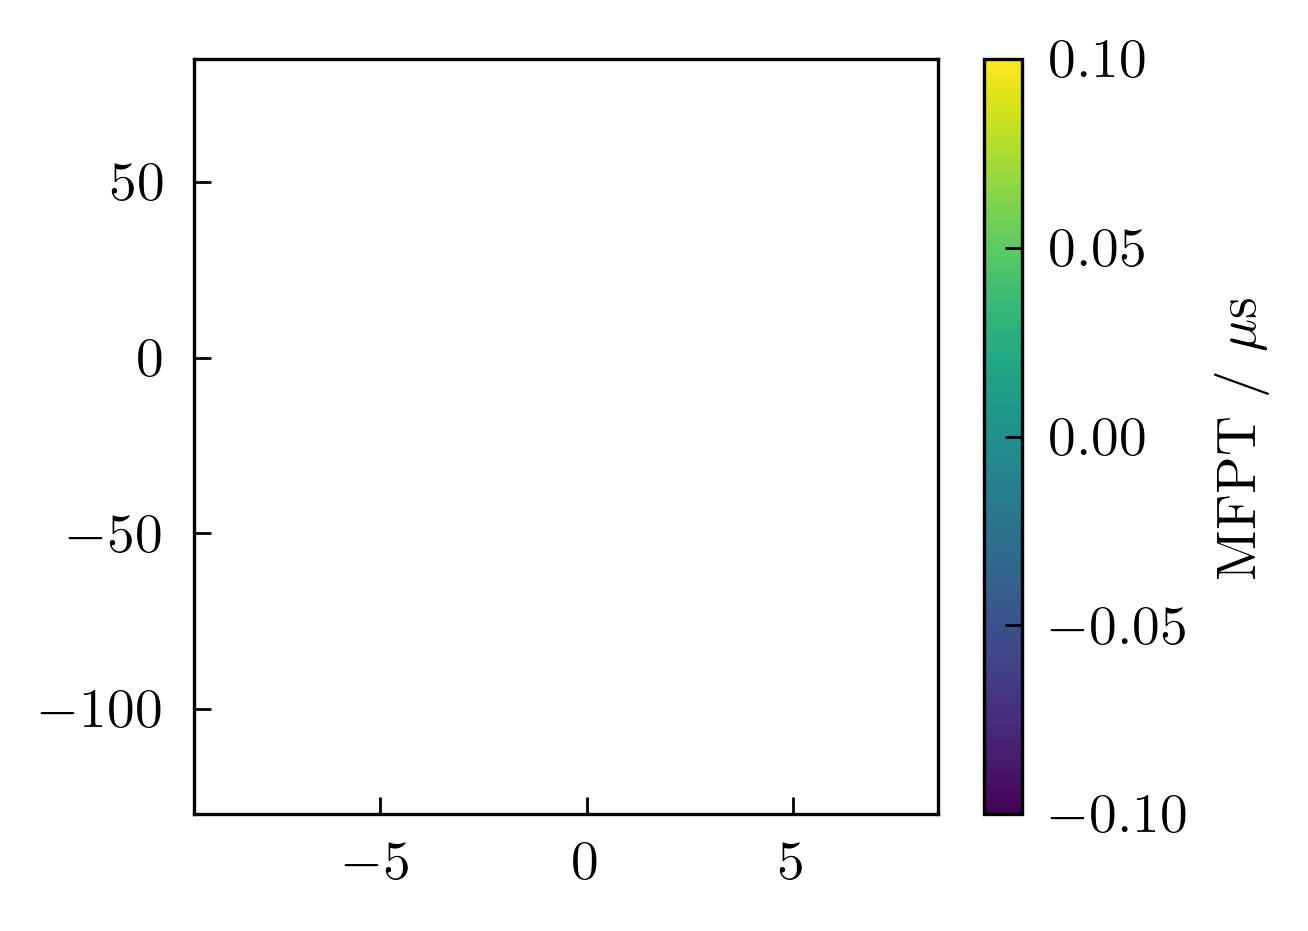

Epoch 45 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


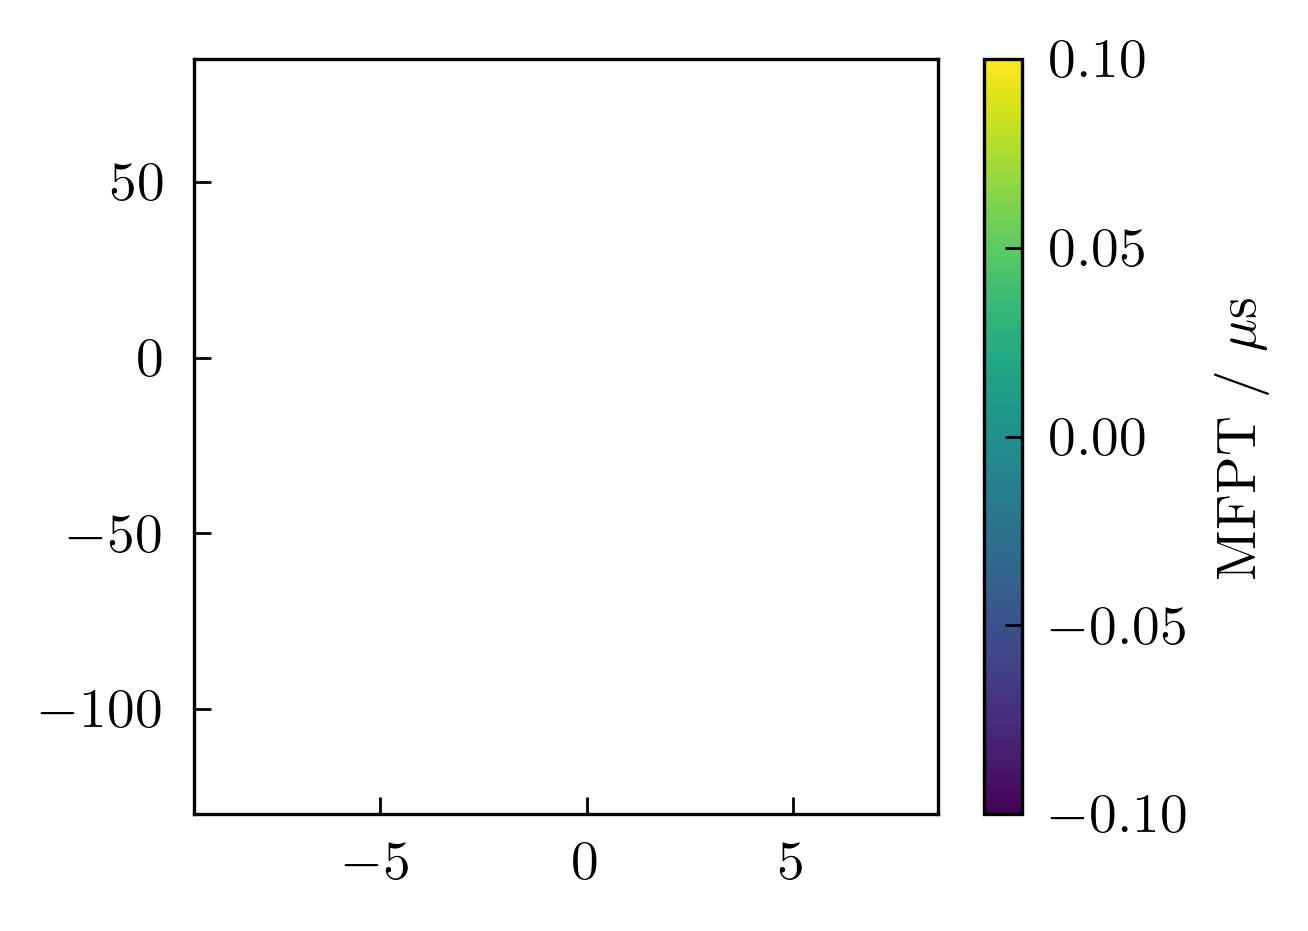

Epoch 46 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


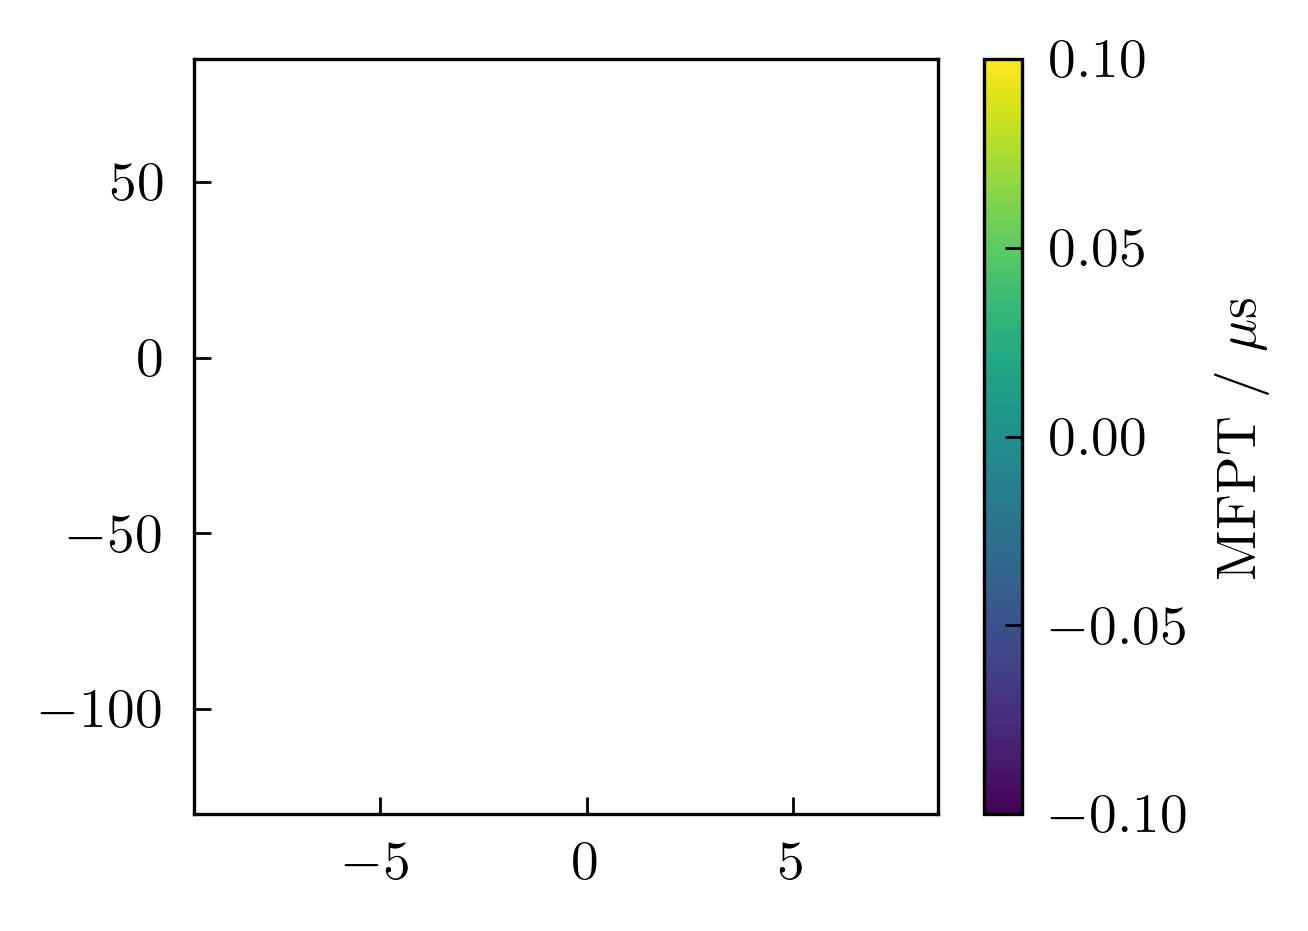

Epoch 47 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


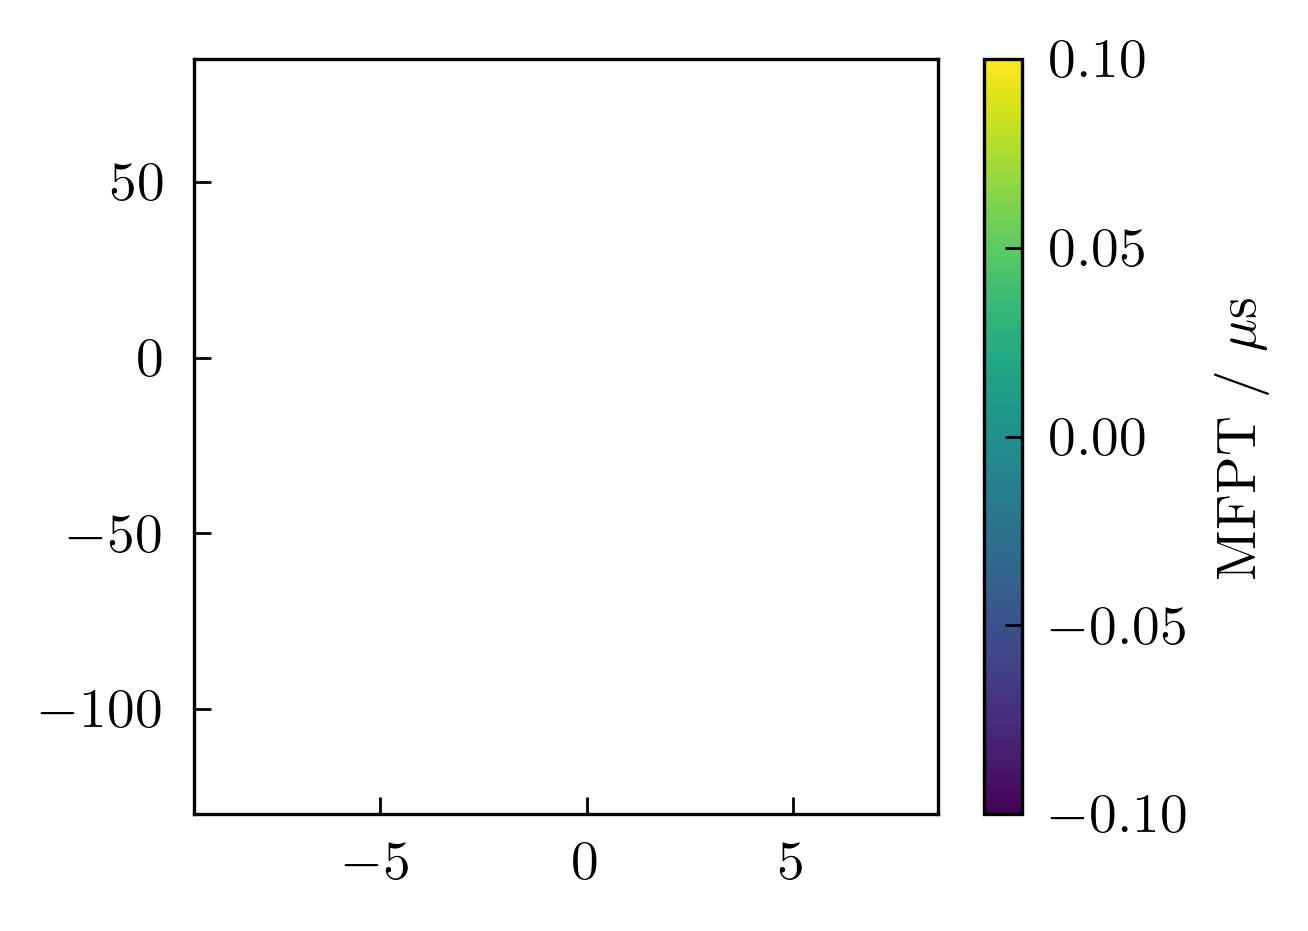

Epoch 48 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


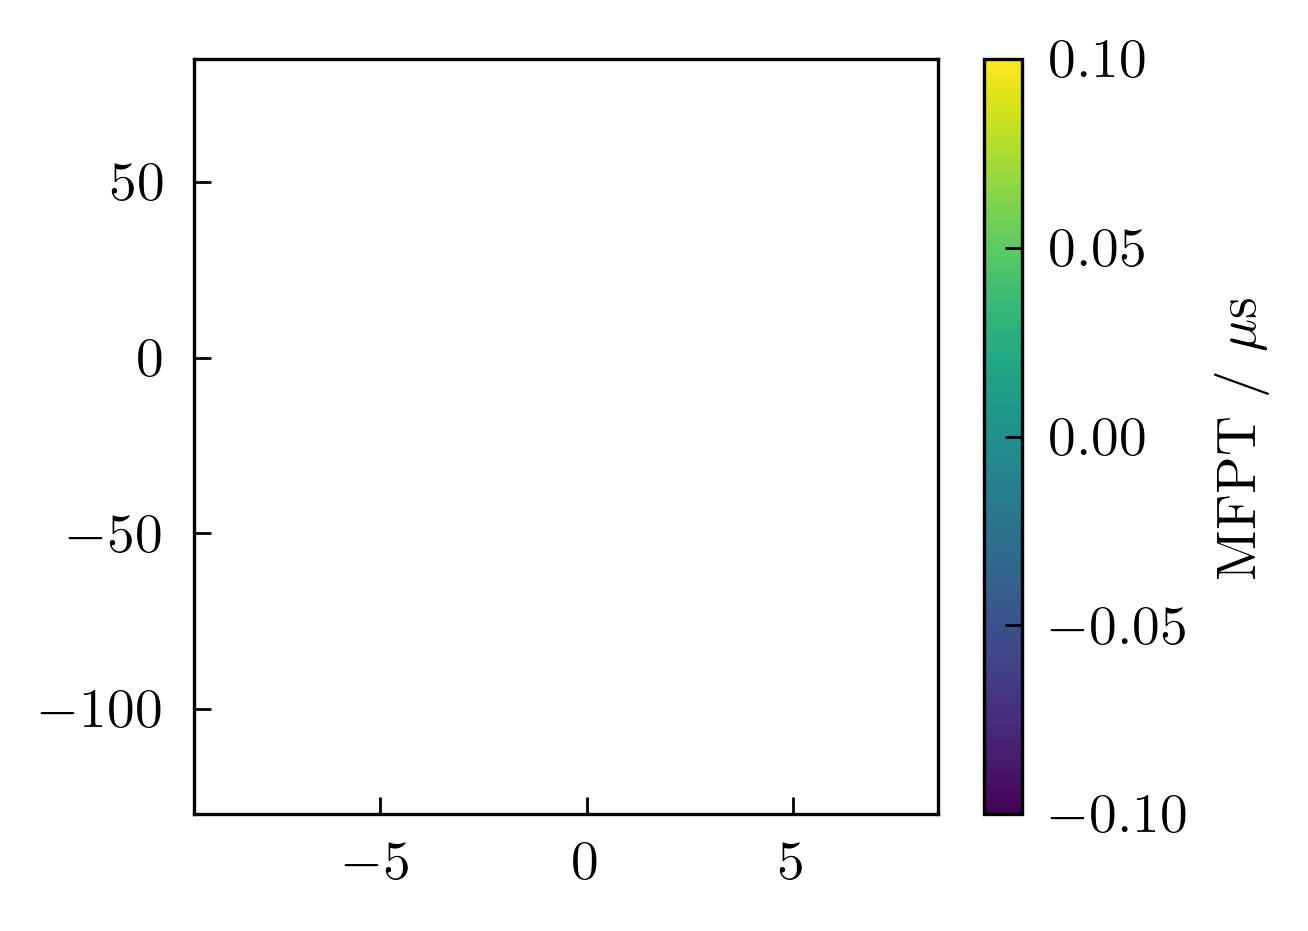

Epoch 49 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


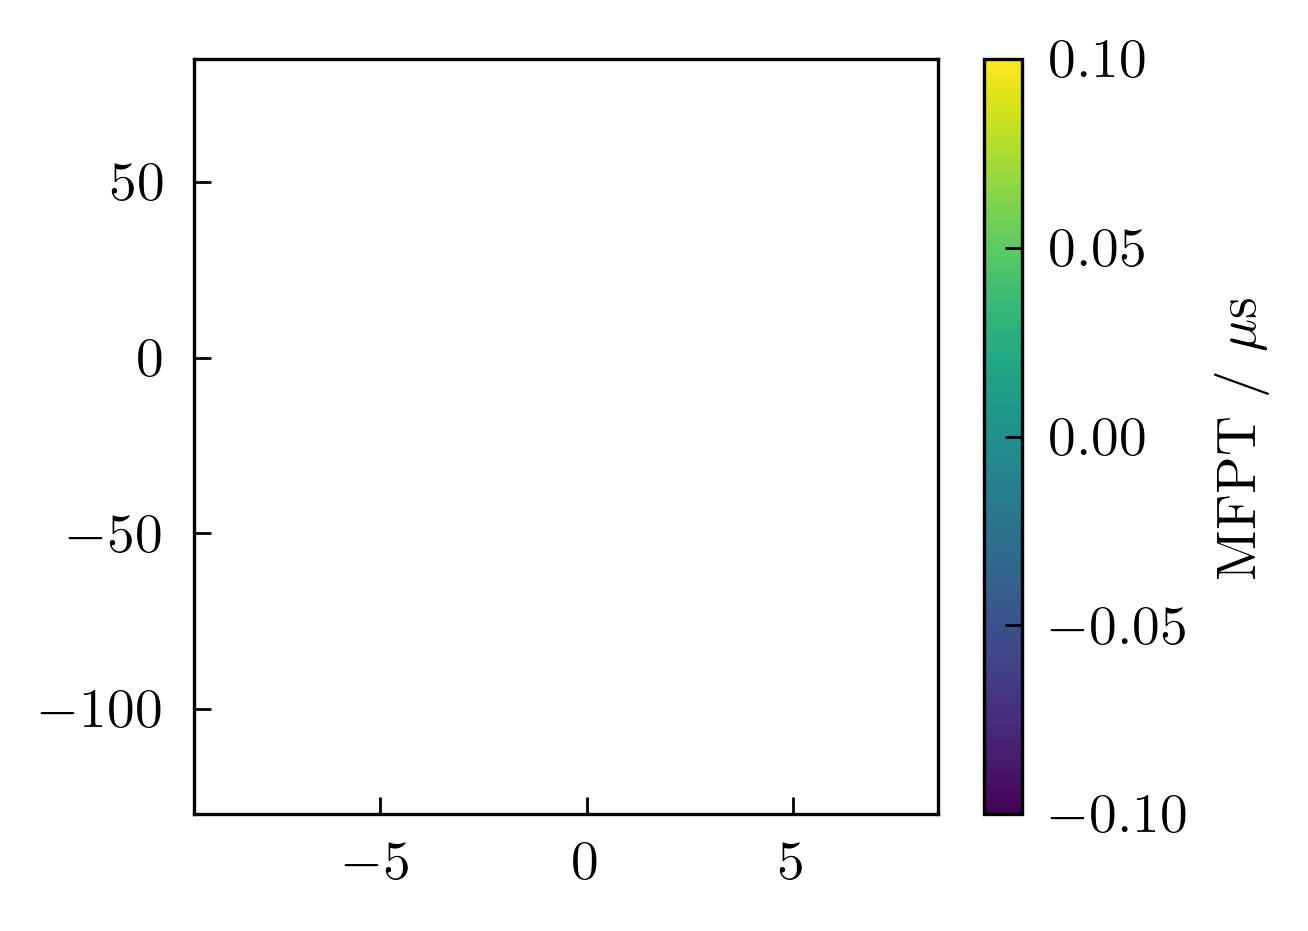

Epoch 50 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


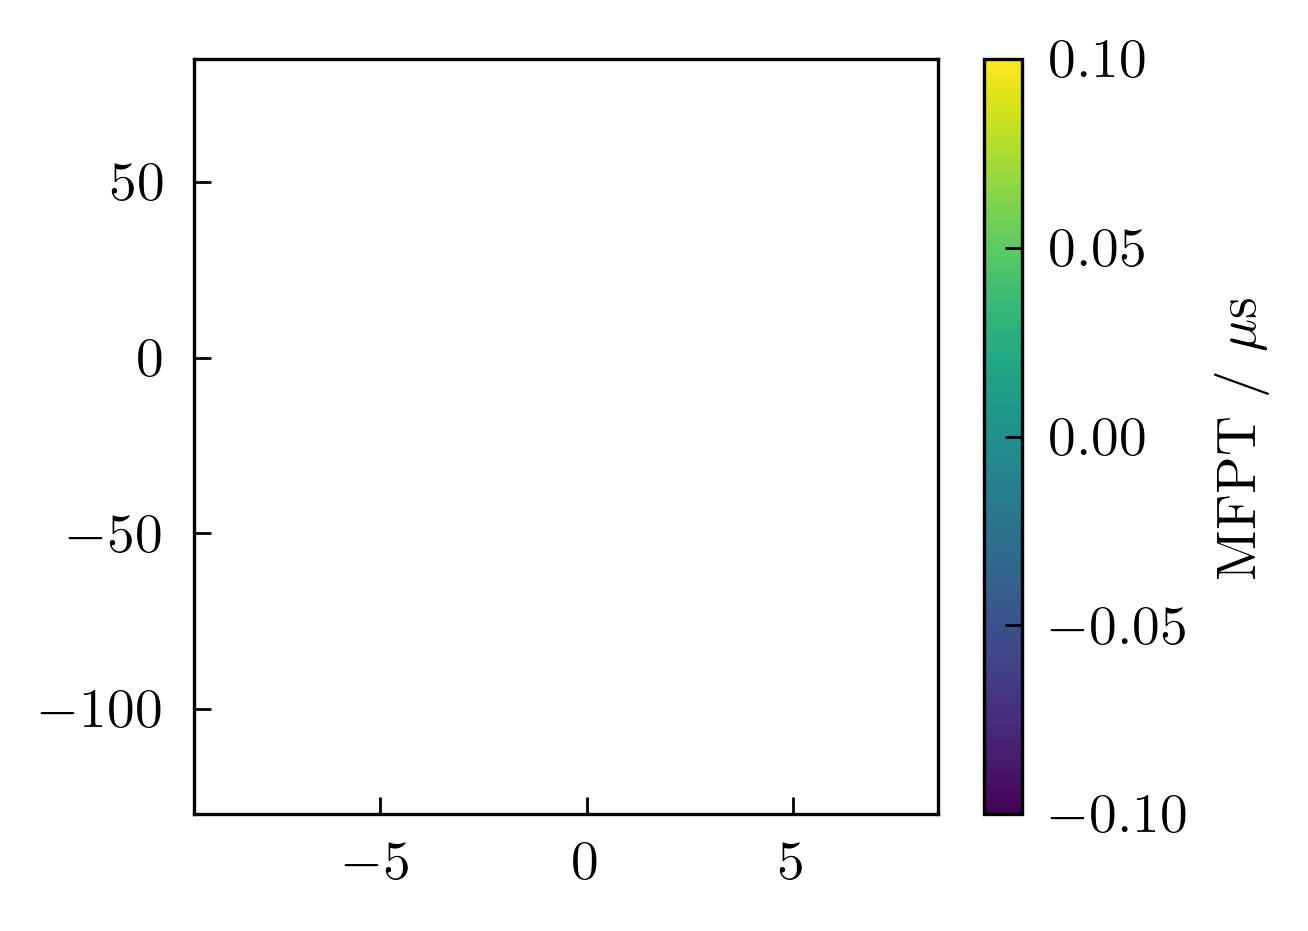

Epoch 51 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


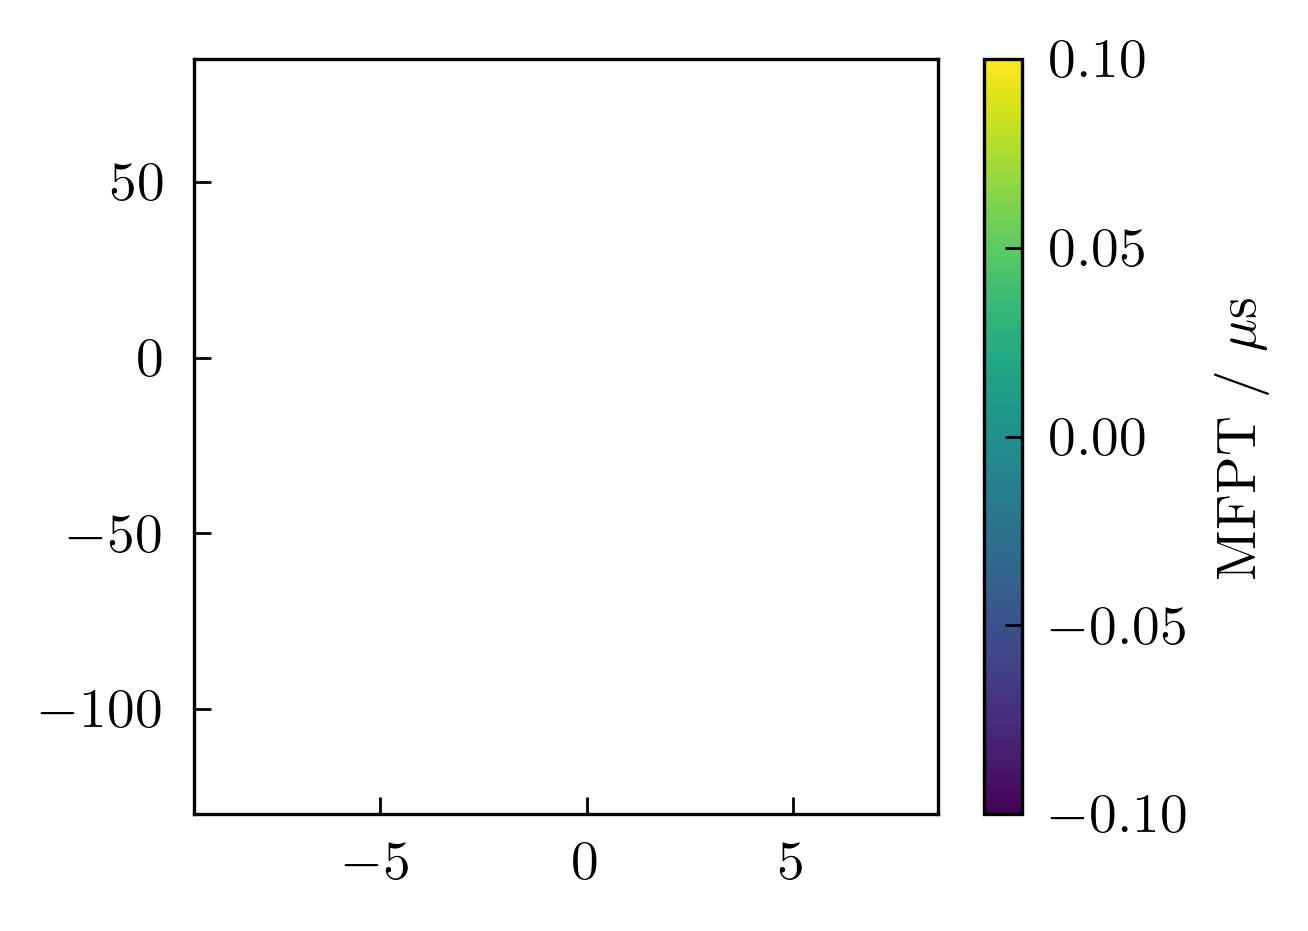

Epoch 52 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


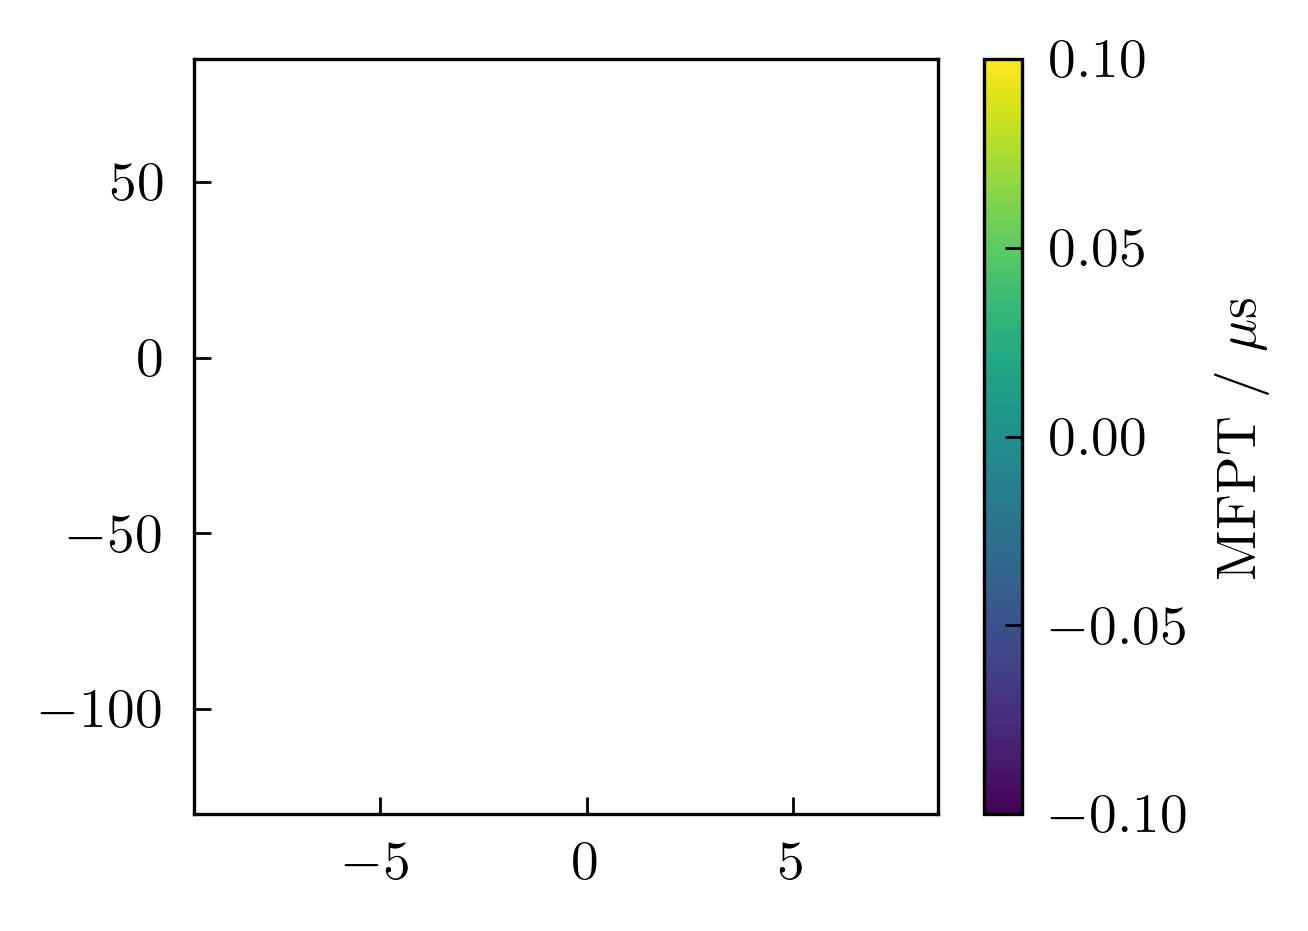

Epoch 53 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


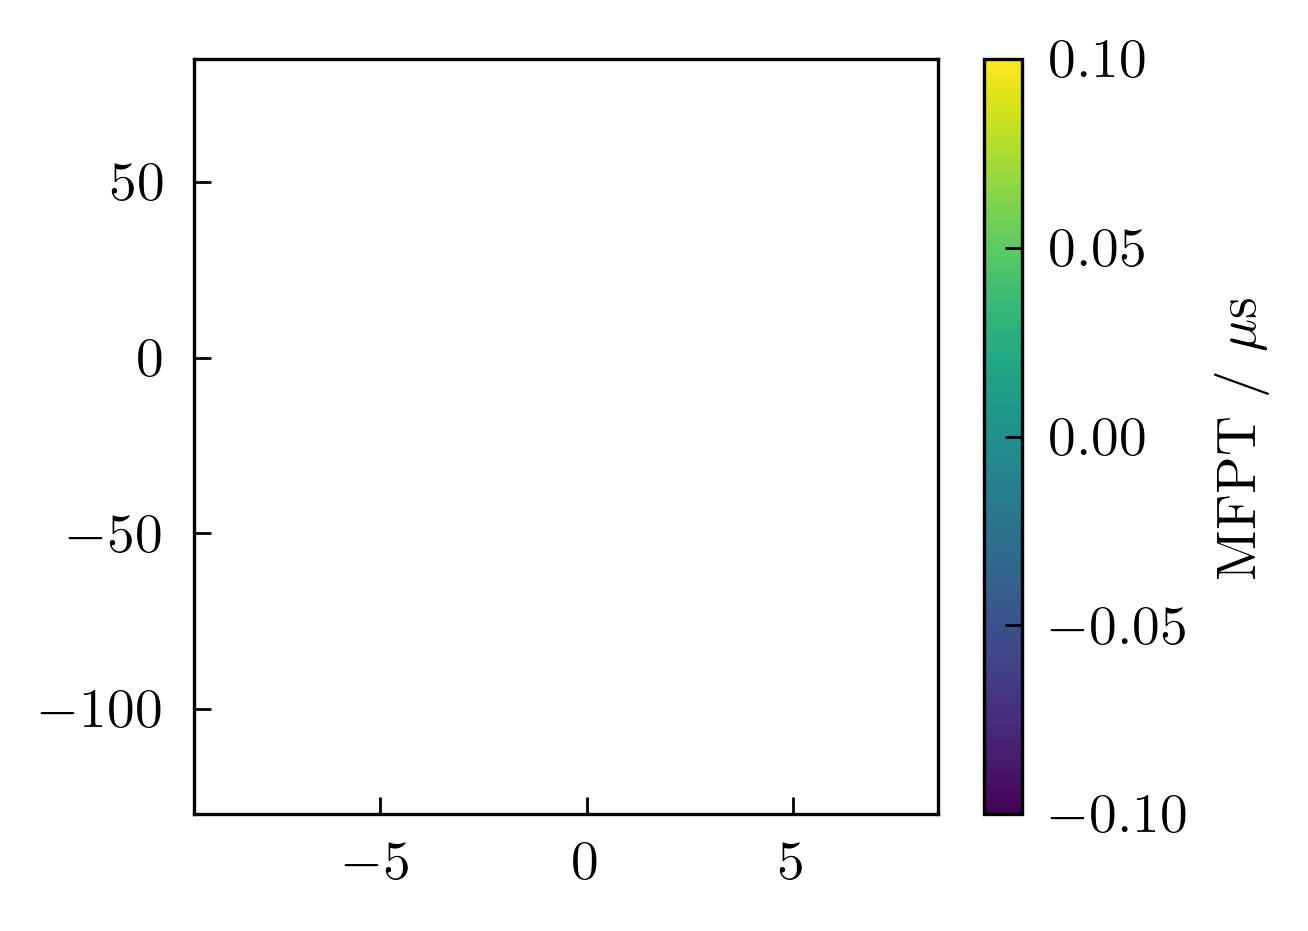

Epoch 54 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


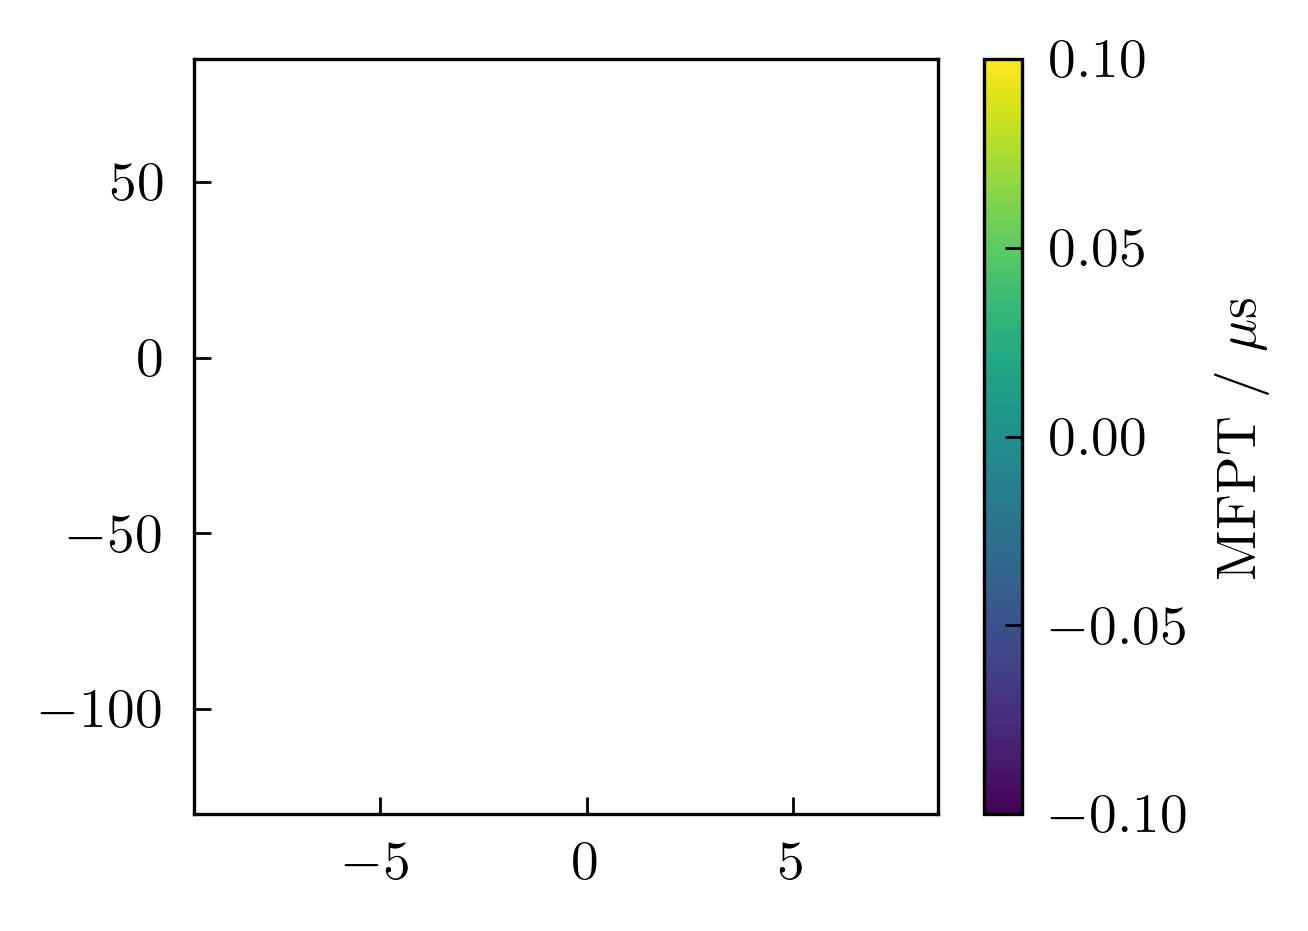

Epoch 55 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


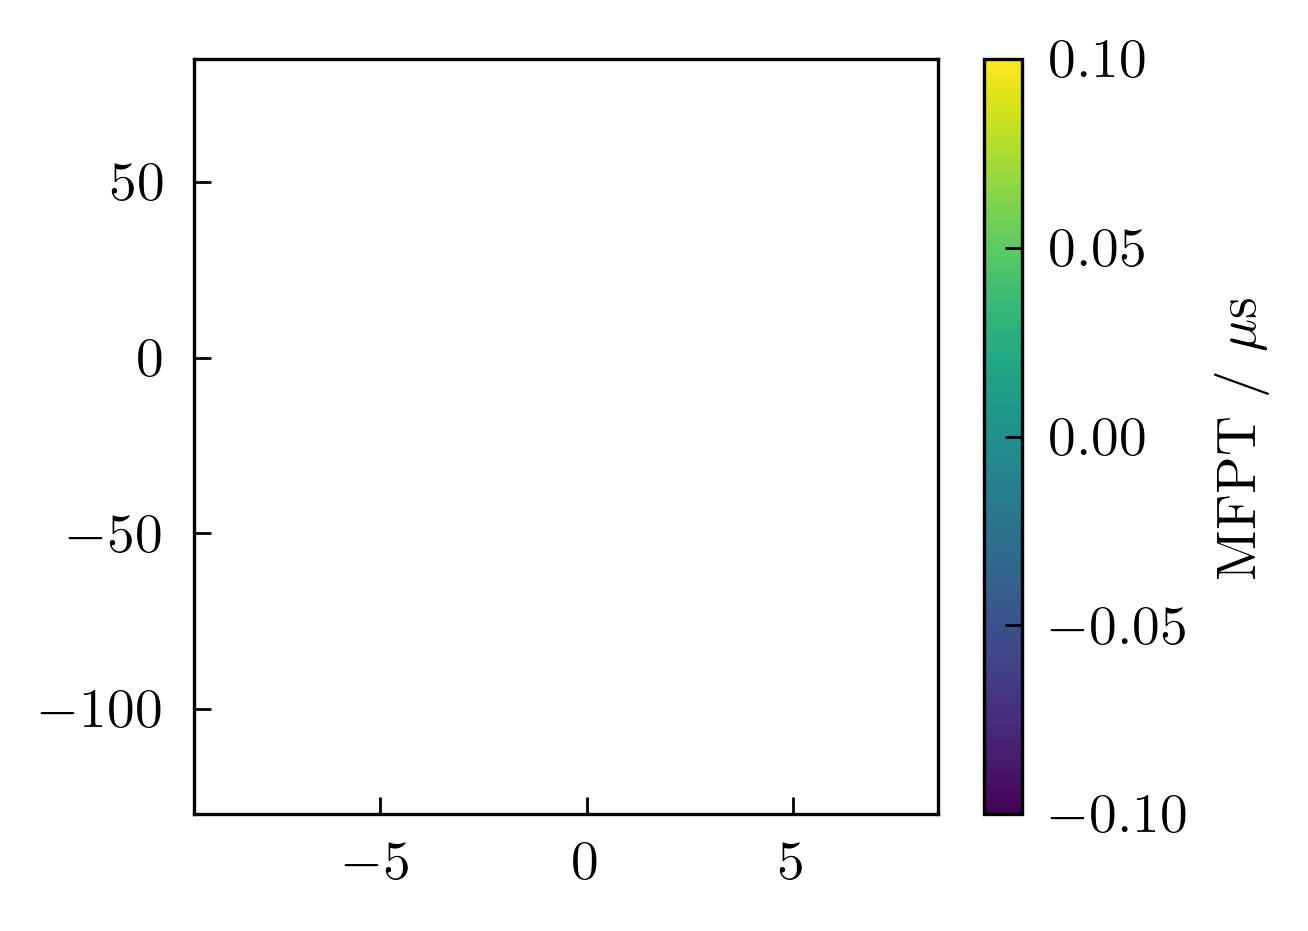

Epoch 56 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


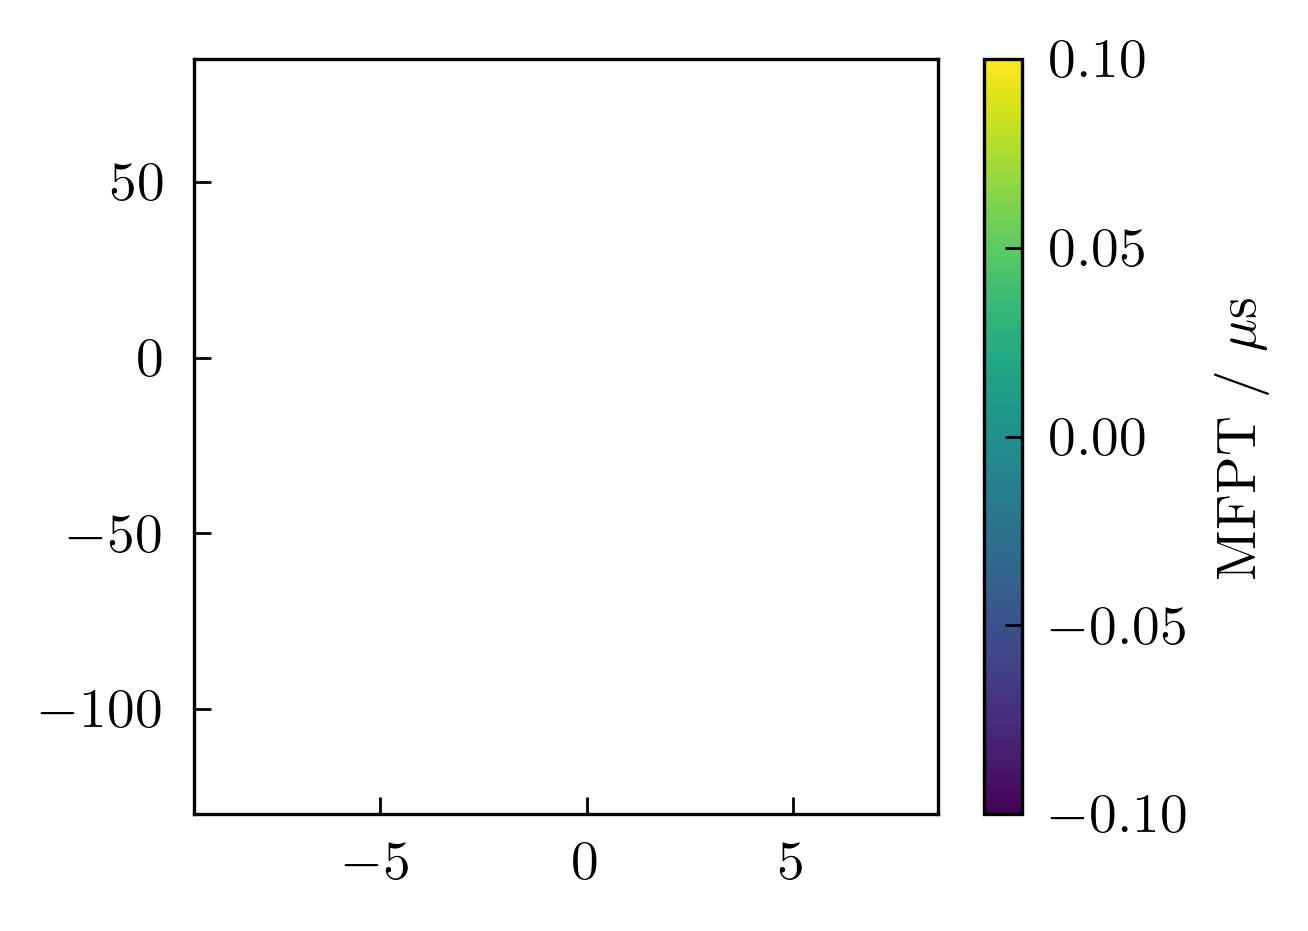

Epoch 57 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


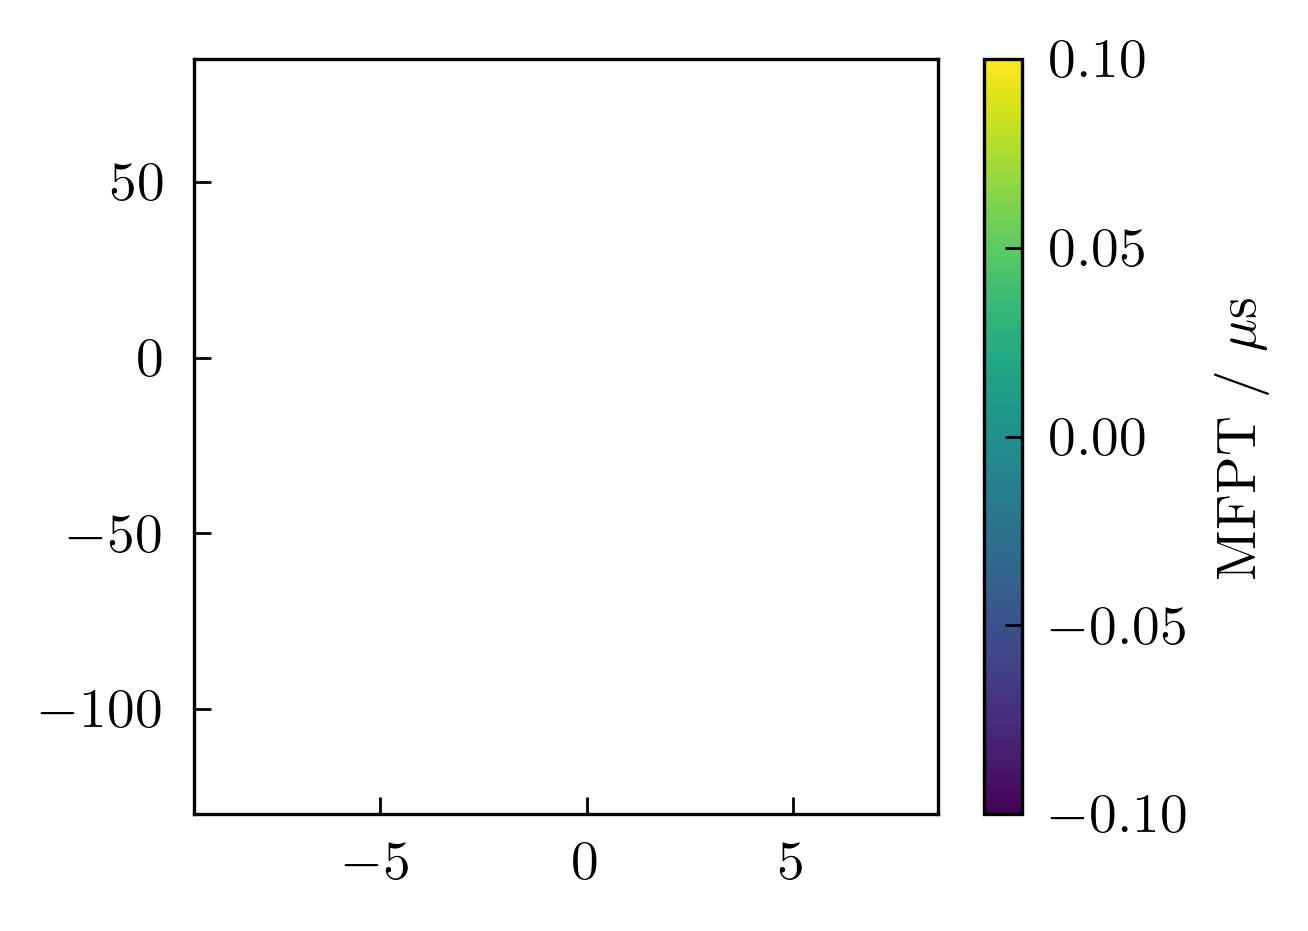

Epoch 58 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


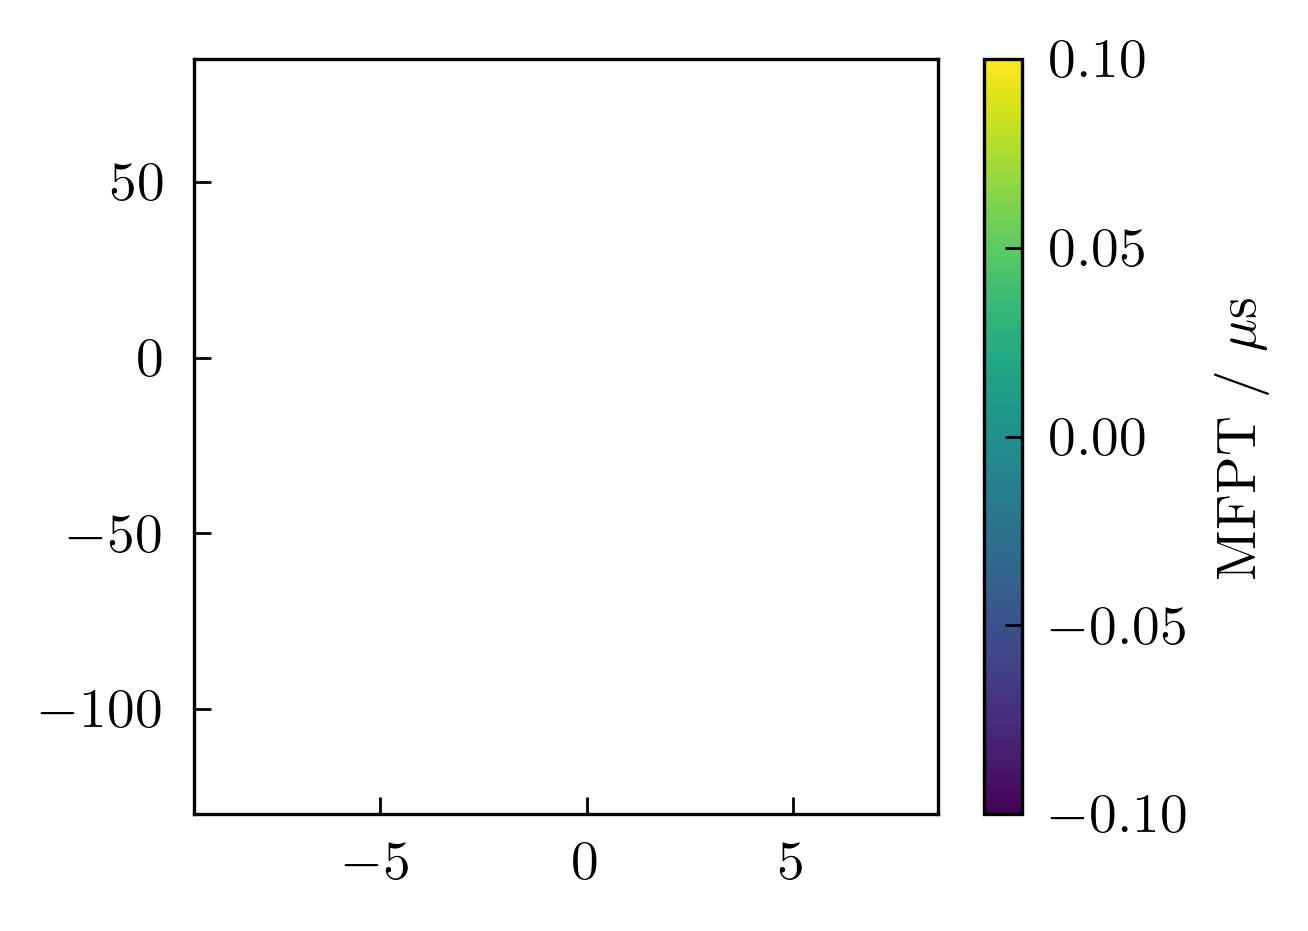

Epoch 59 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


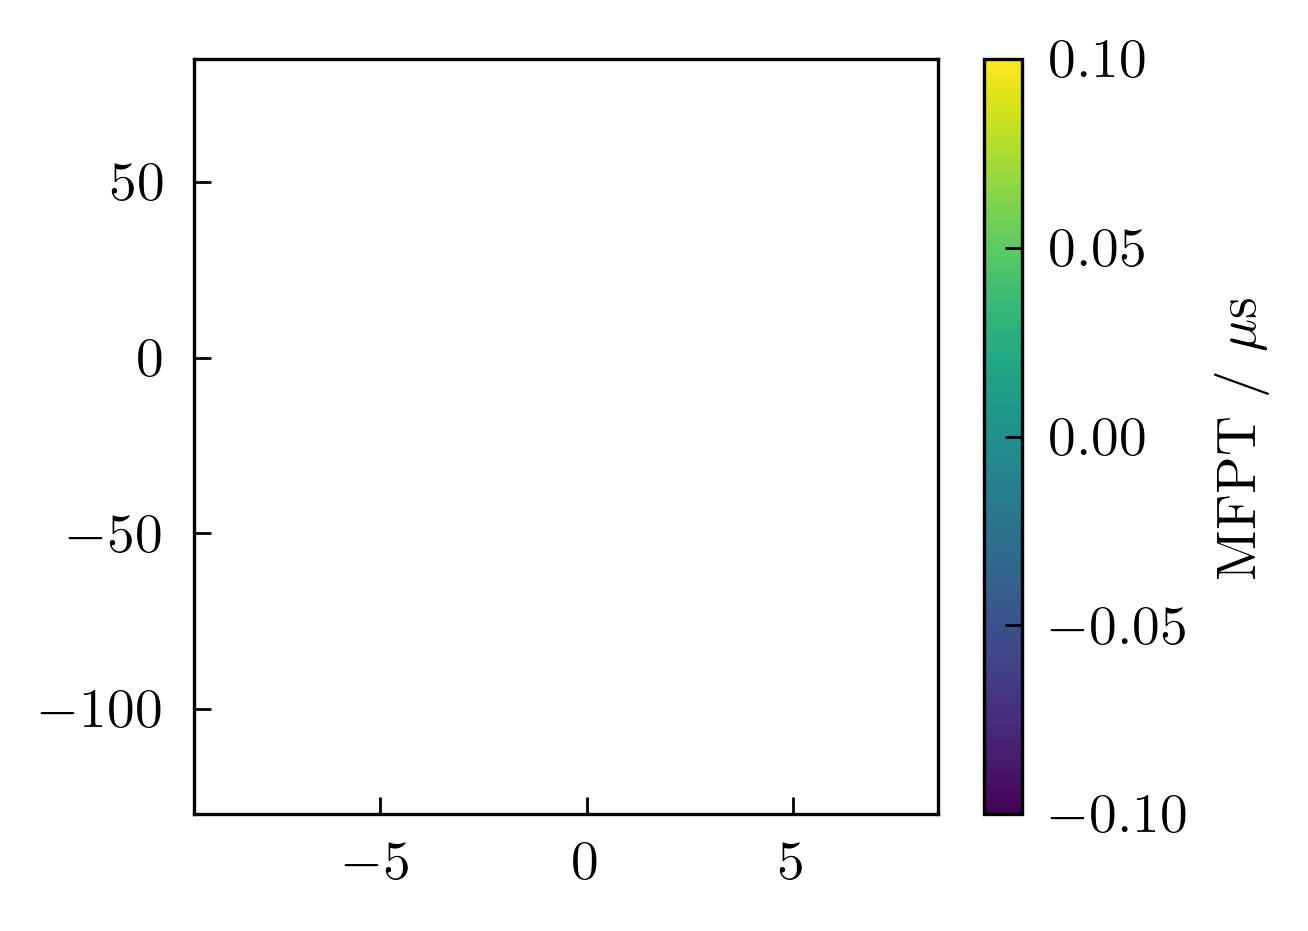

Epoch 60 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


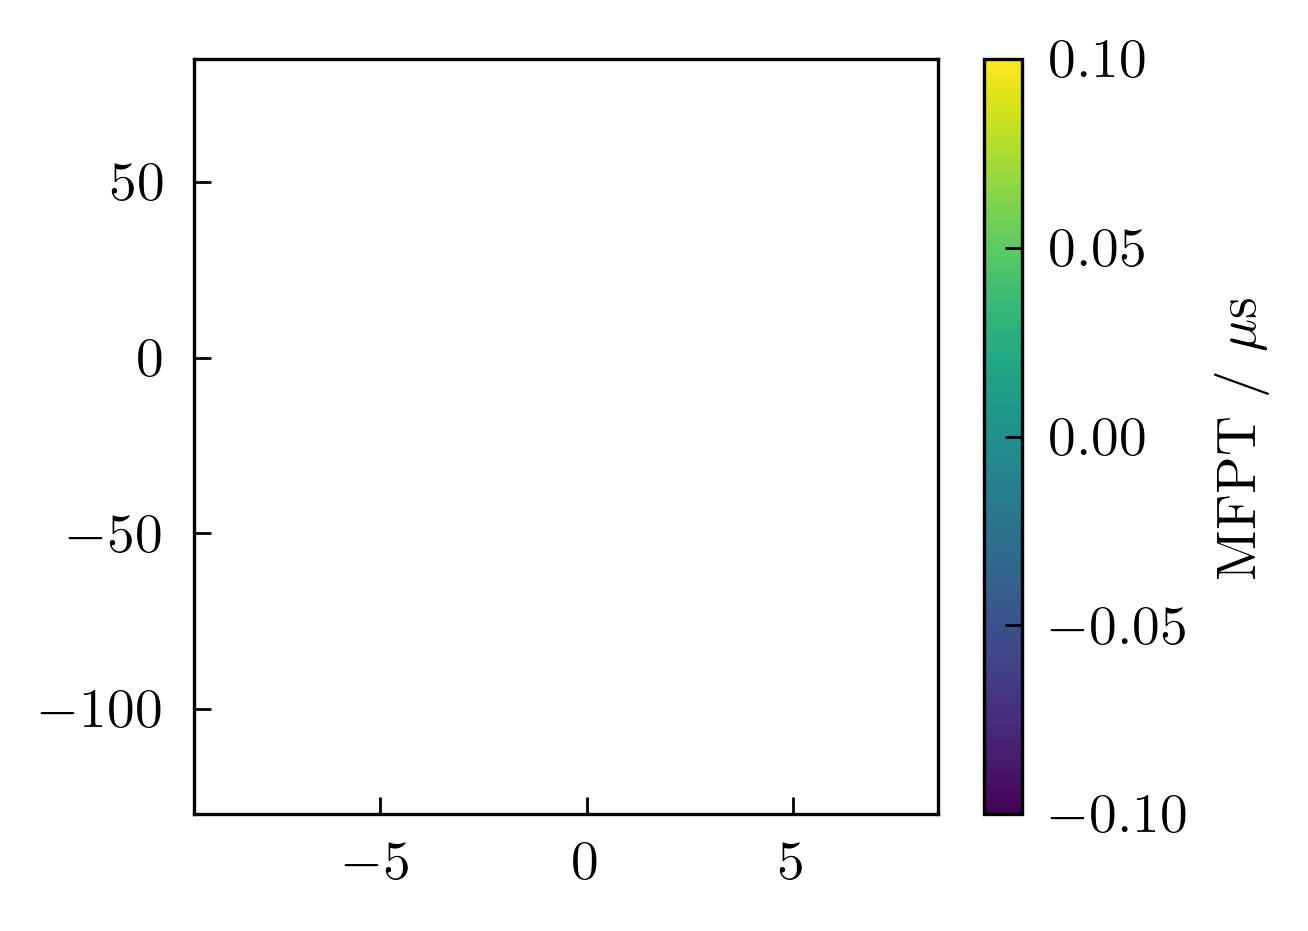

Epoch 61 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


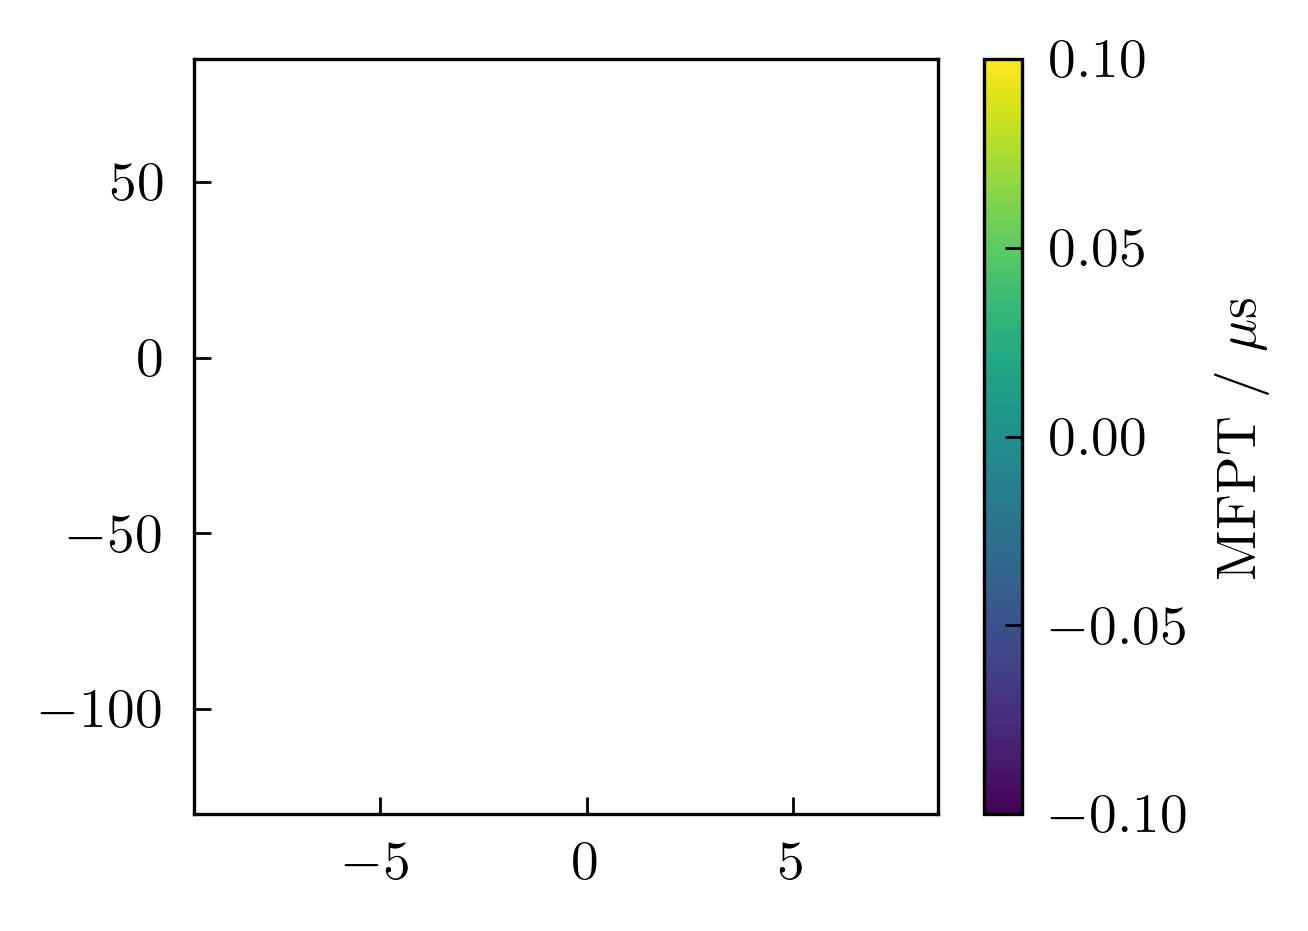

Epoch 62 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


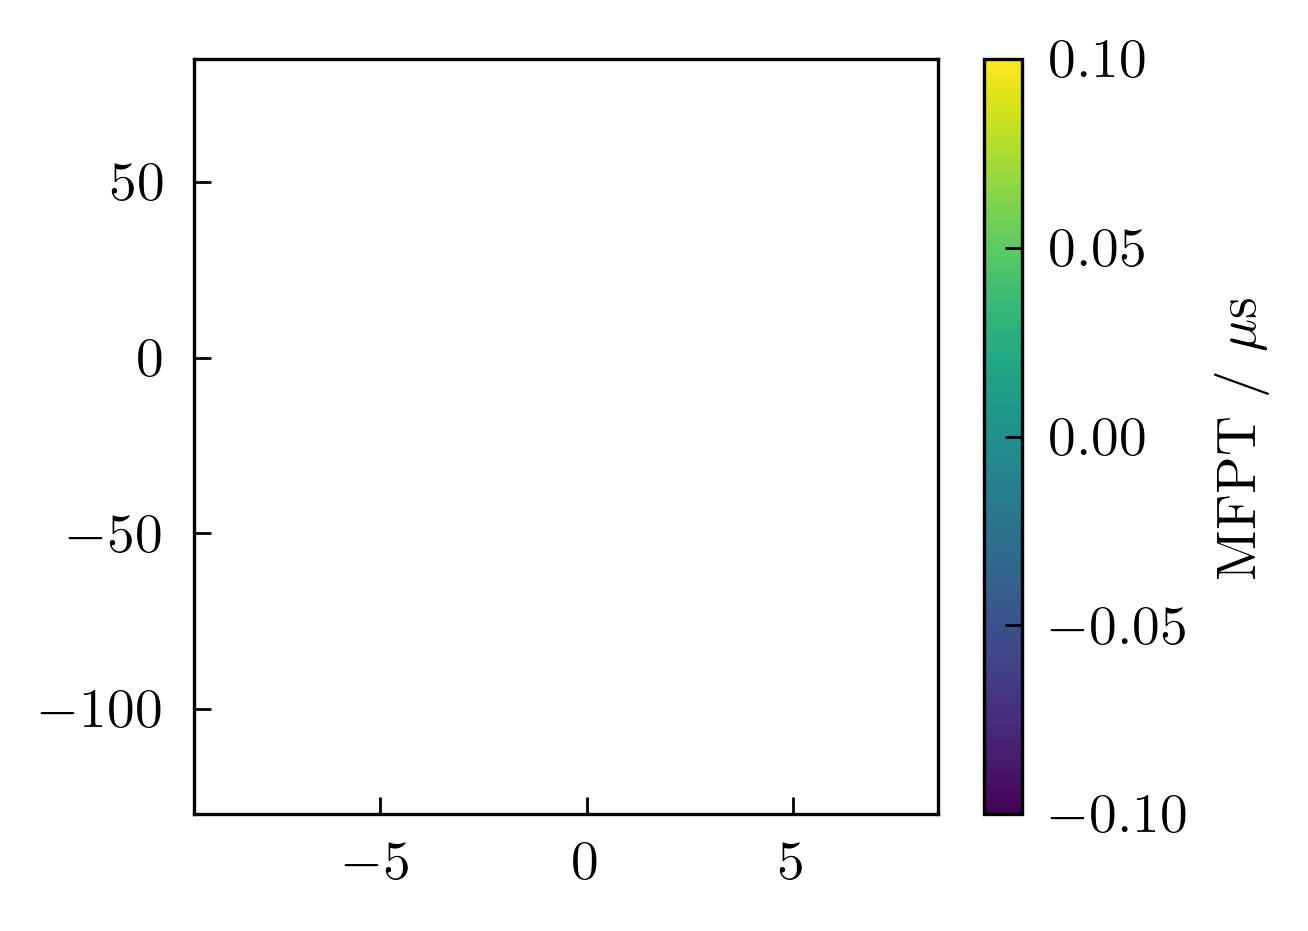

Epoch 63 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


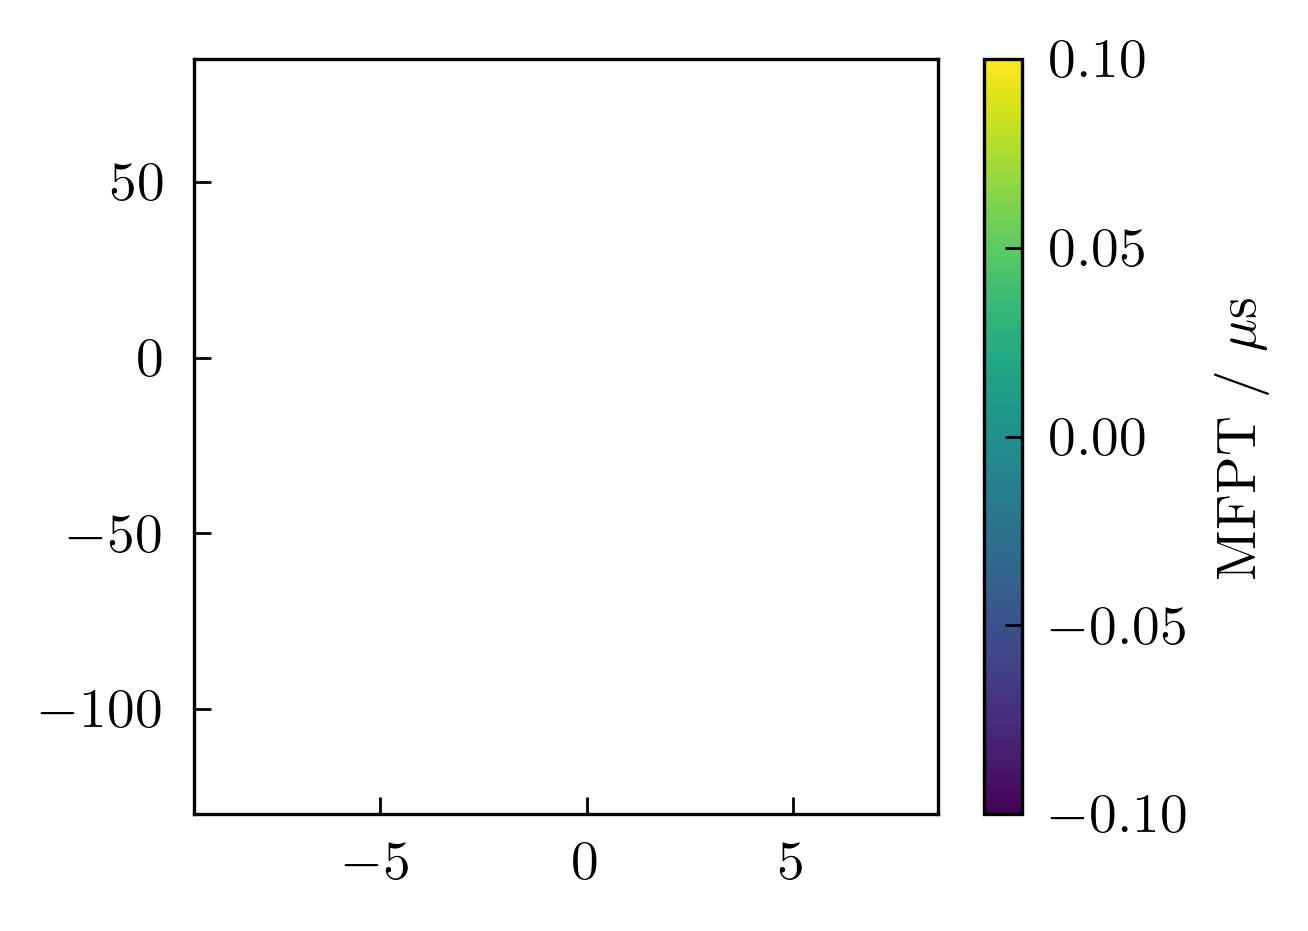

Epoch 64 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


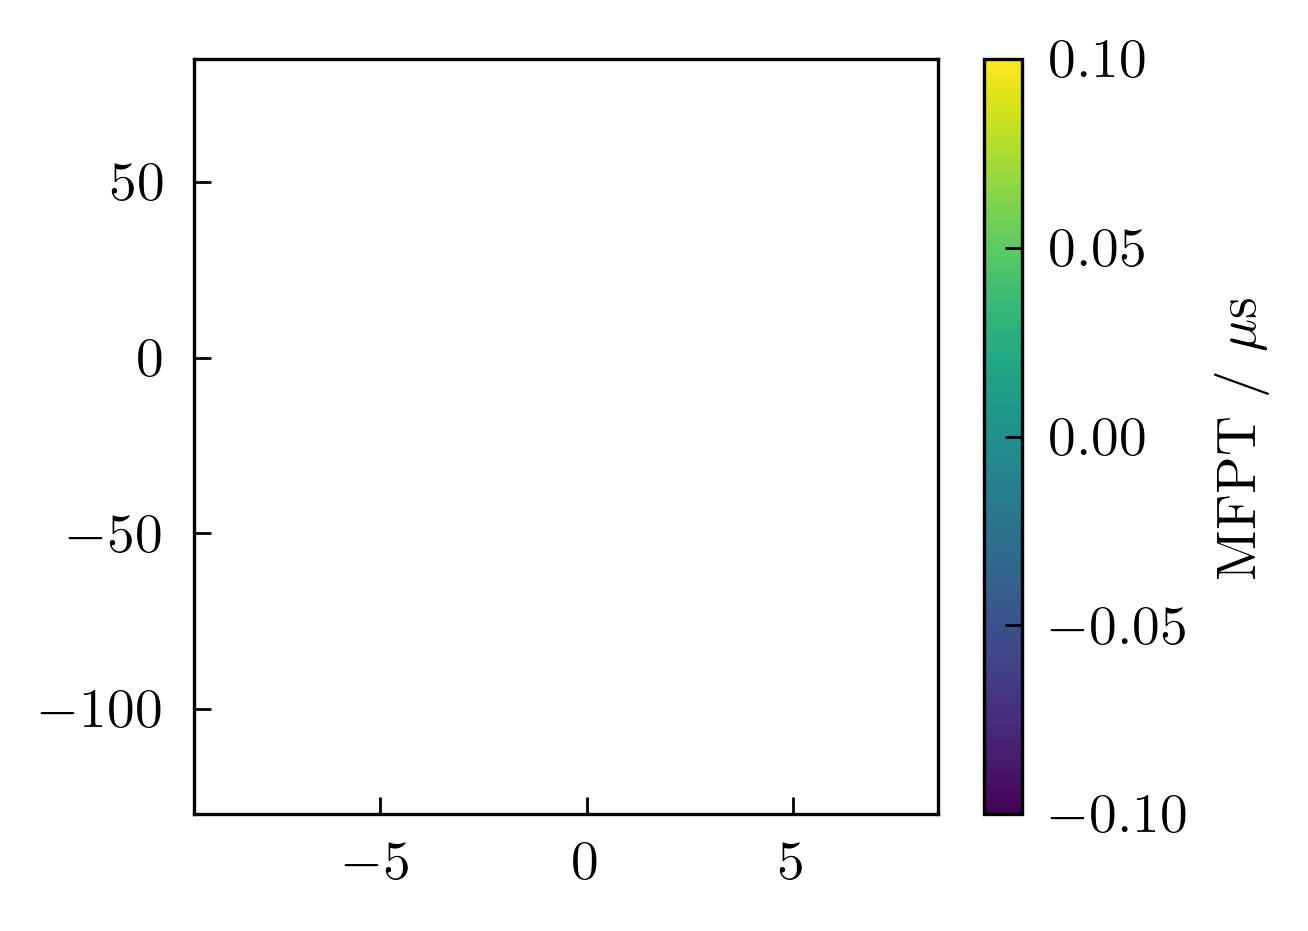

Epoch 65 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


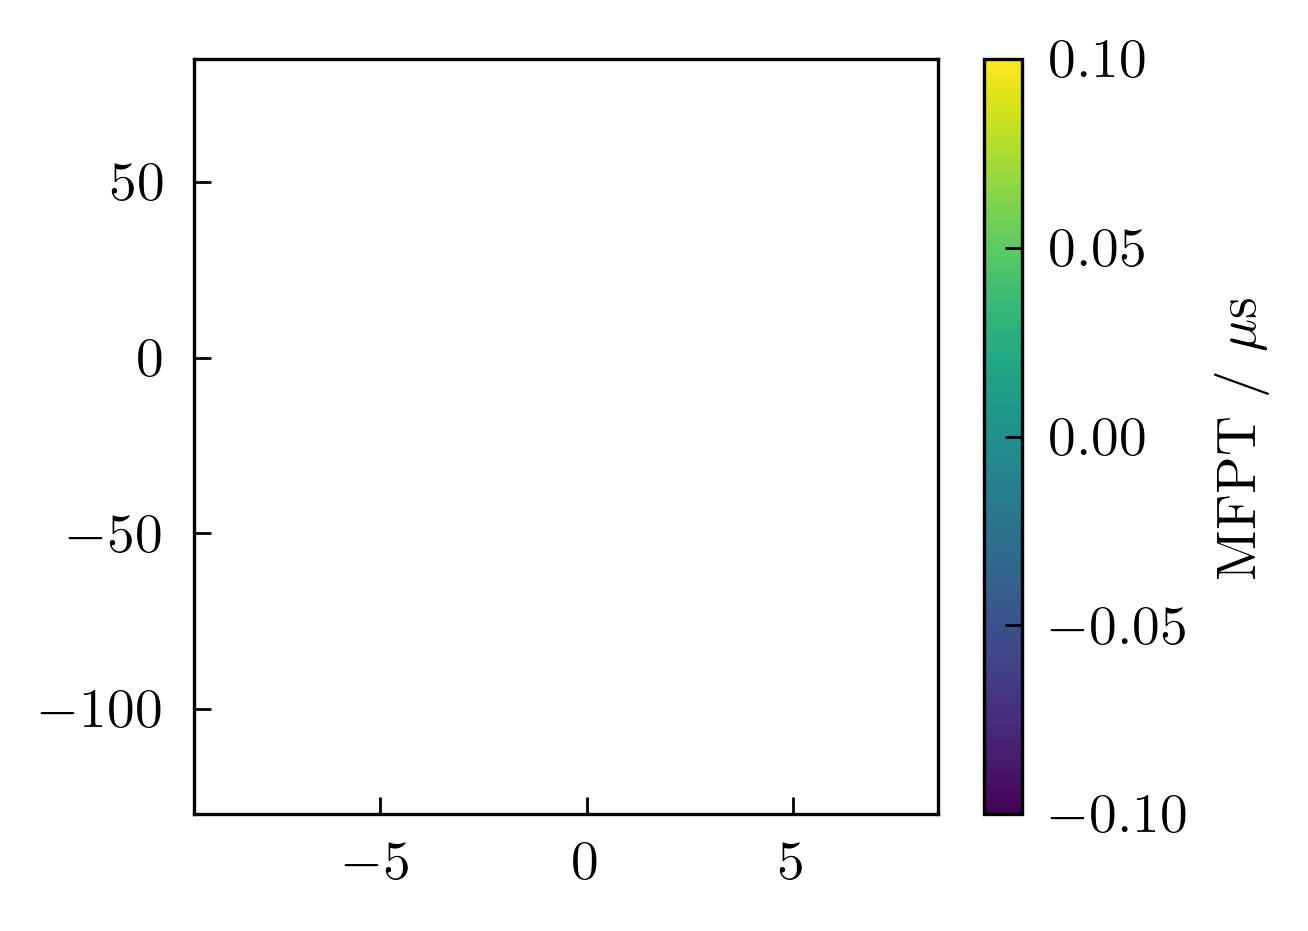

Epoch 66 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


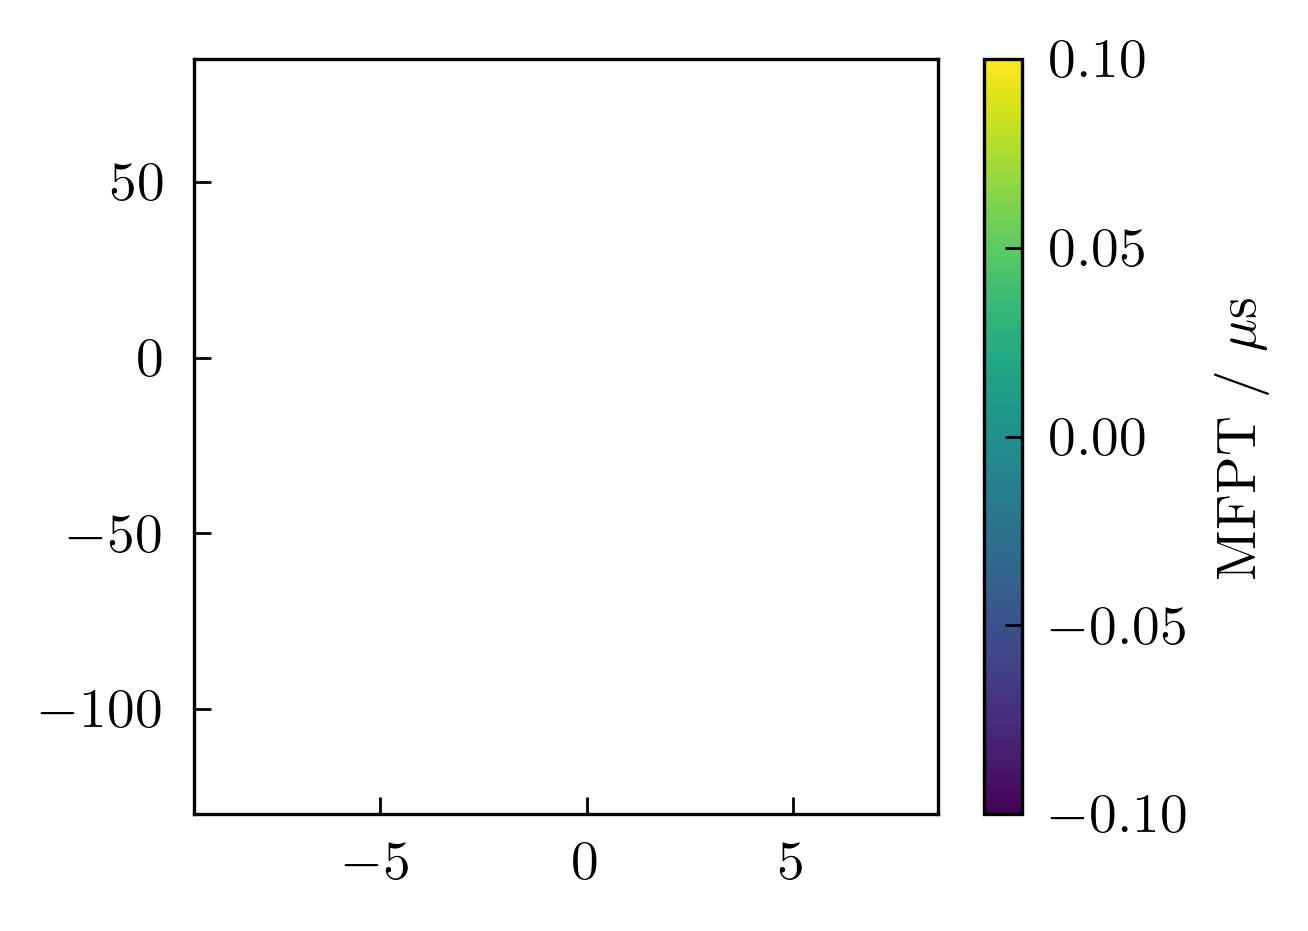

Epoch 67 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


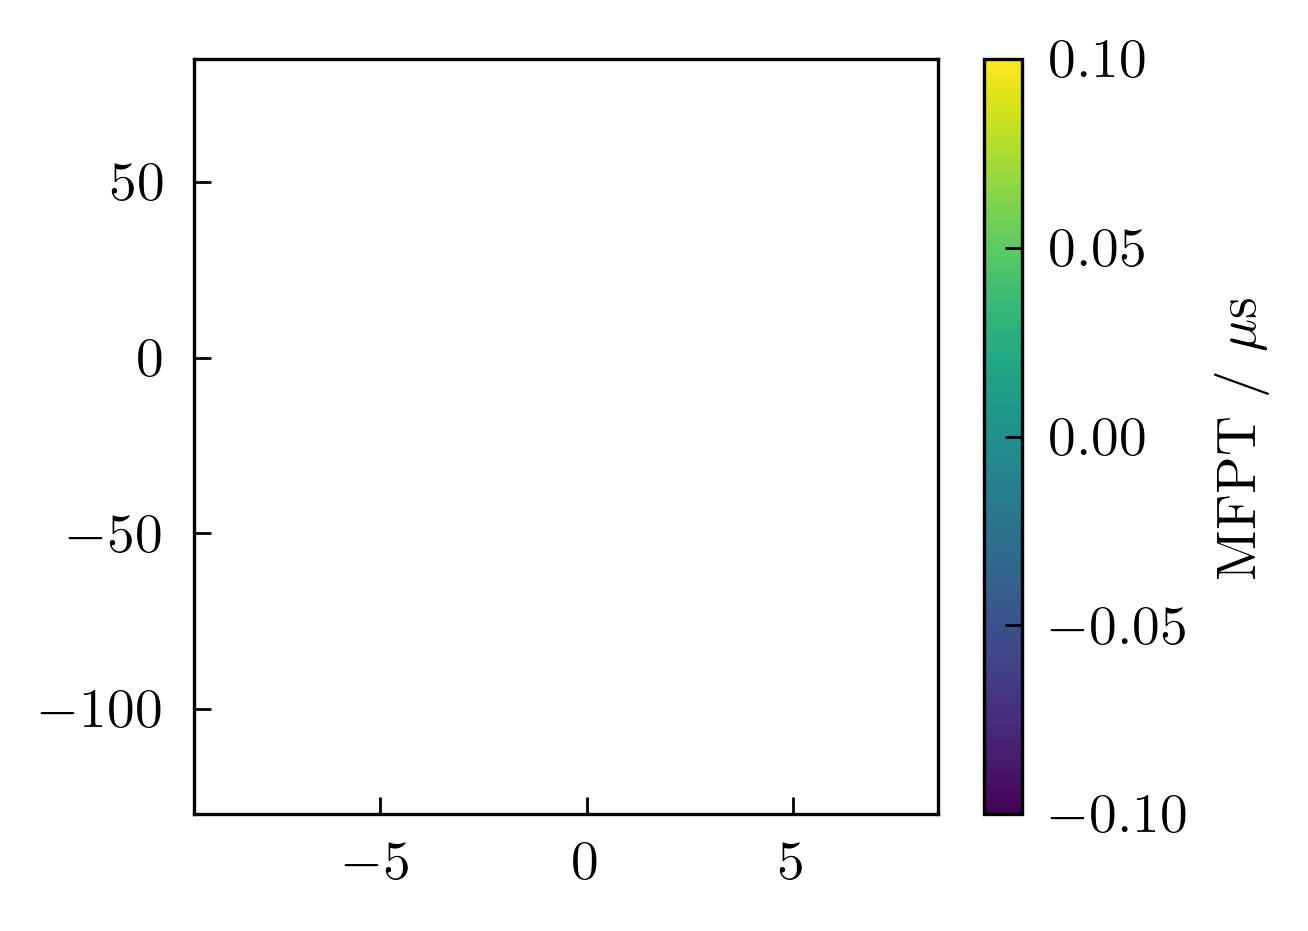

Epoch 68 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


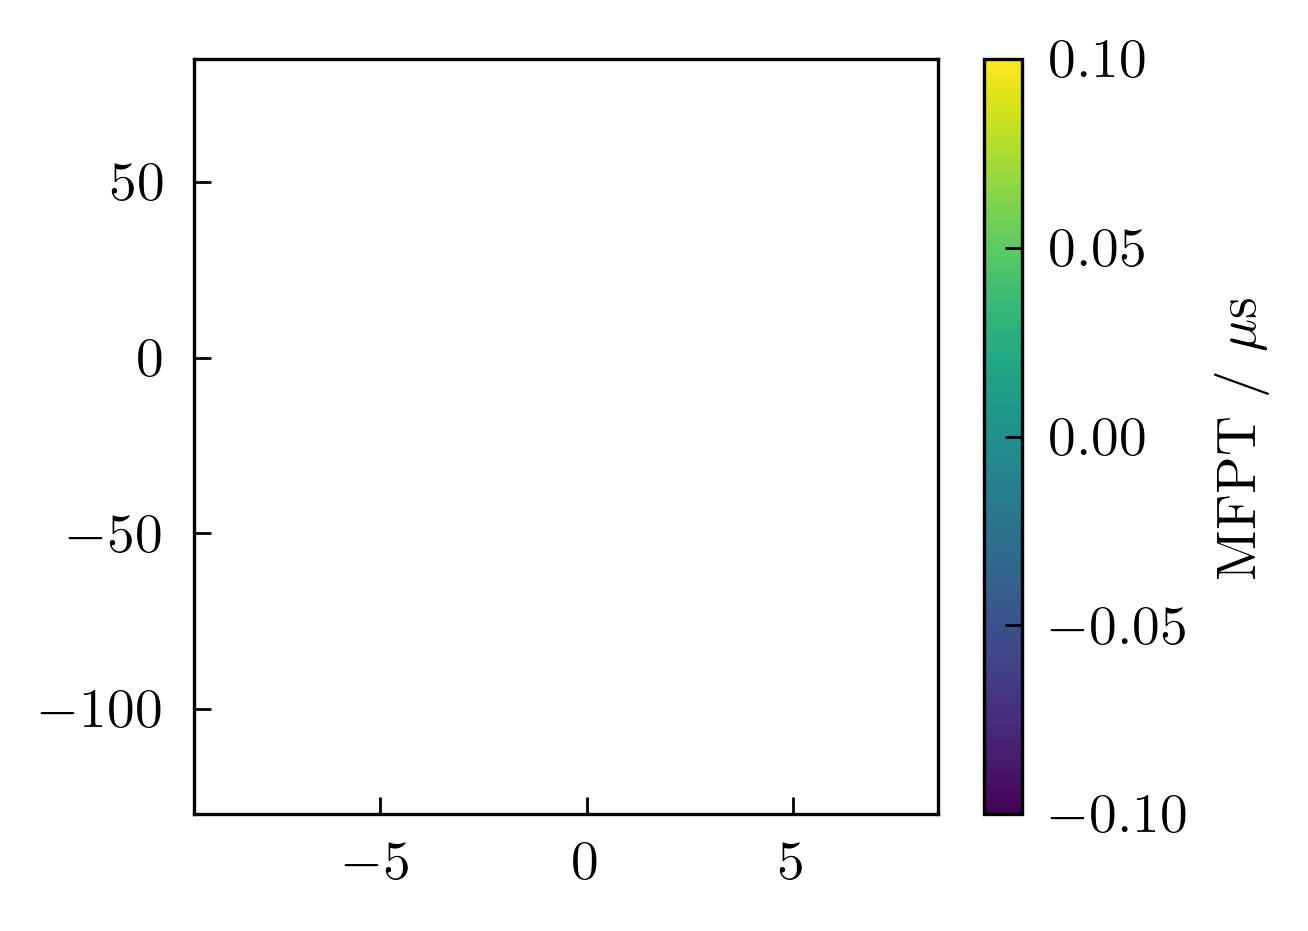

Epoch 69 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


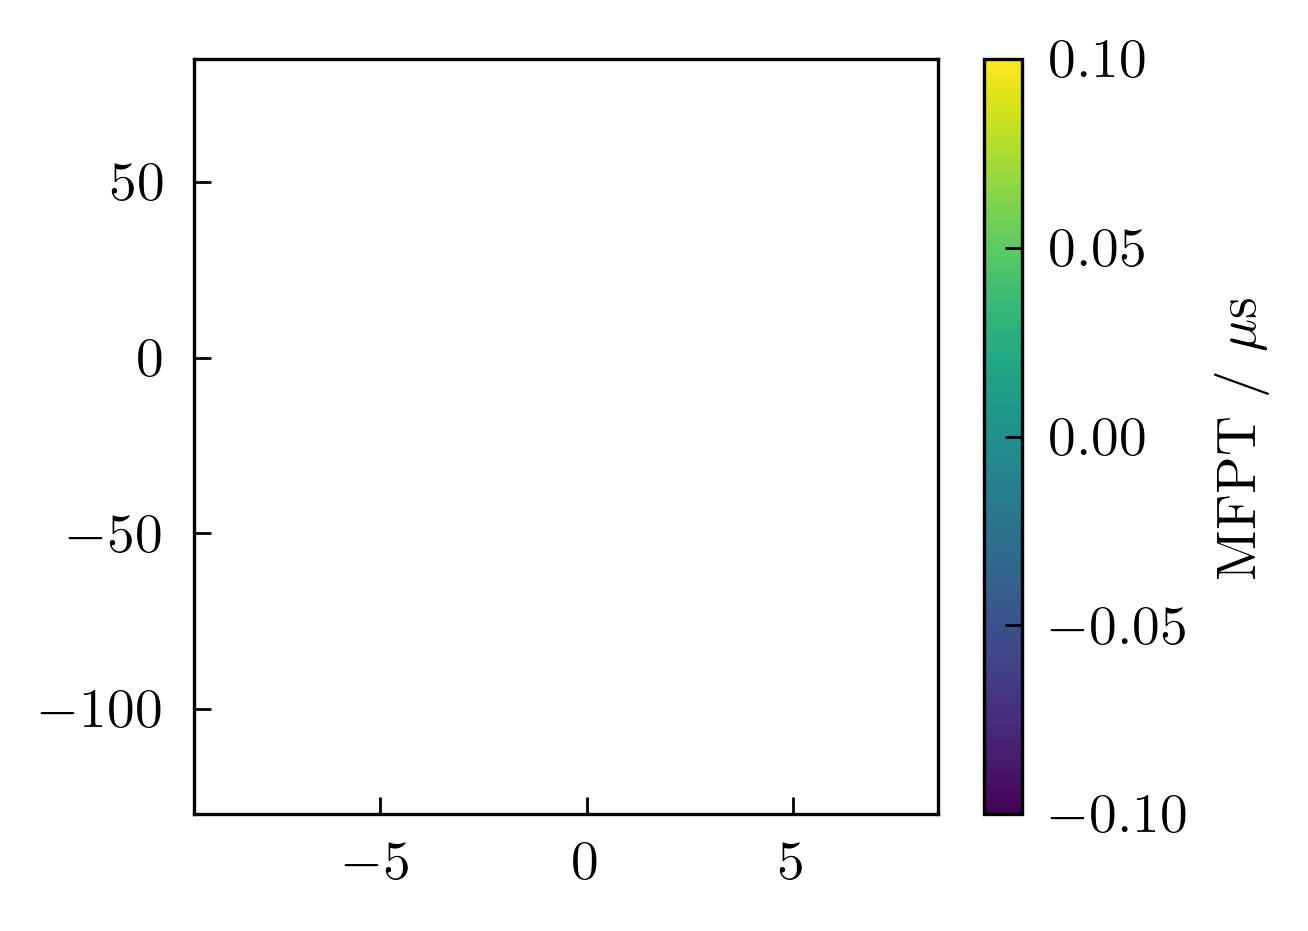

Epoch 70 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


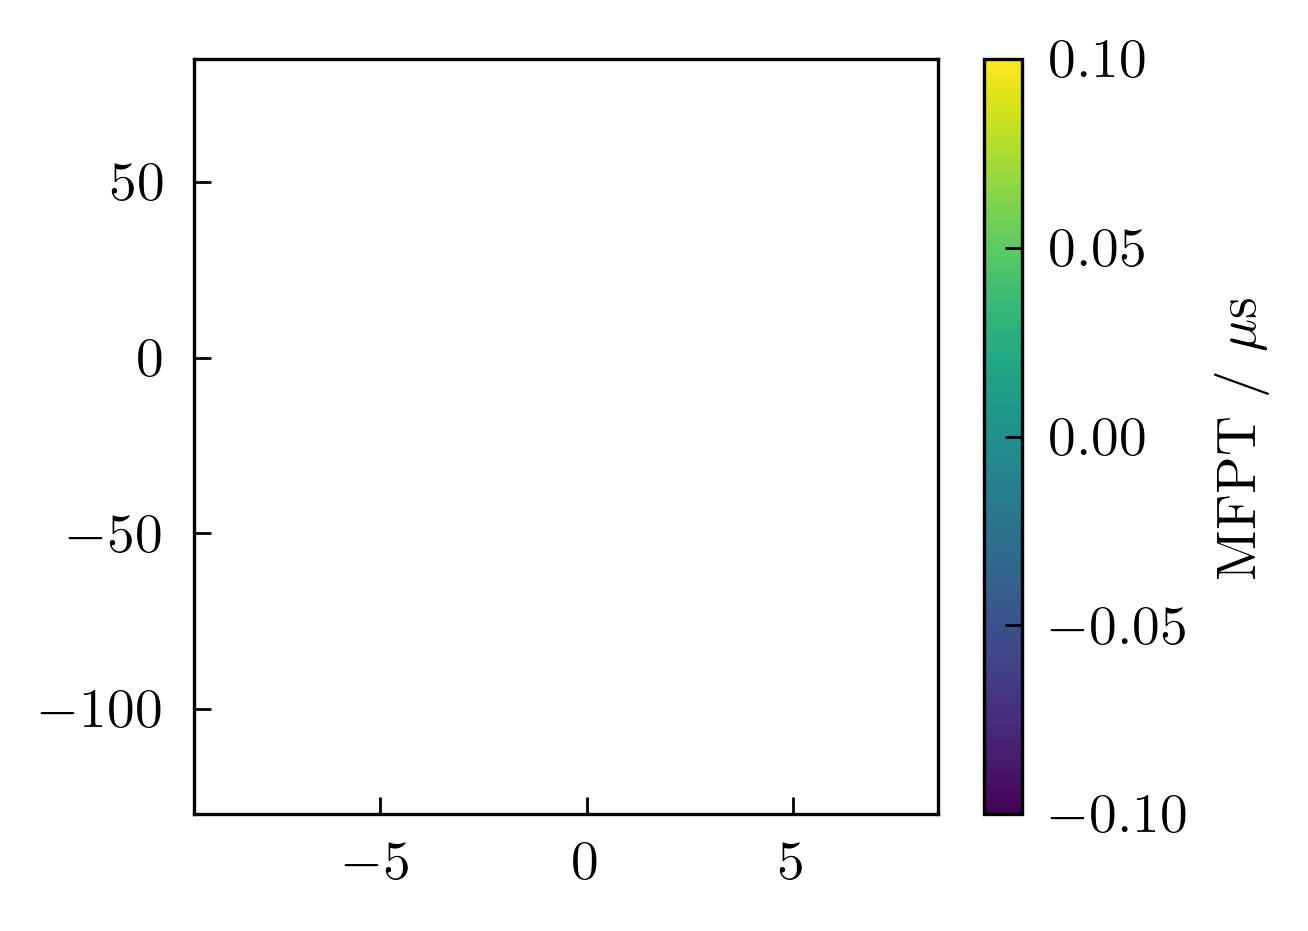

Epoch 71 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


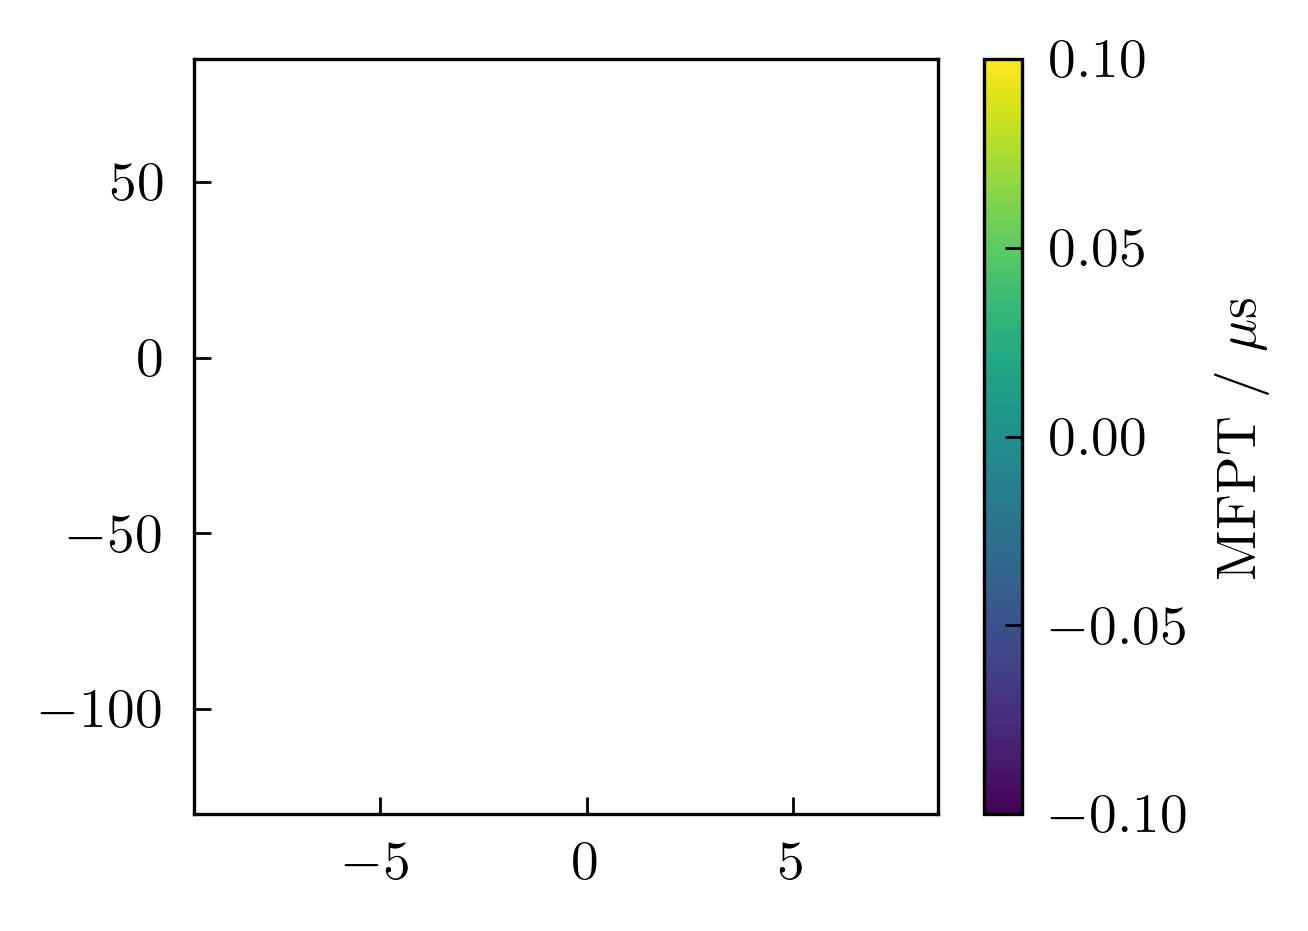

Epoch 72 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


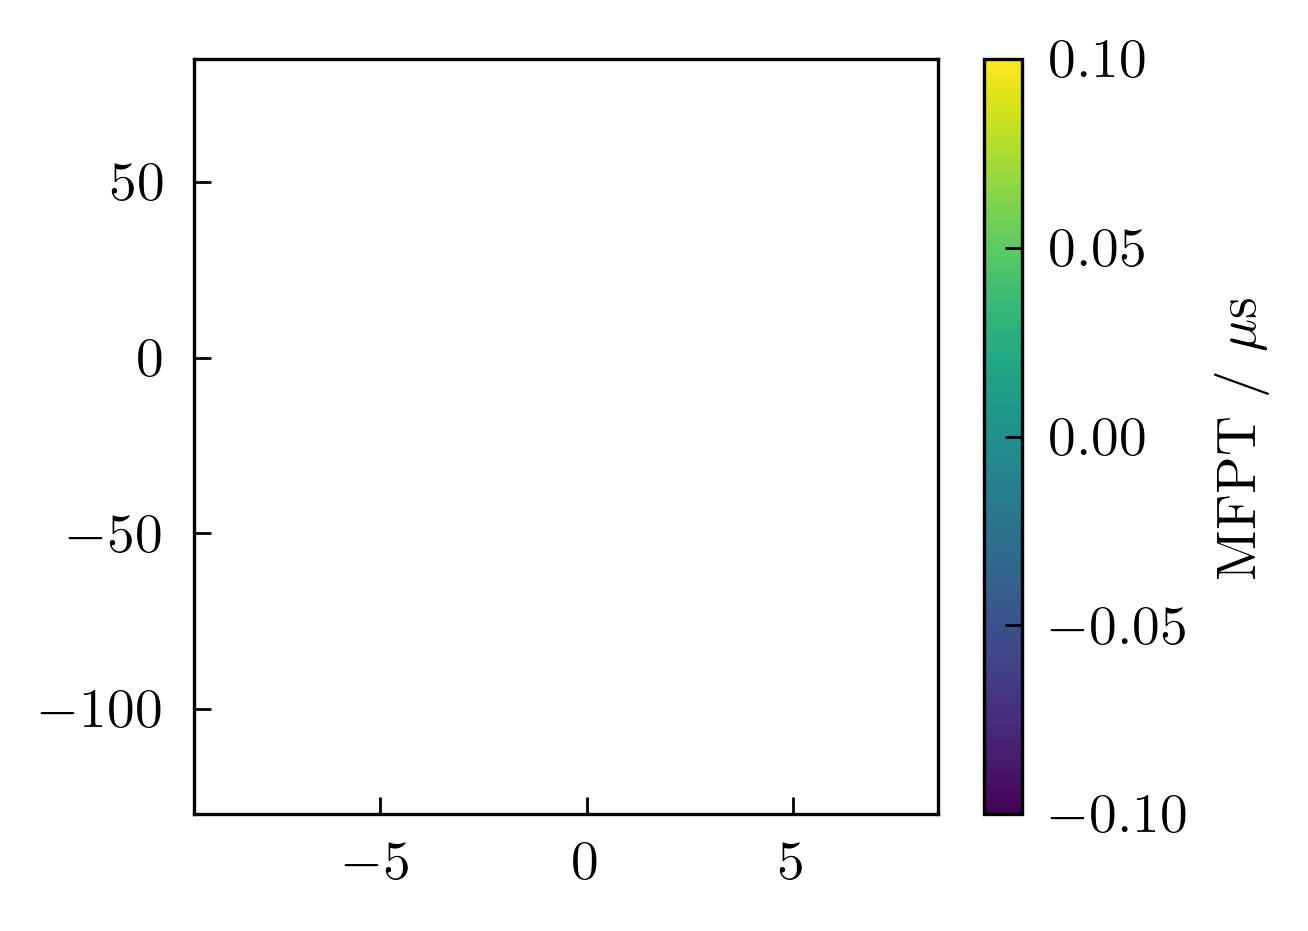

Epoch 73 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


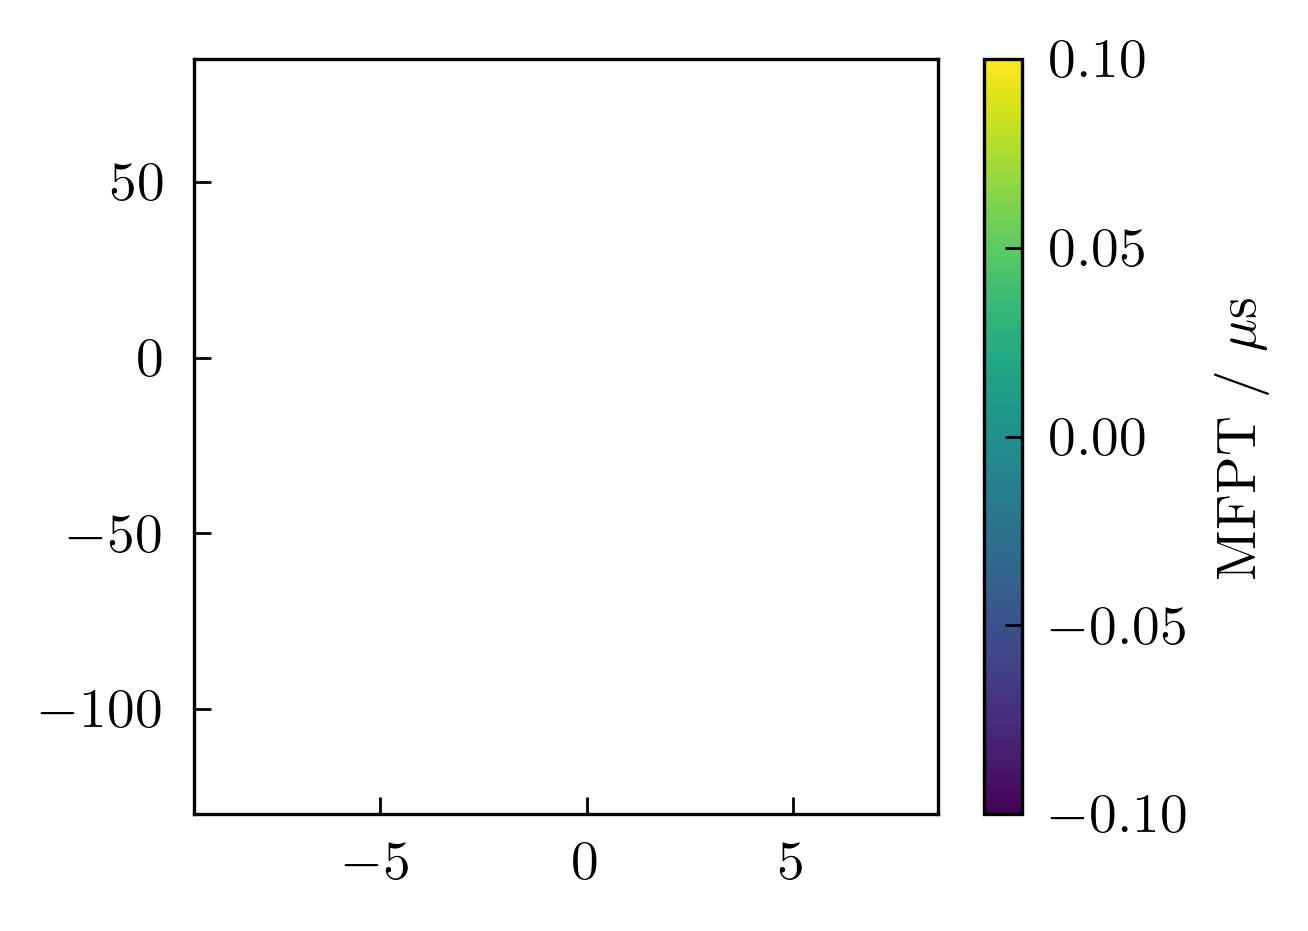

Epoch 74 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


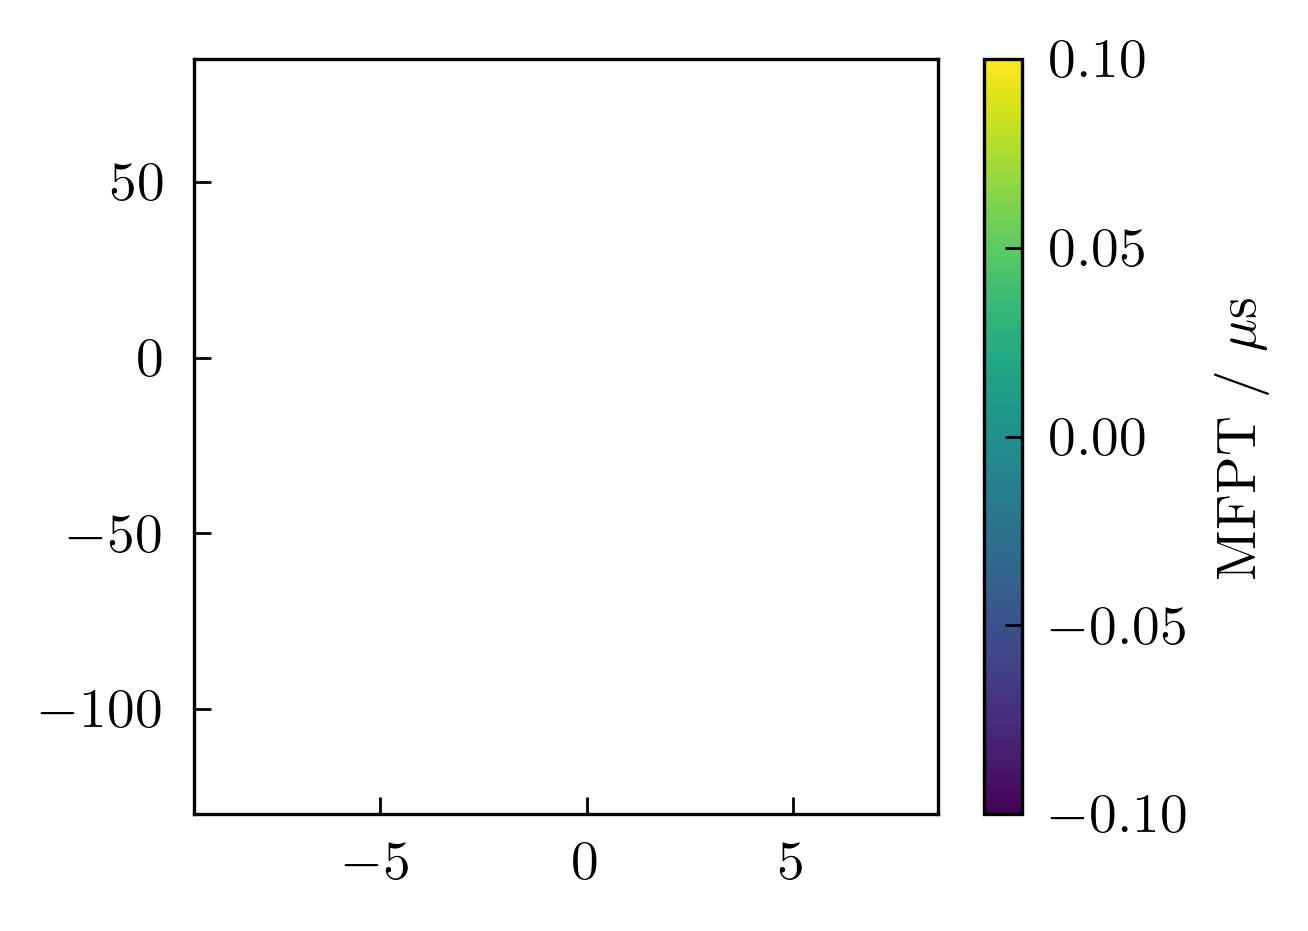

Epoch 75 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


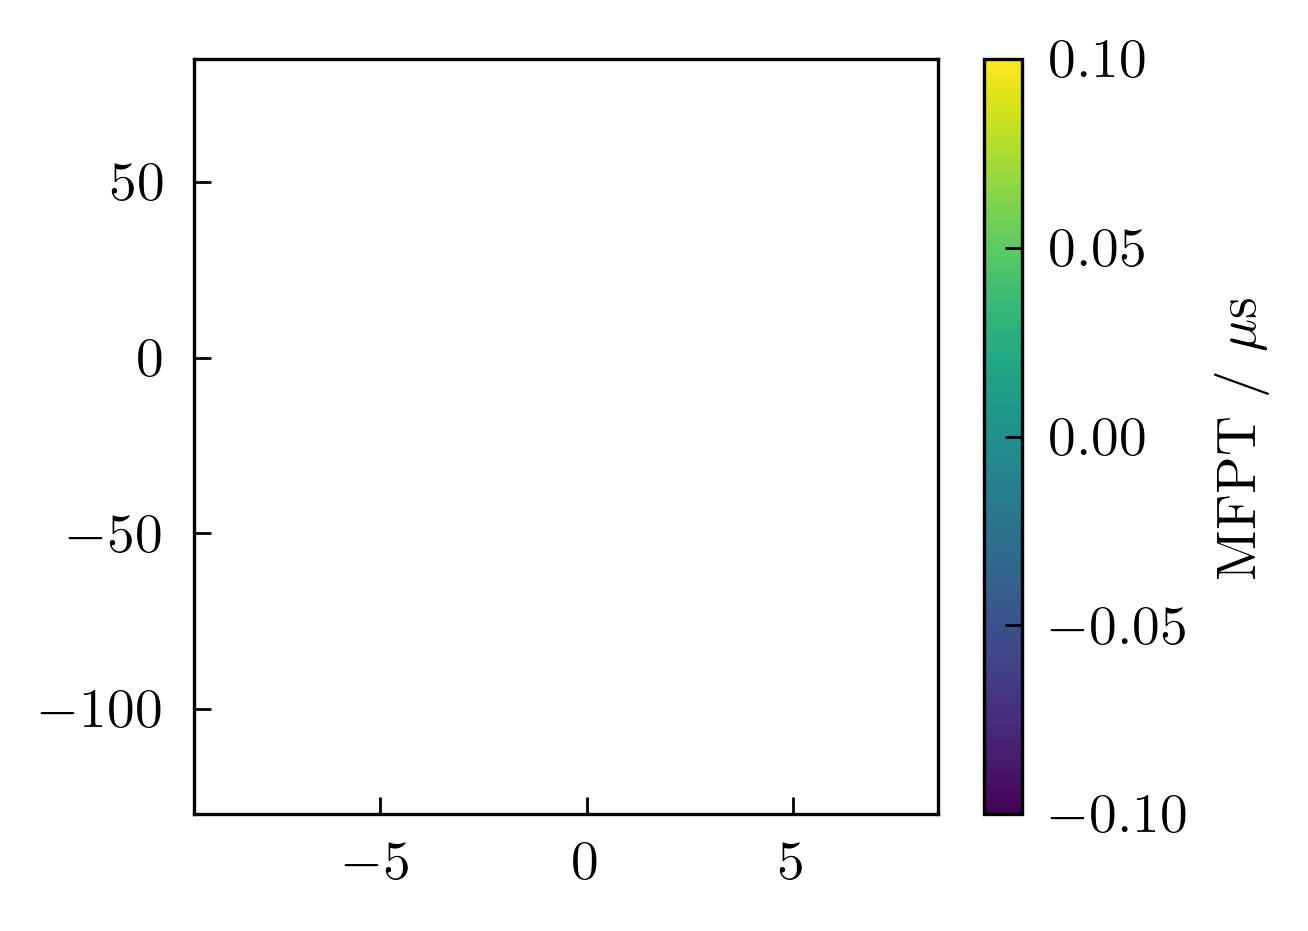

Epoch 76 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


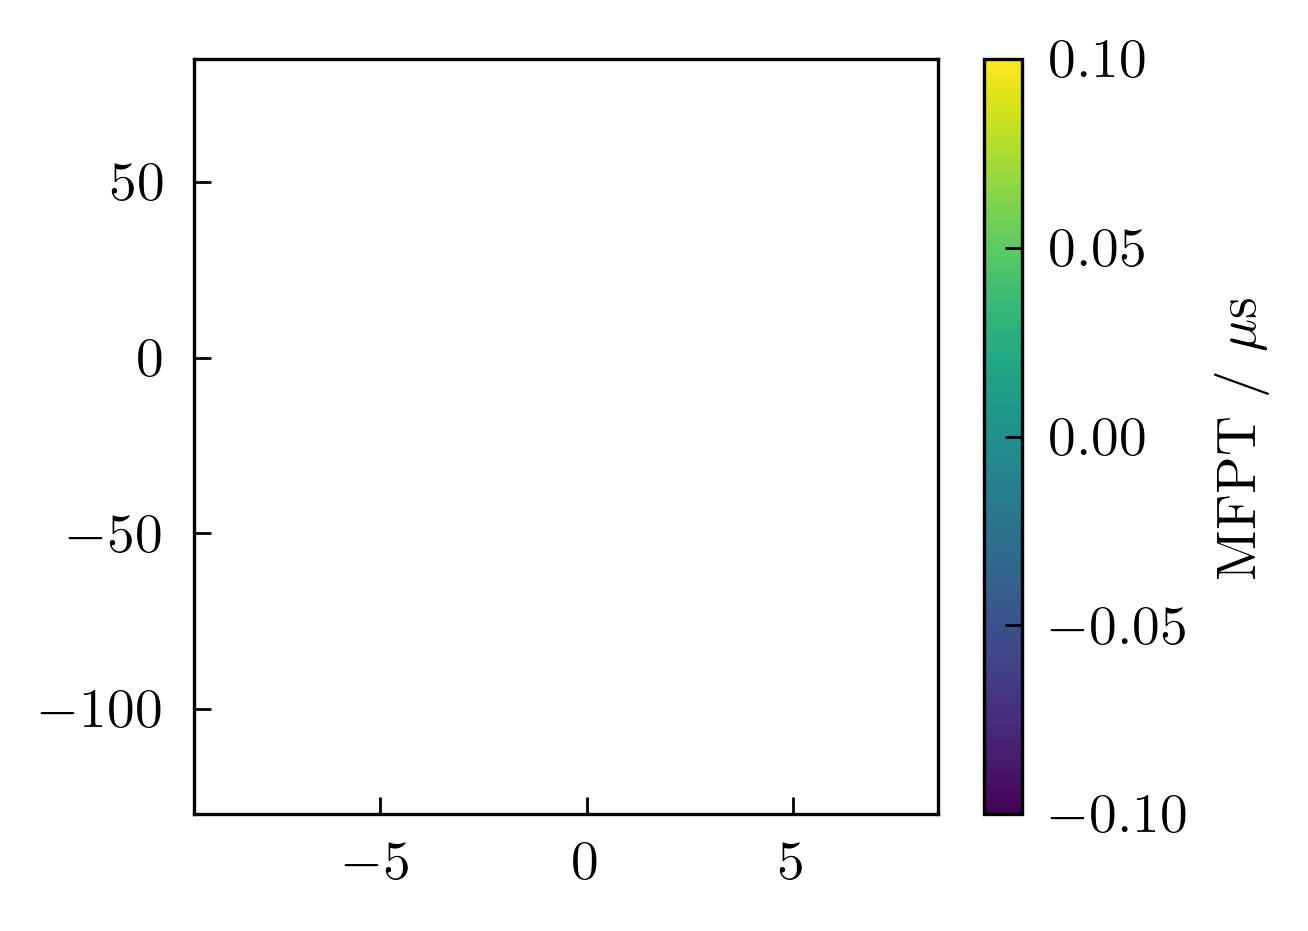

Epoch 77 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


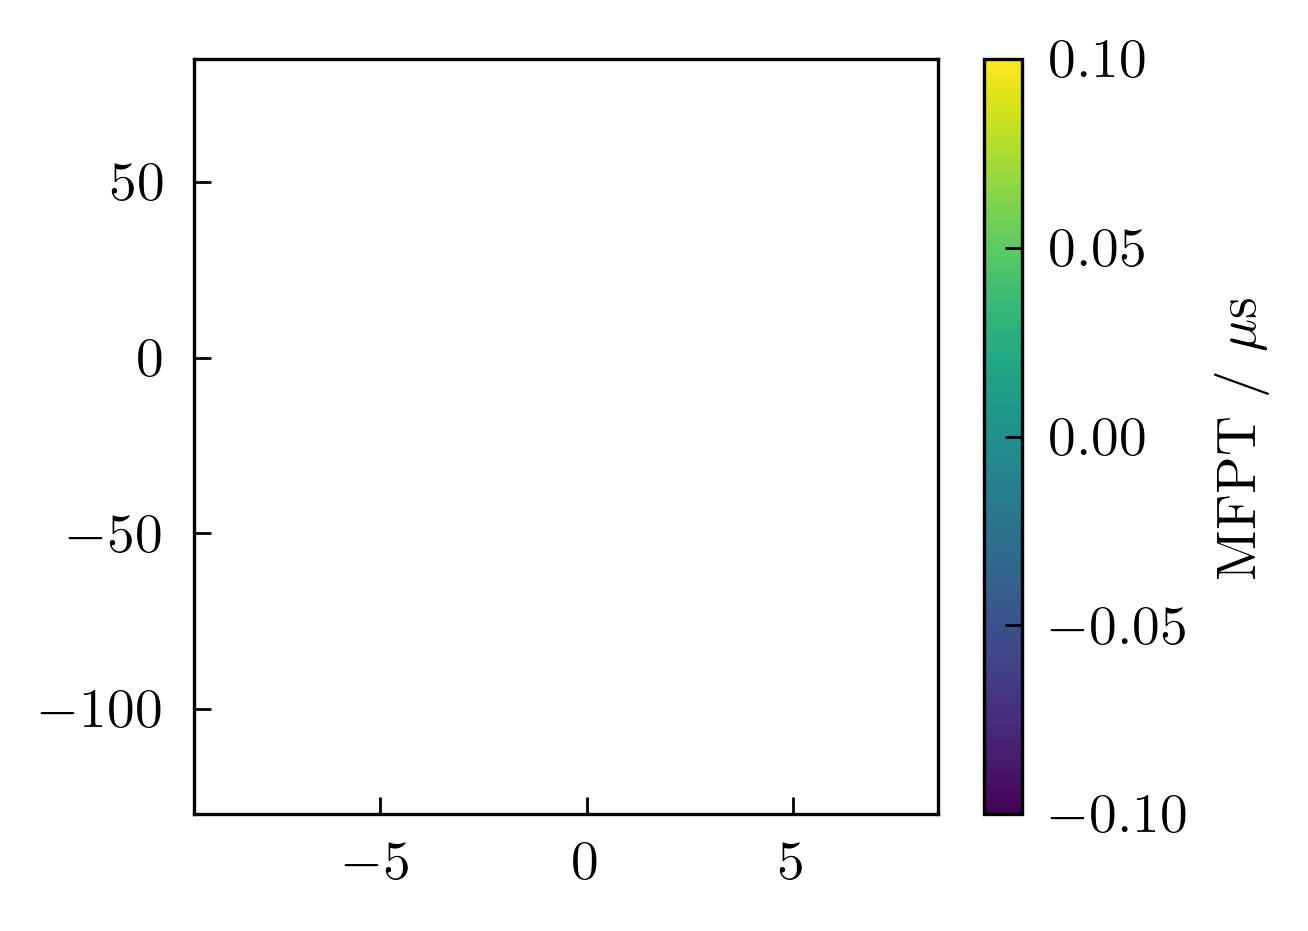

Epoch 78 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


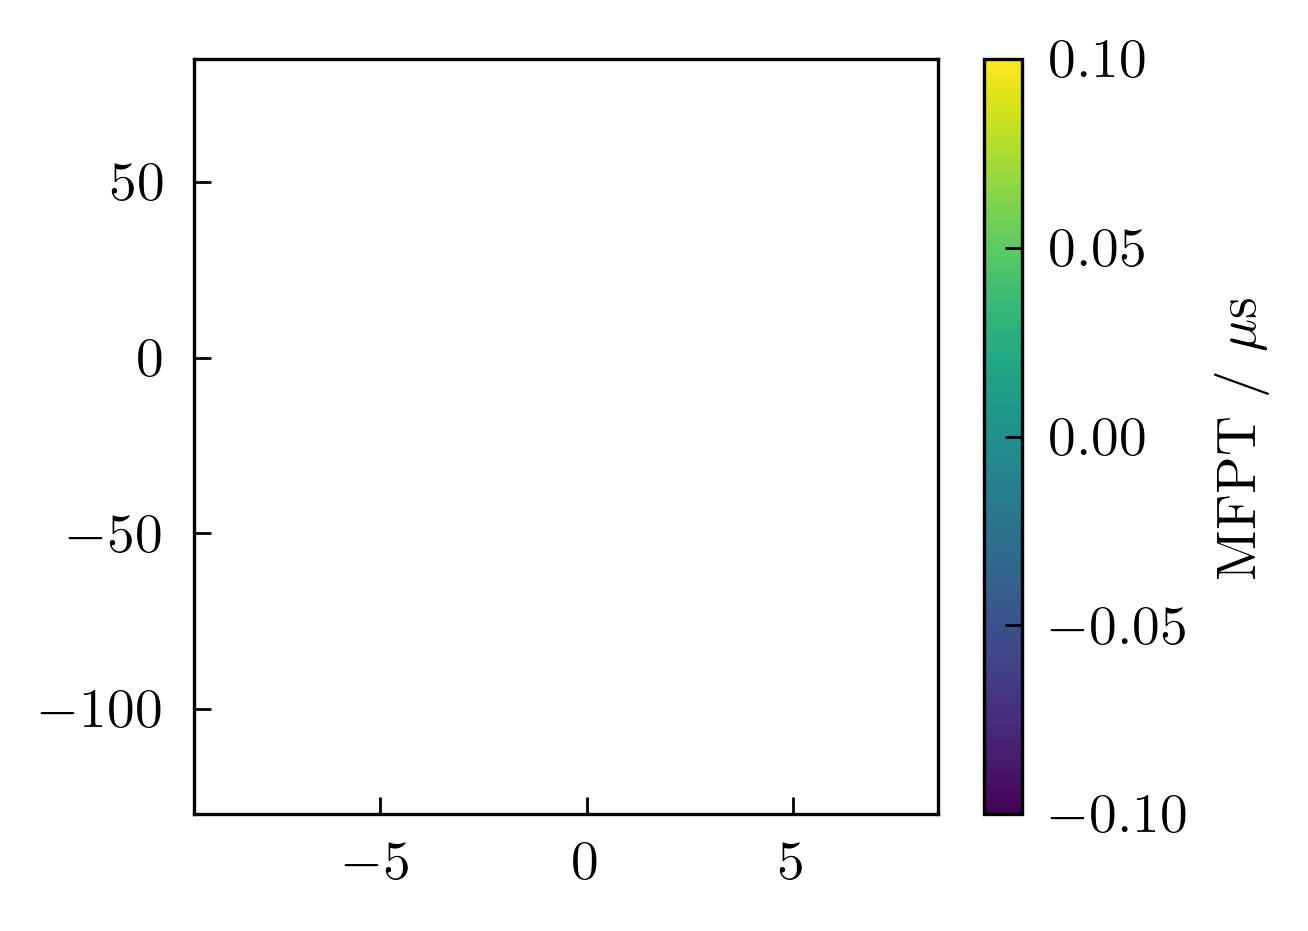

Epoch 79 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


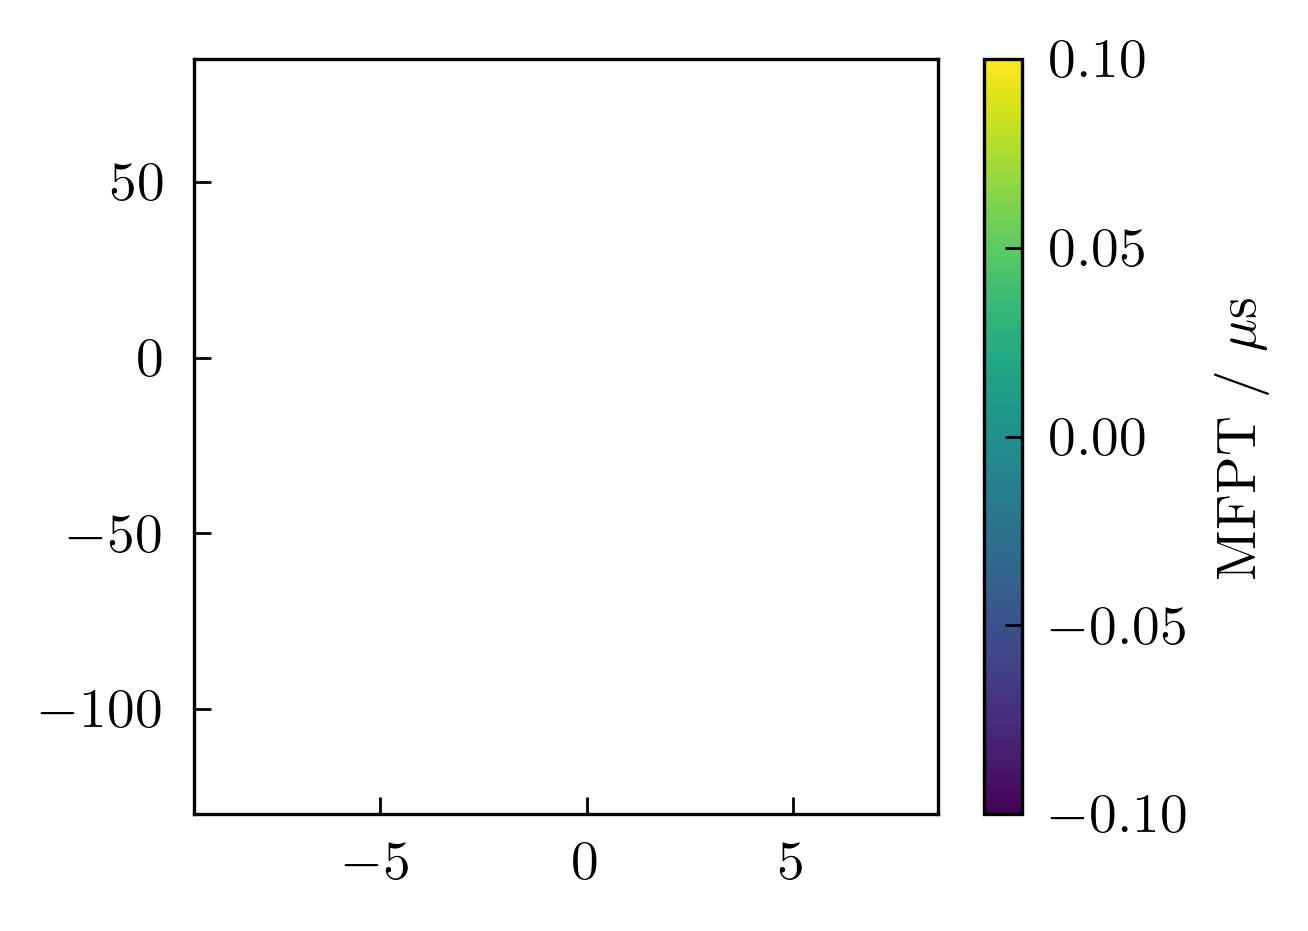

Epoch 87 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


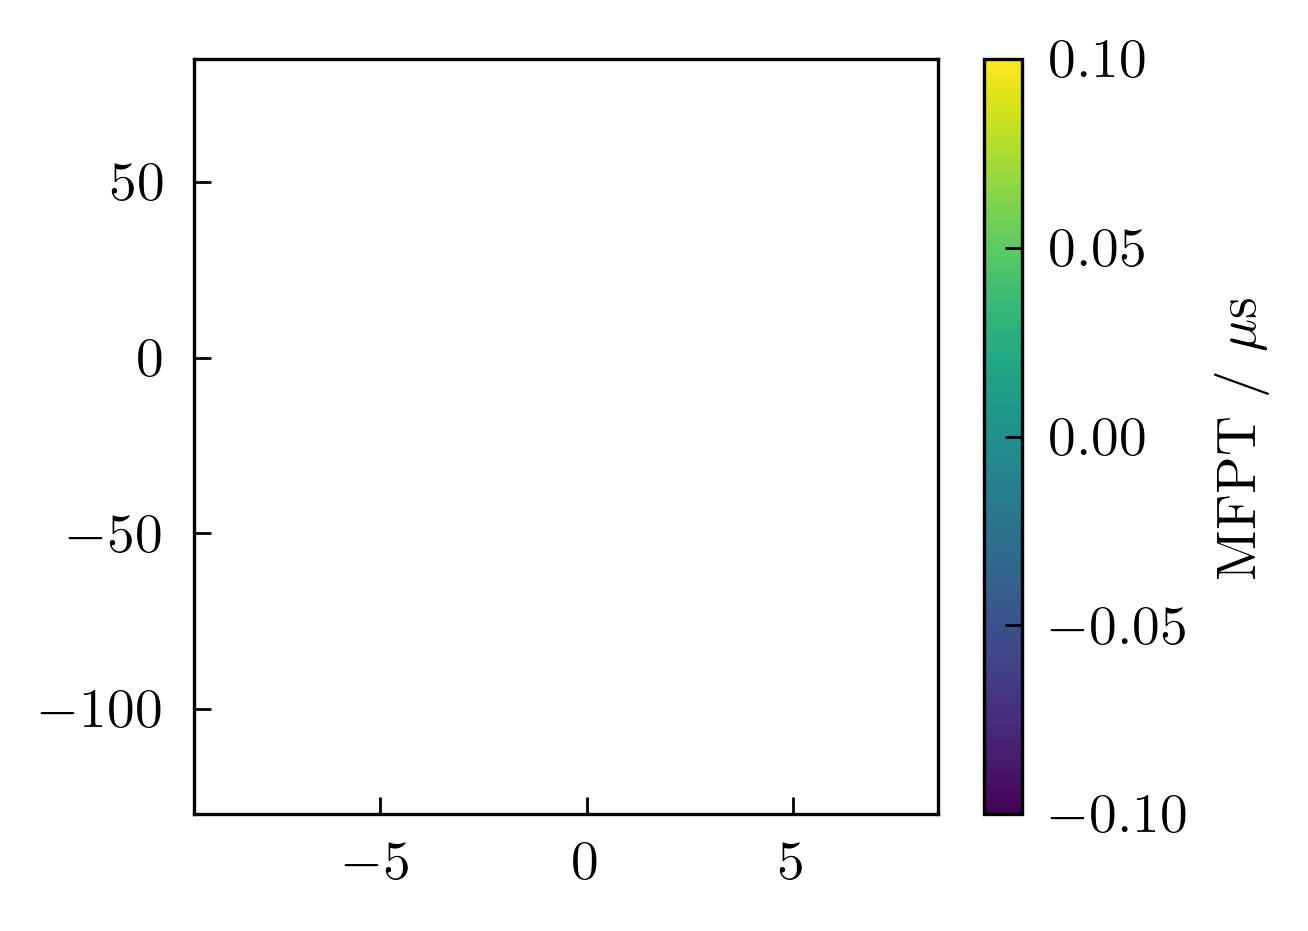

Epoch 88 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


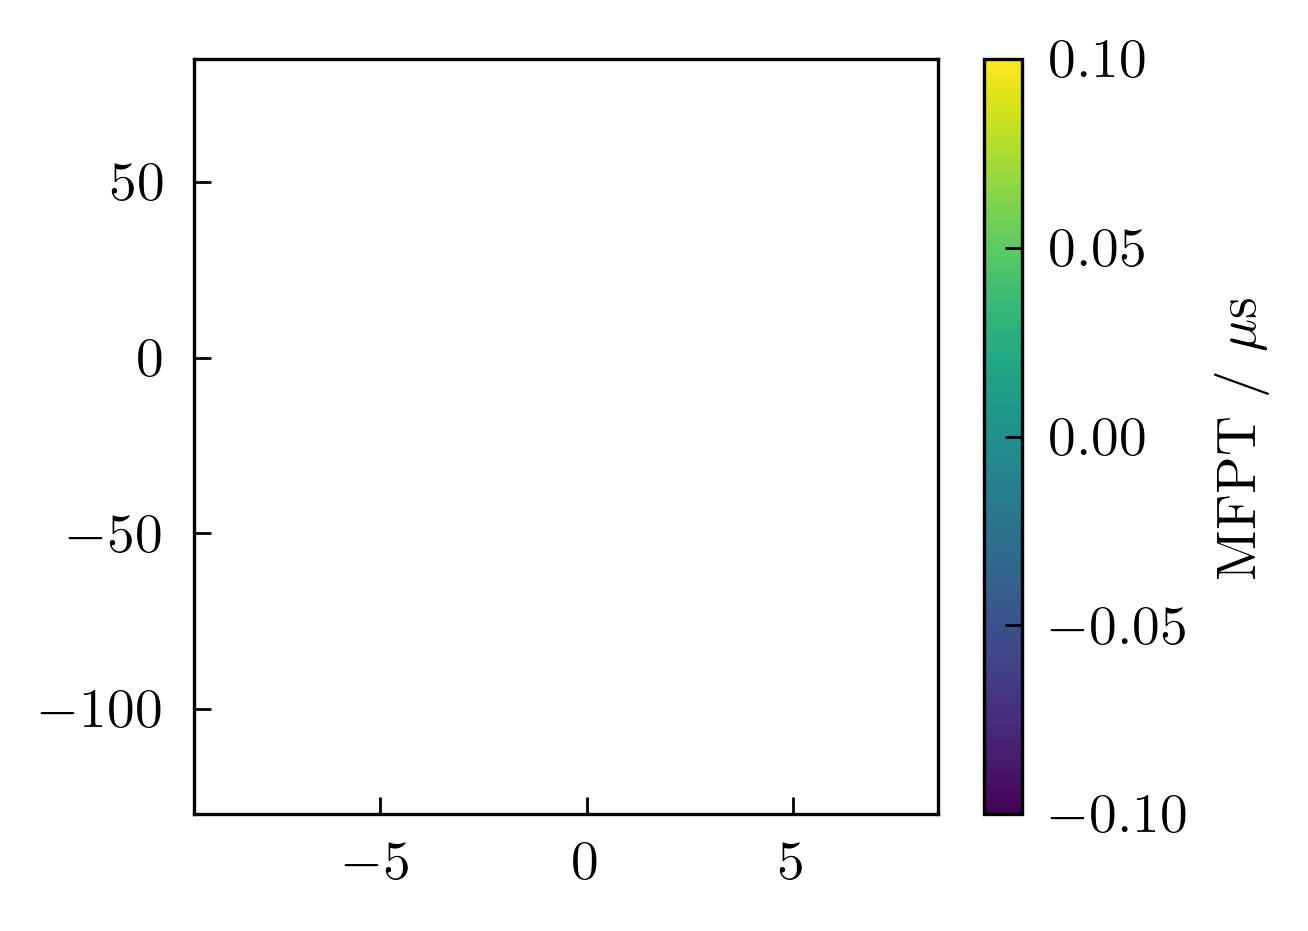

Epoch 89 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


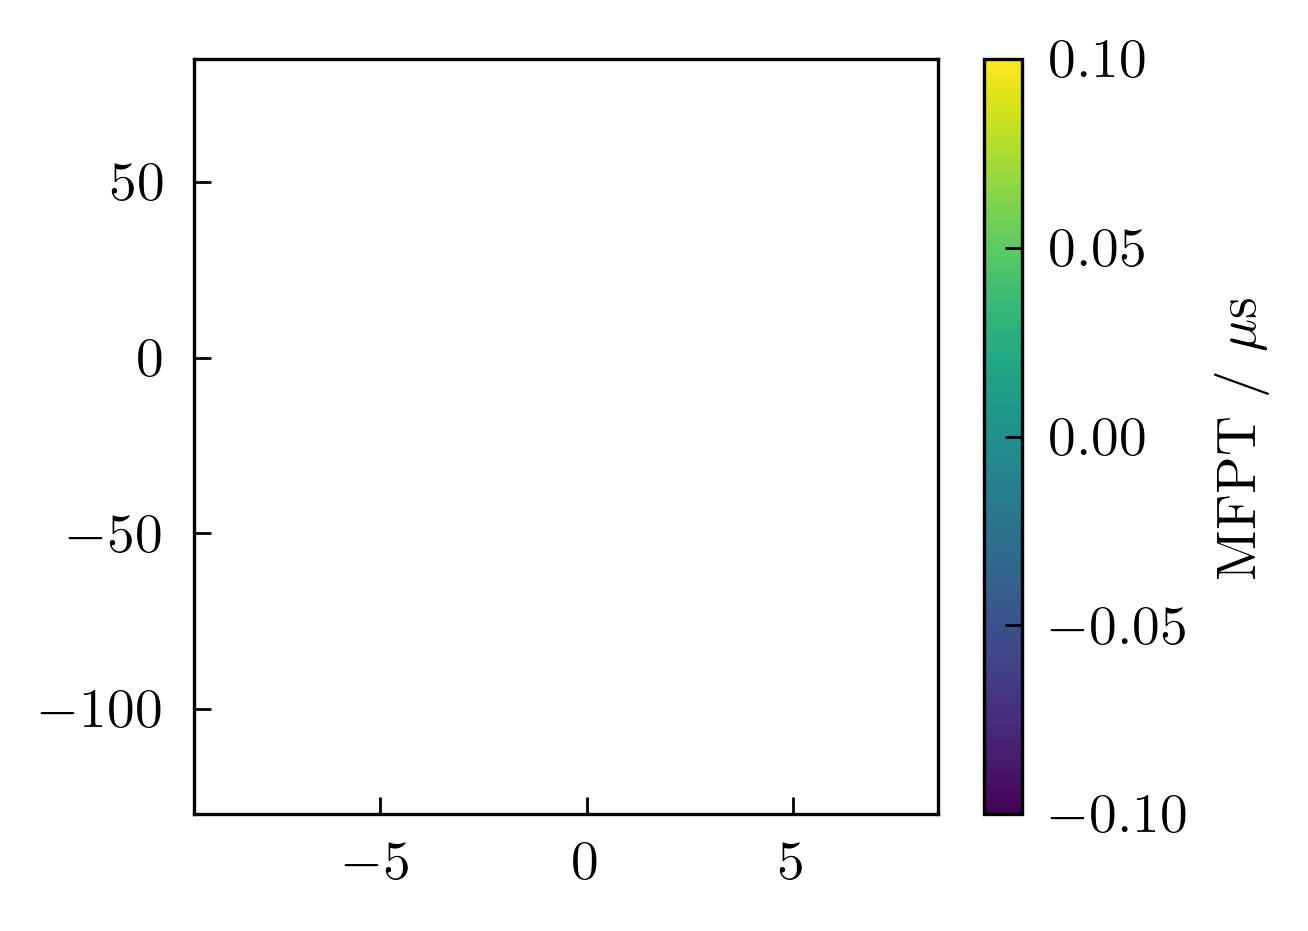

Epoch 90 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


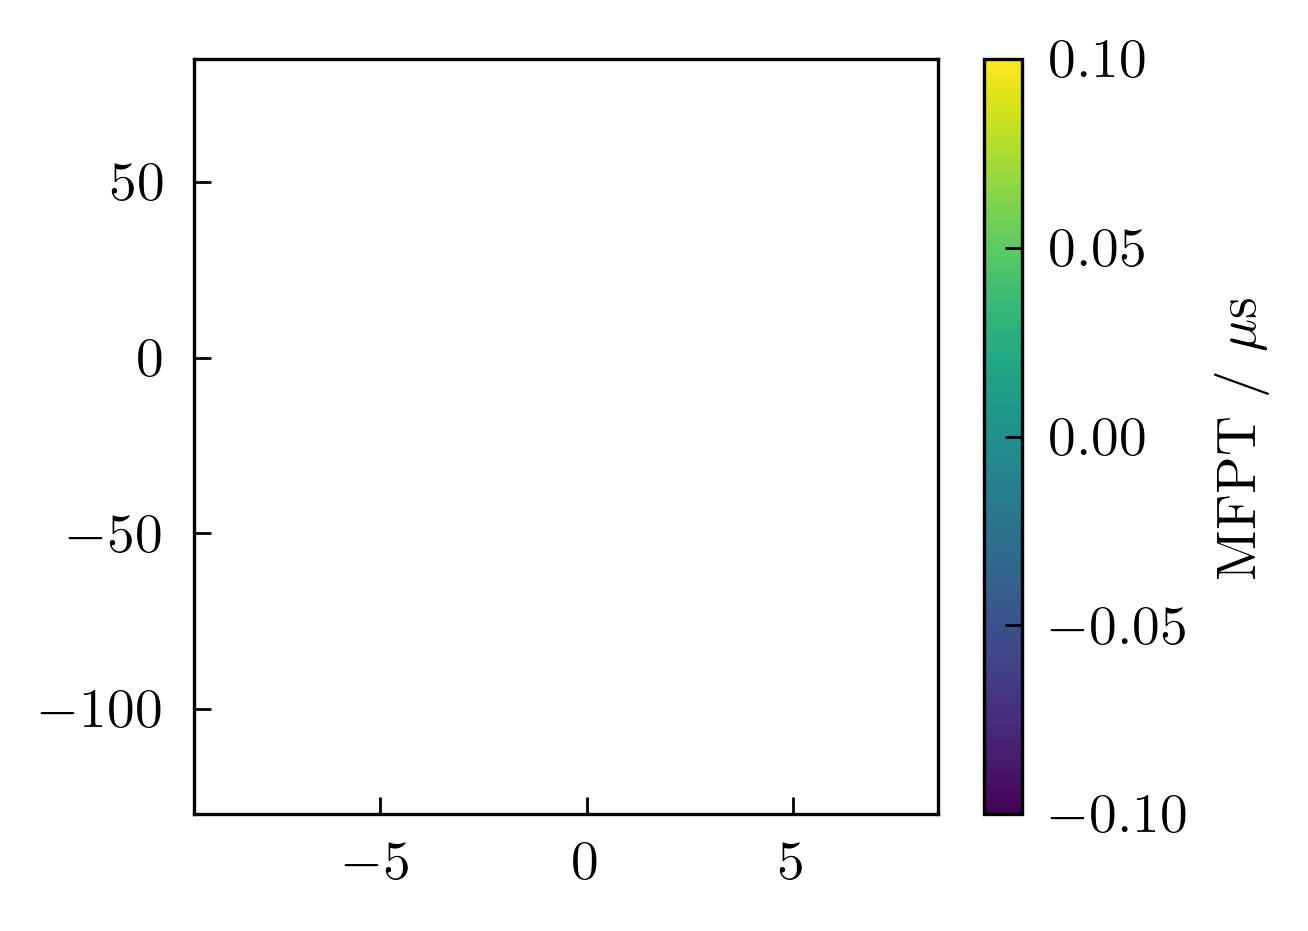

Epoch 91 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


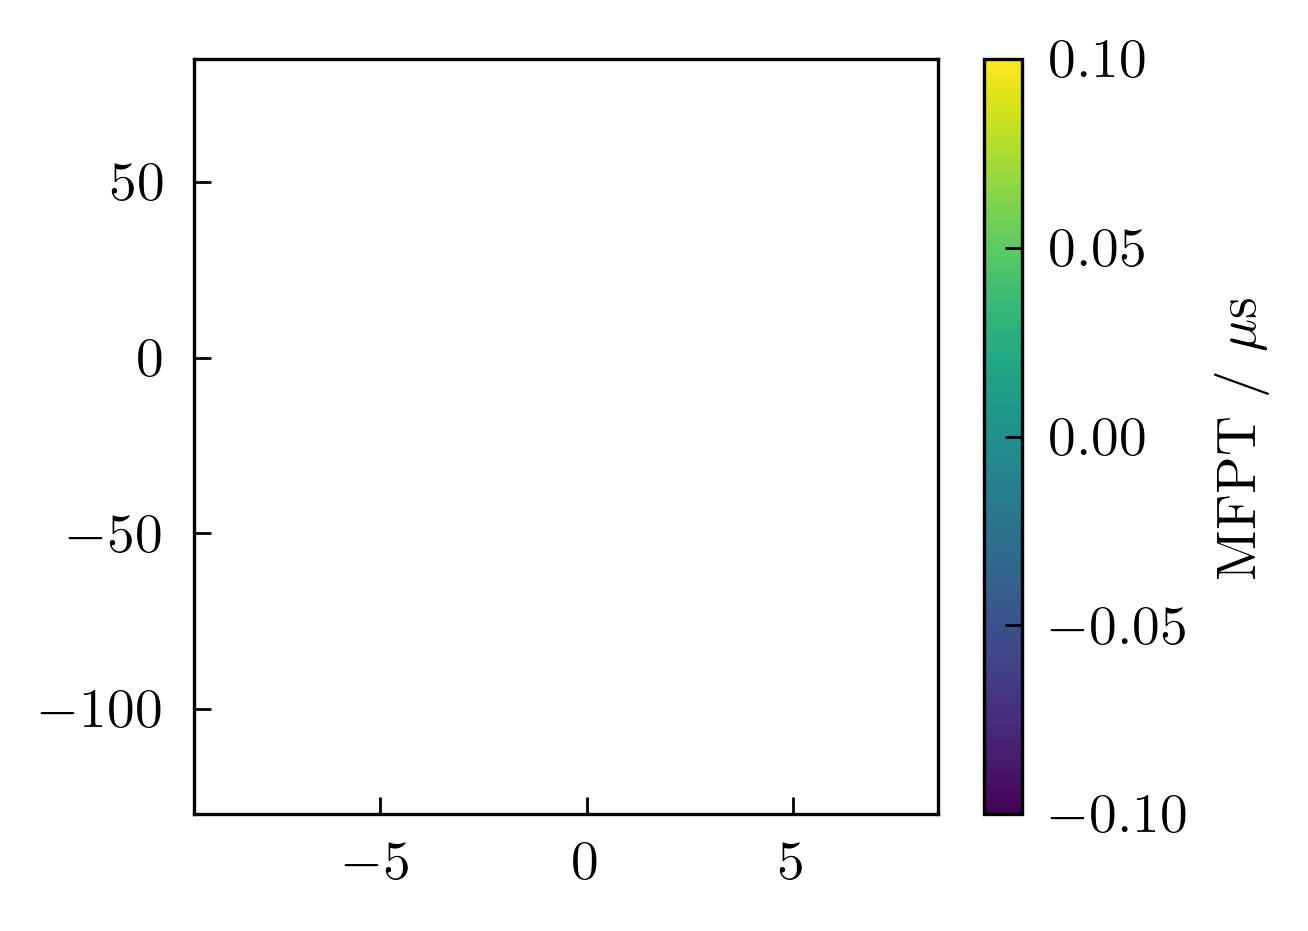

Epoch 92 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


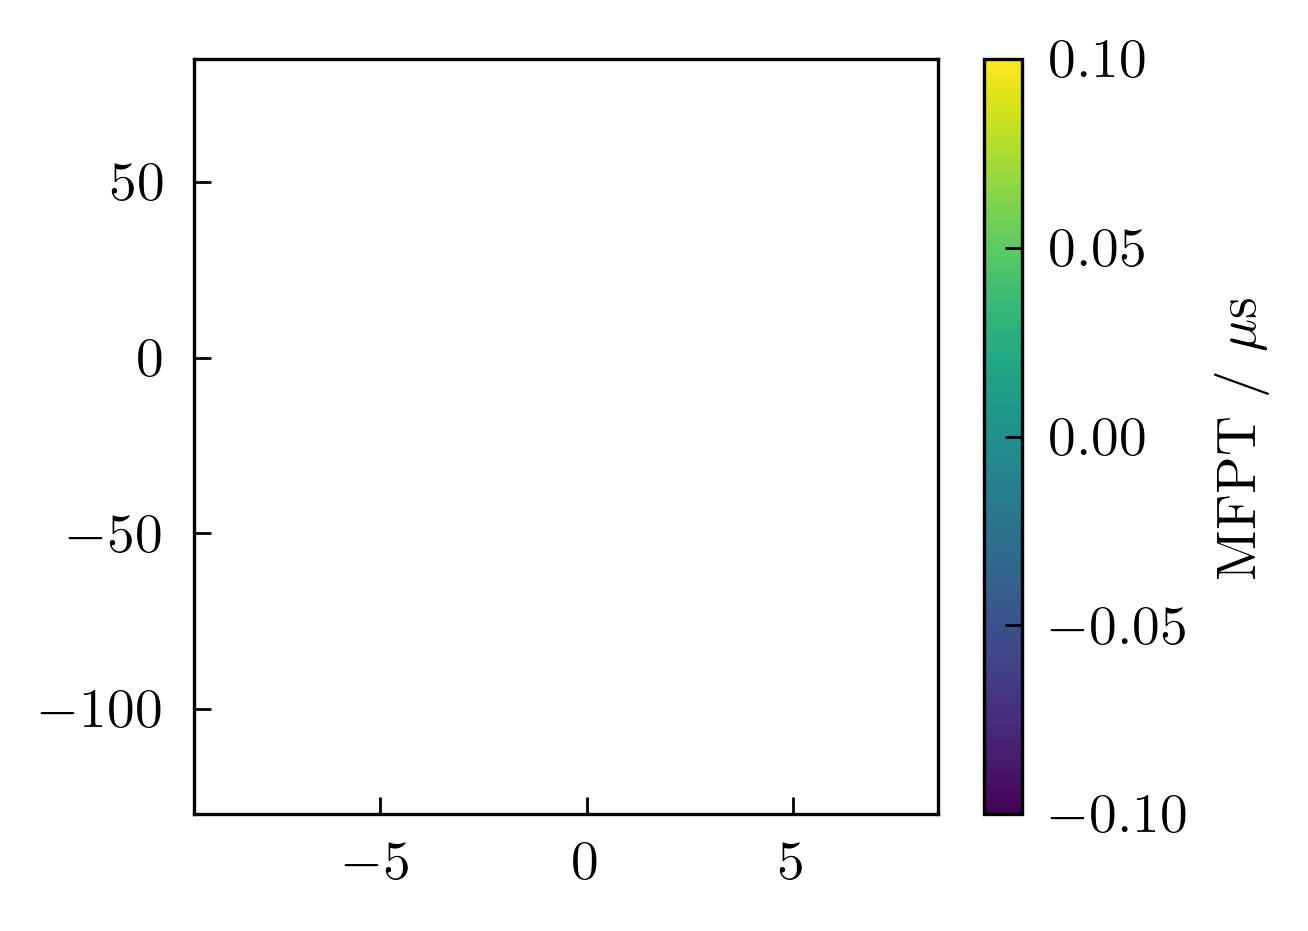

Epoch 93 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


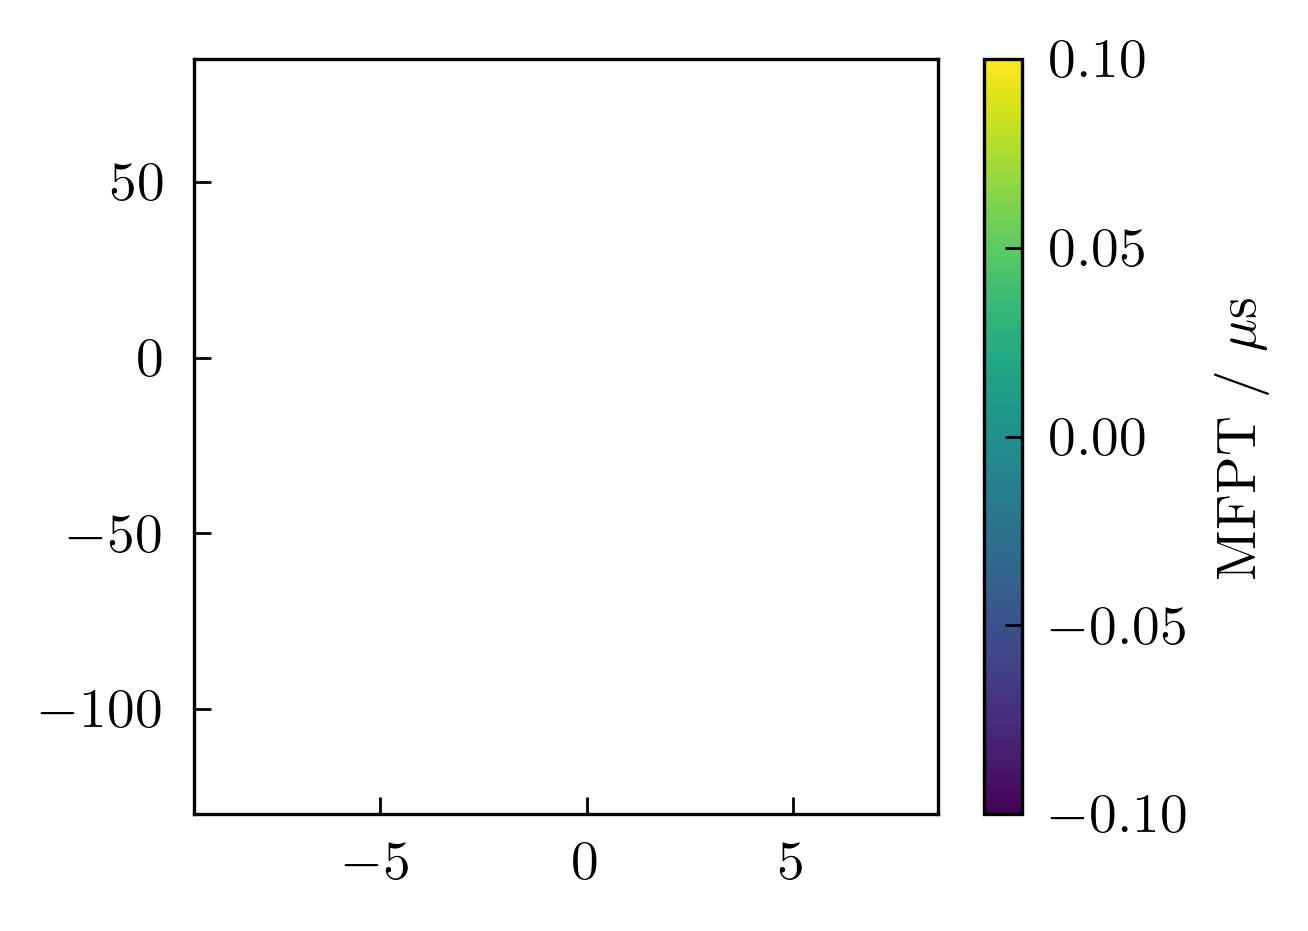

Epoch 94 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


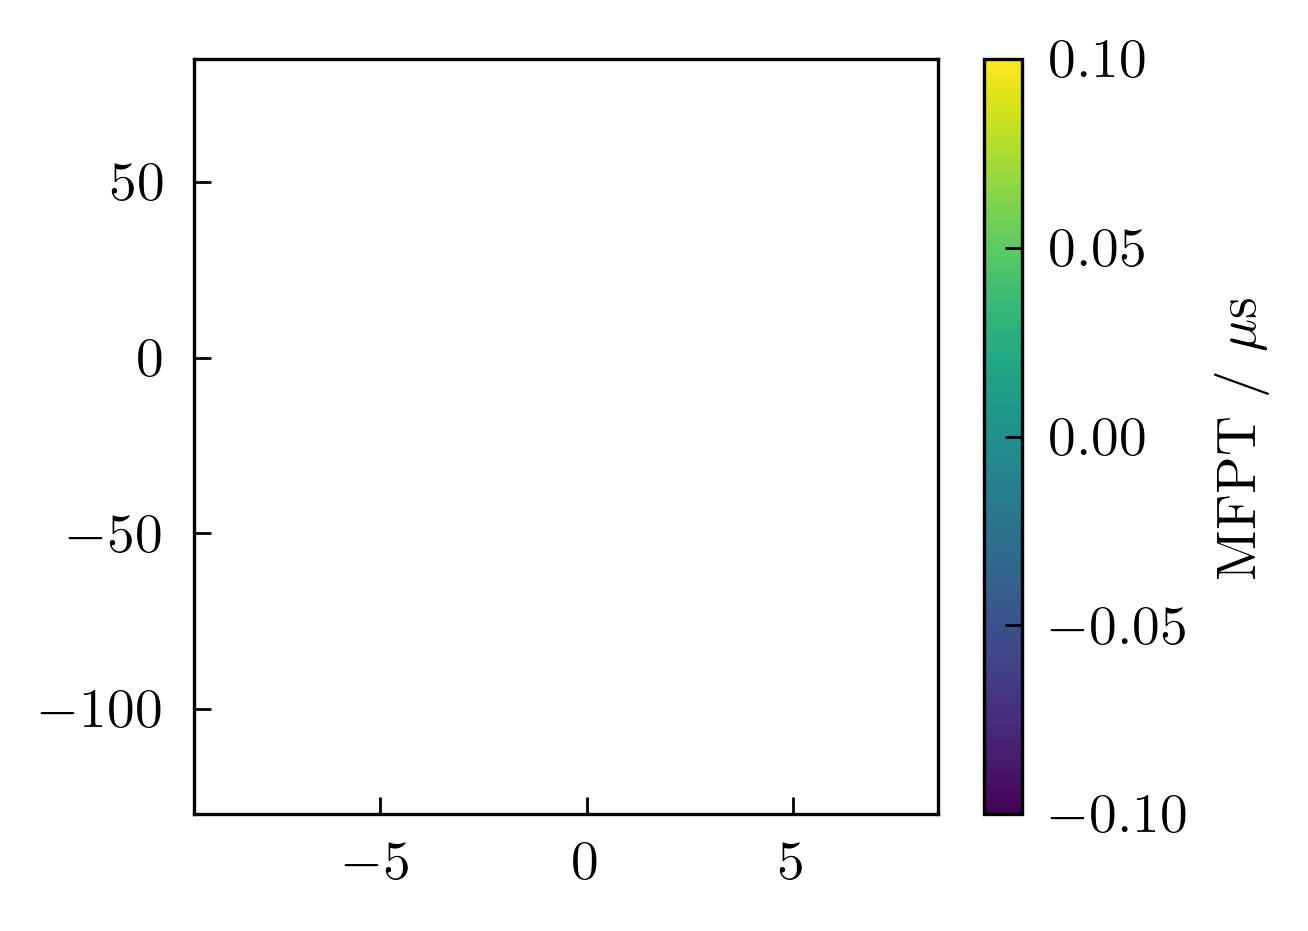

Epoch 95 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


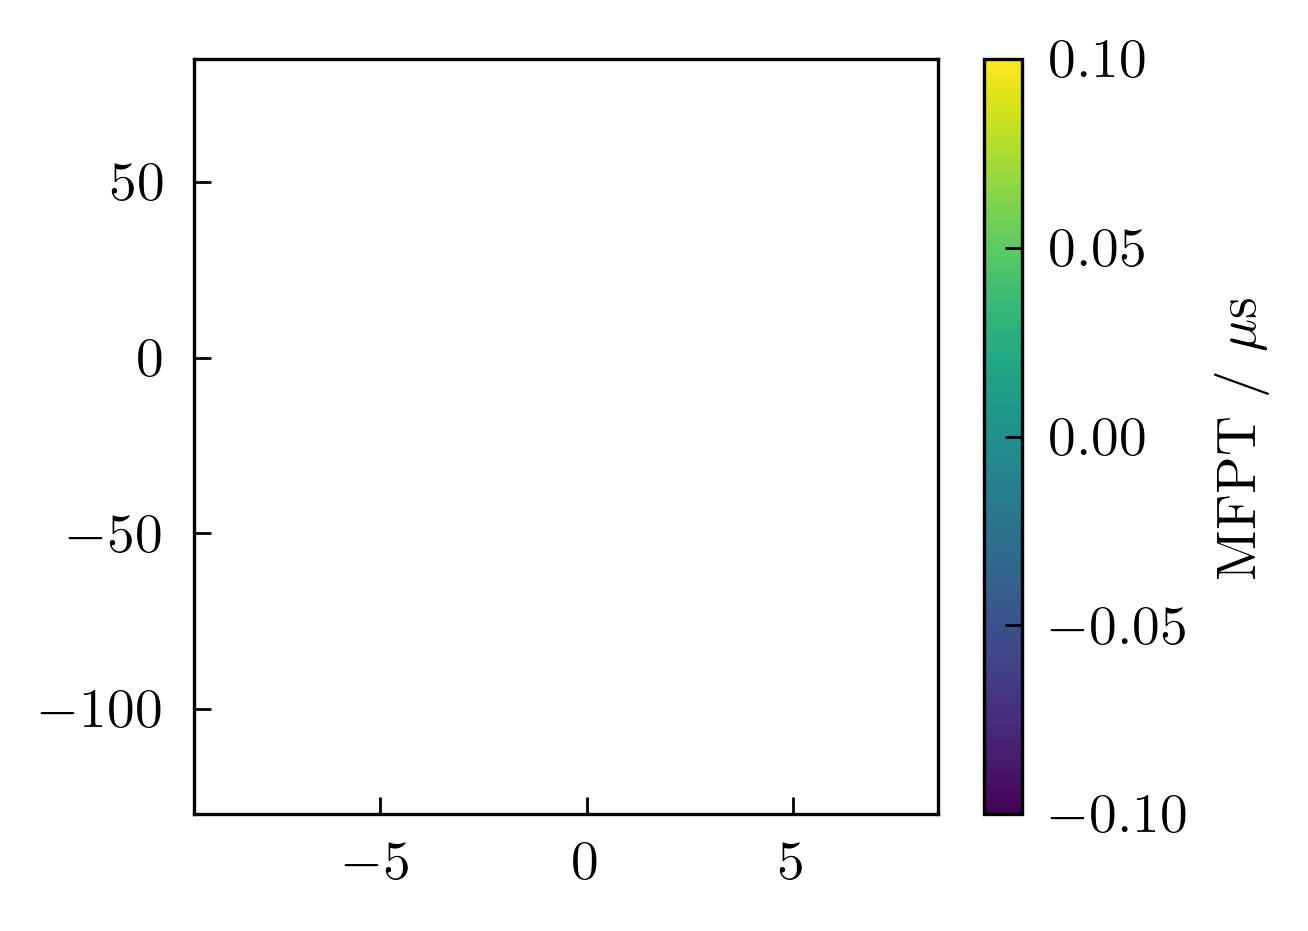

Epoch 96 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


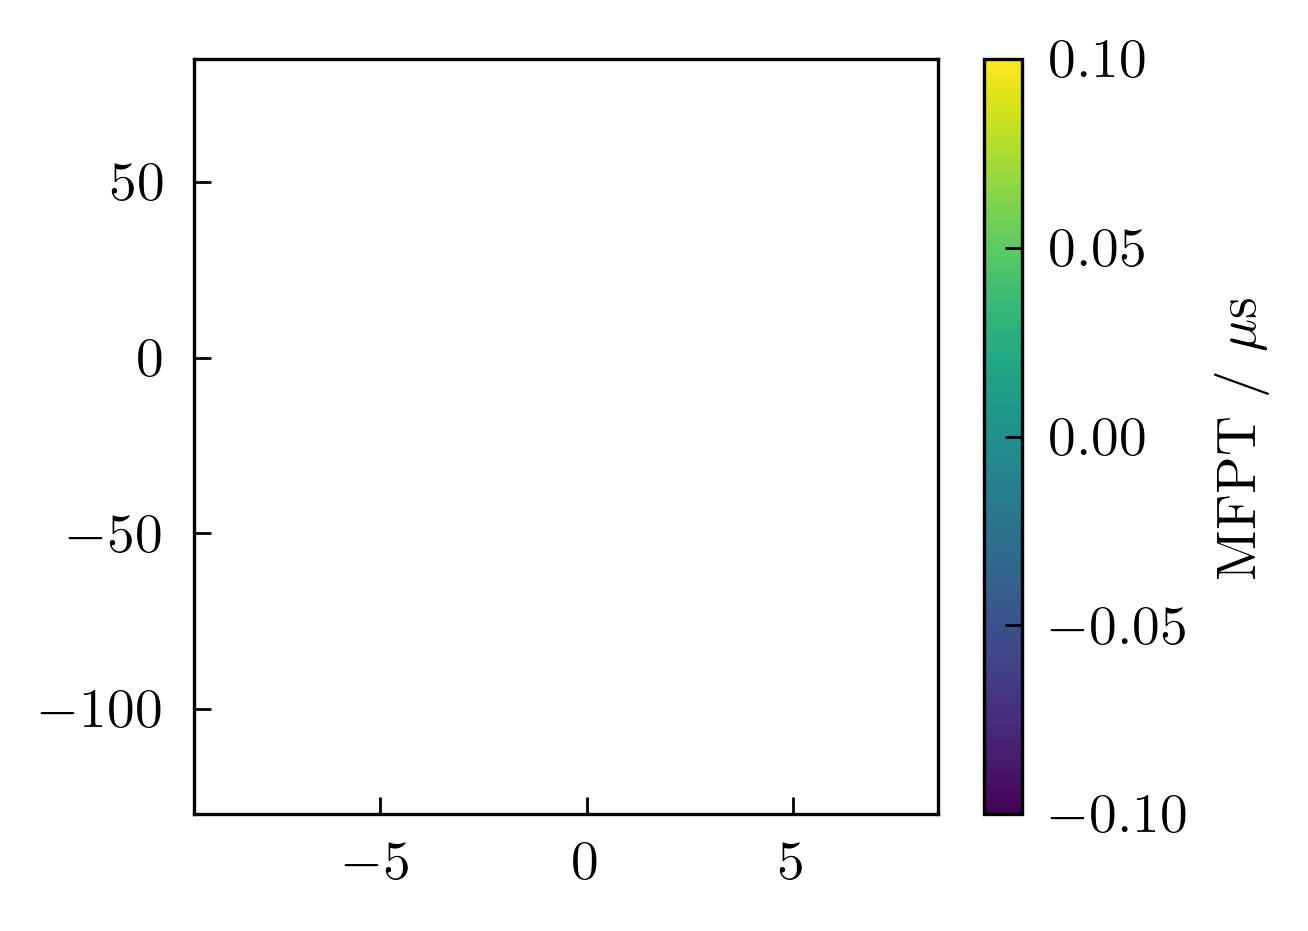

Epoch 97 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


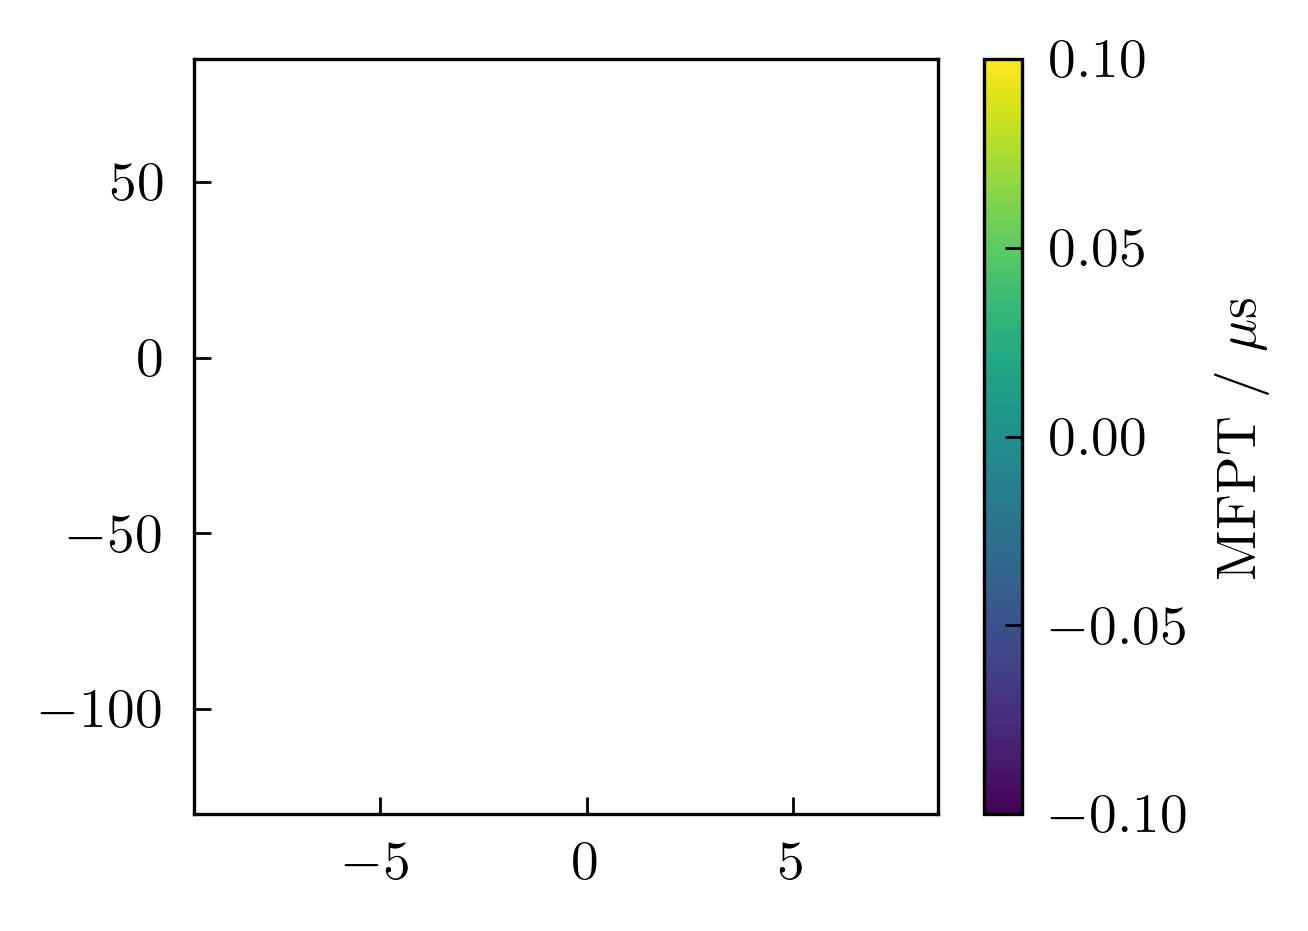

Epoch 98 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


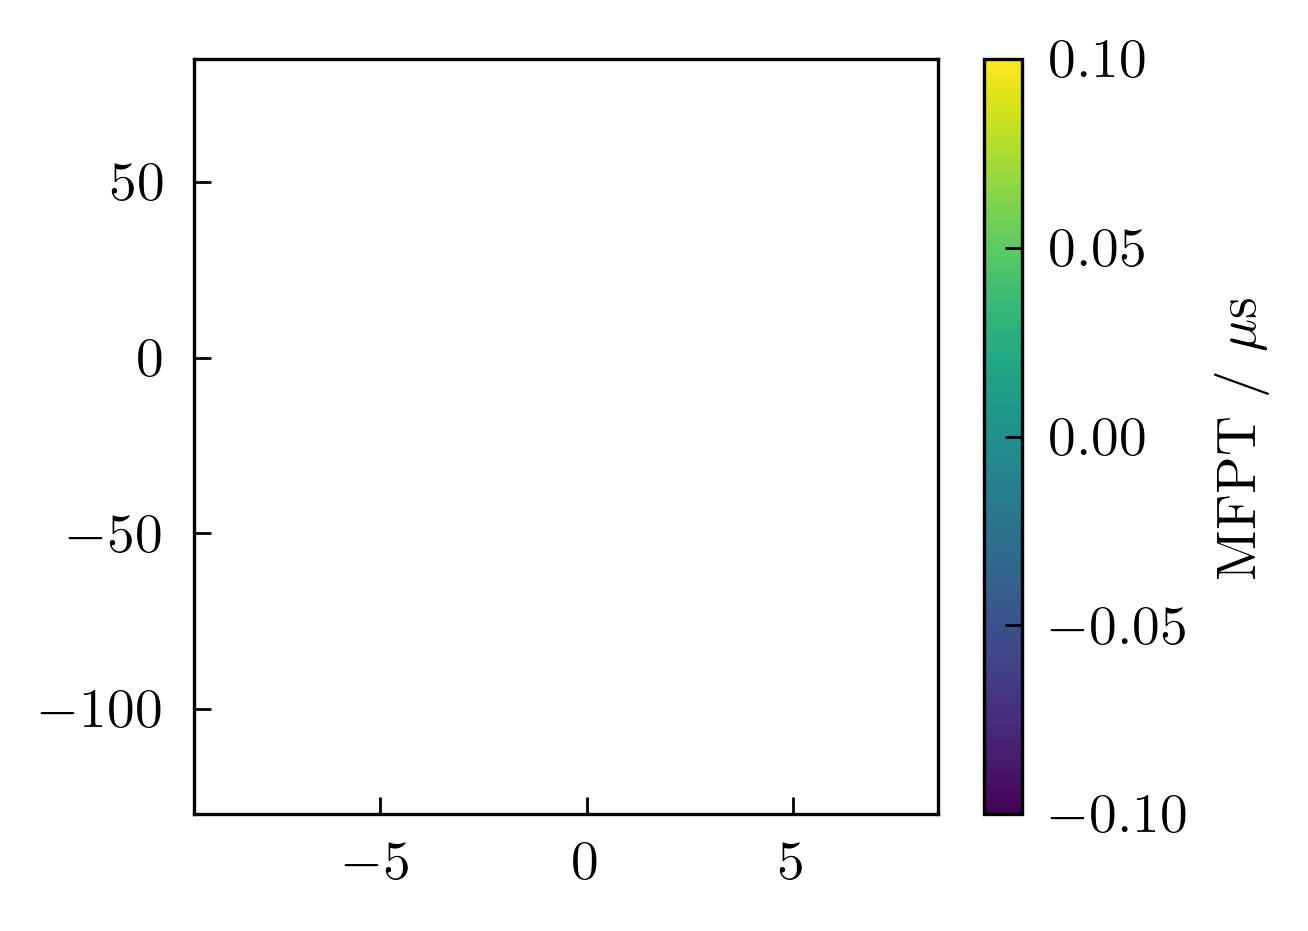

Epoch 99 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


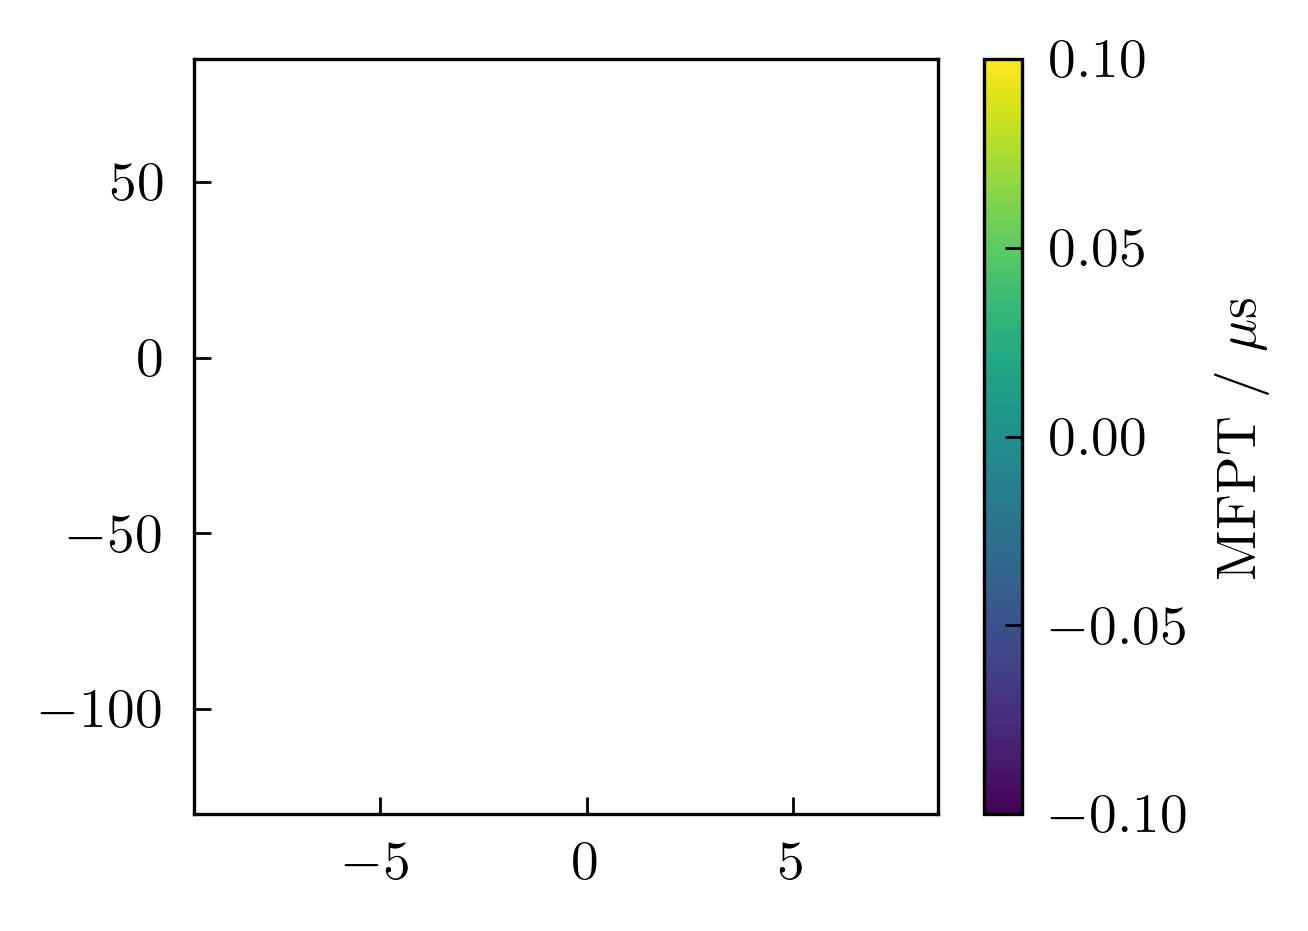

Epoch 100 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


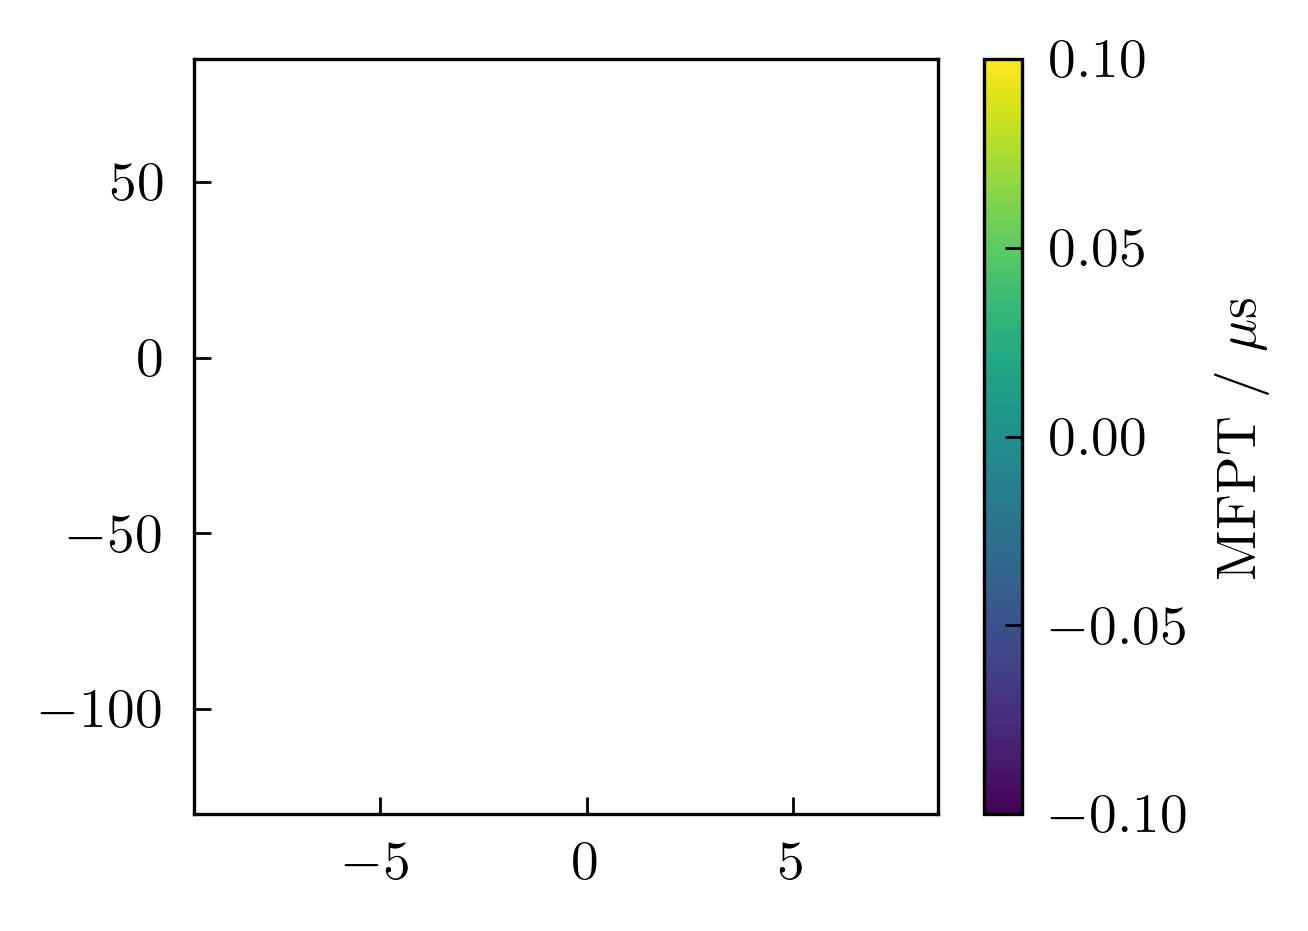

Epoch 101 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


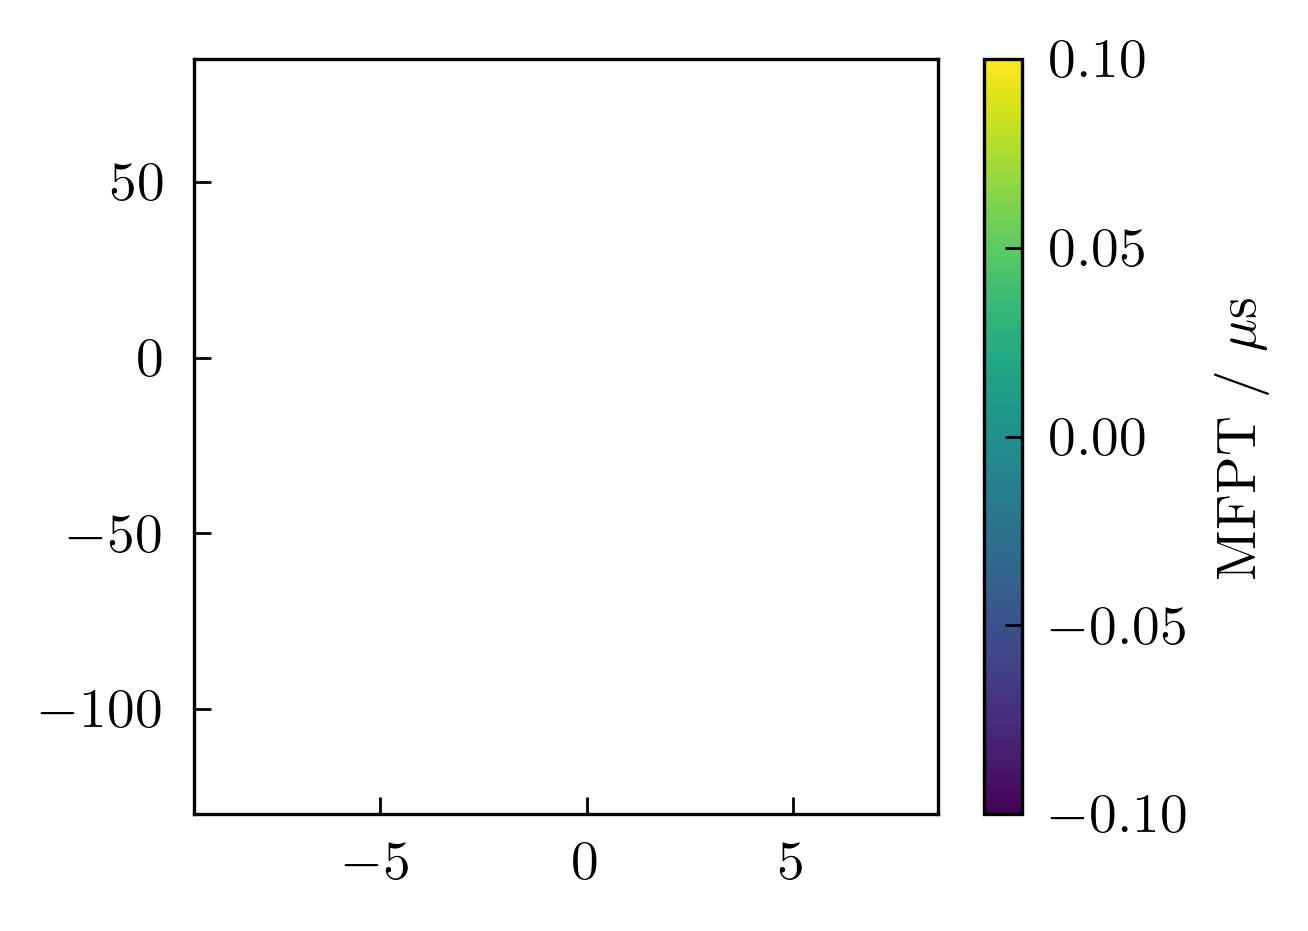

Epoch 102 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


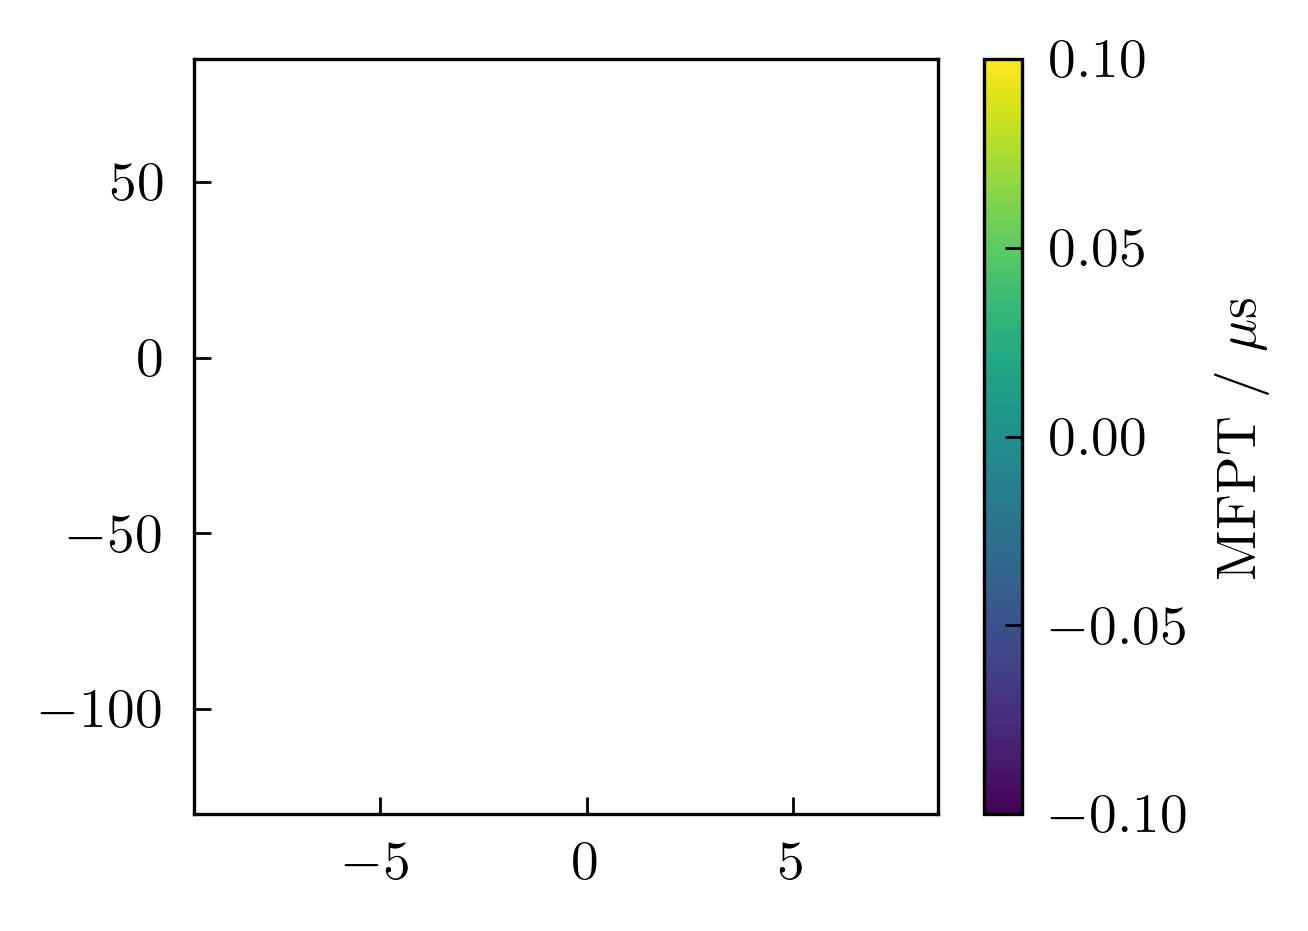

Epoch 103 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


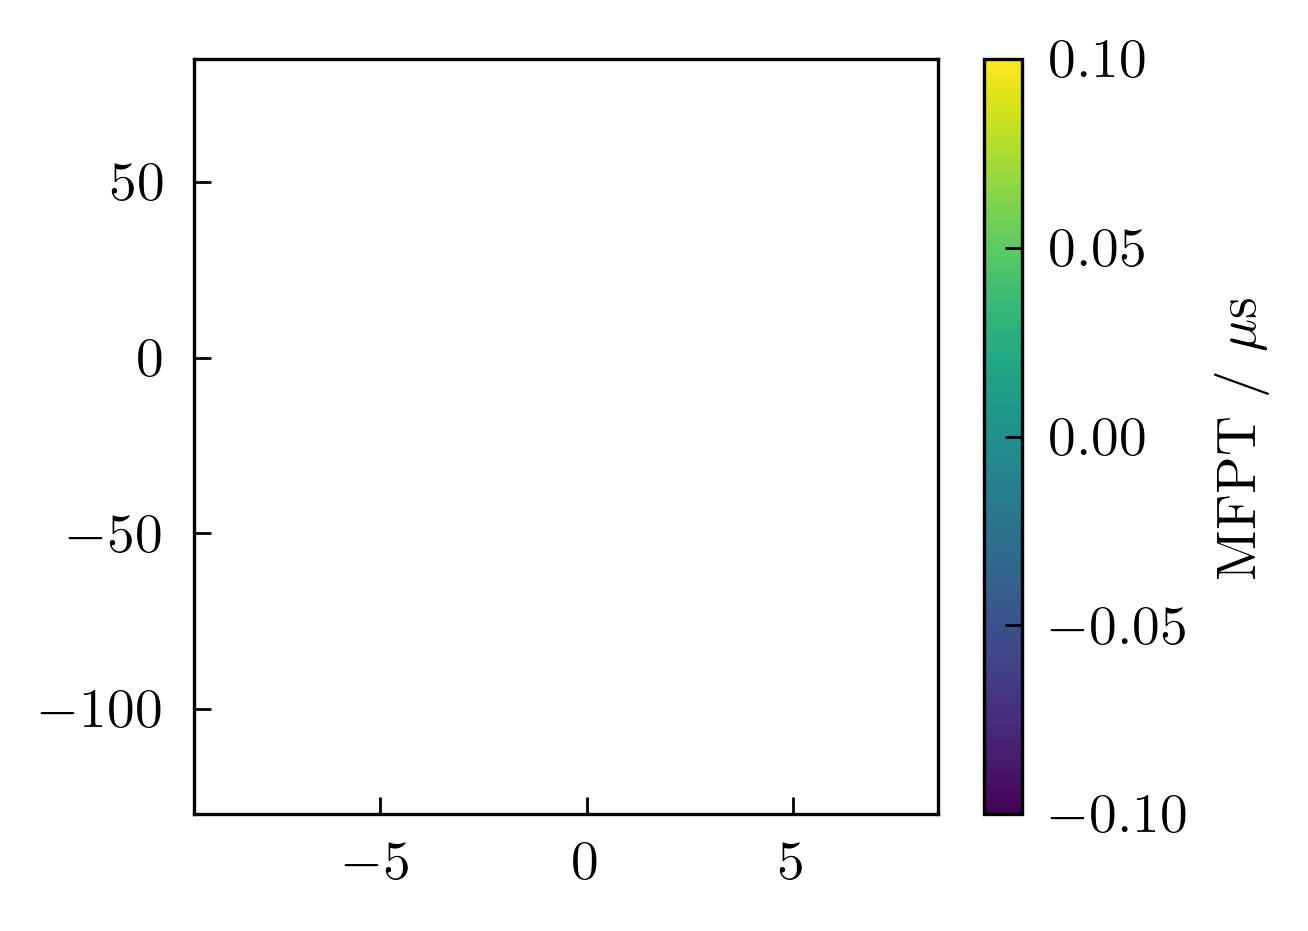

Epoch 104 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


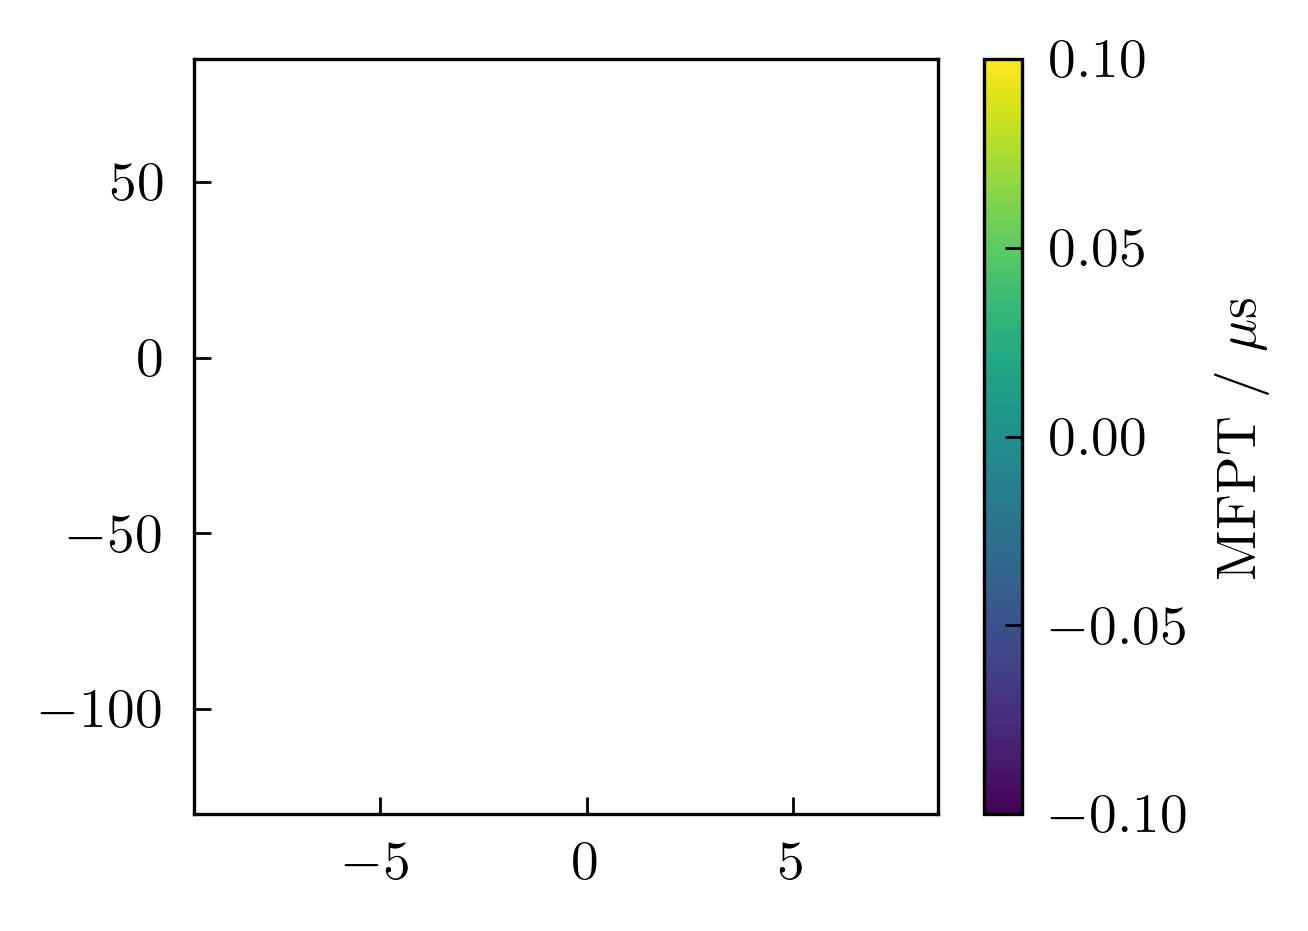

Epoch 105 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


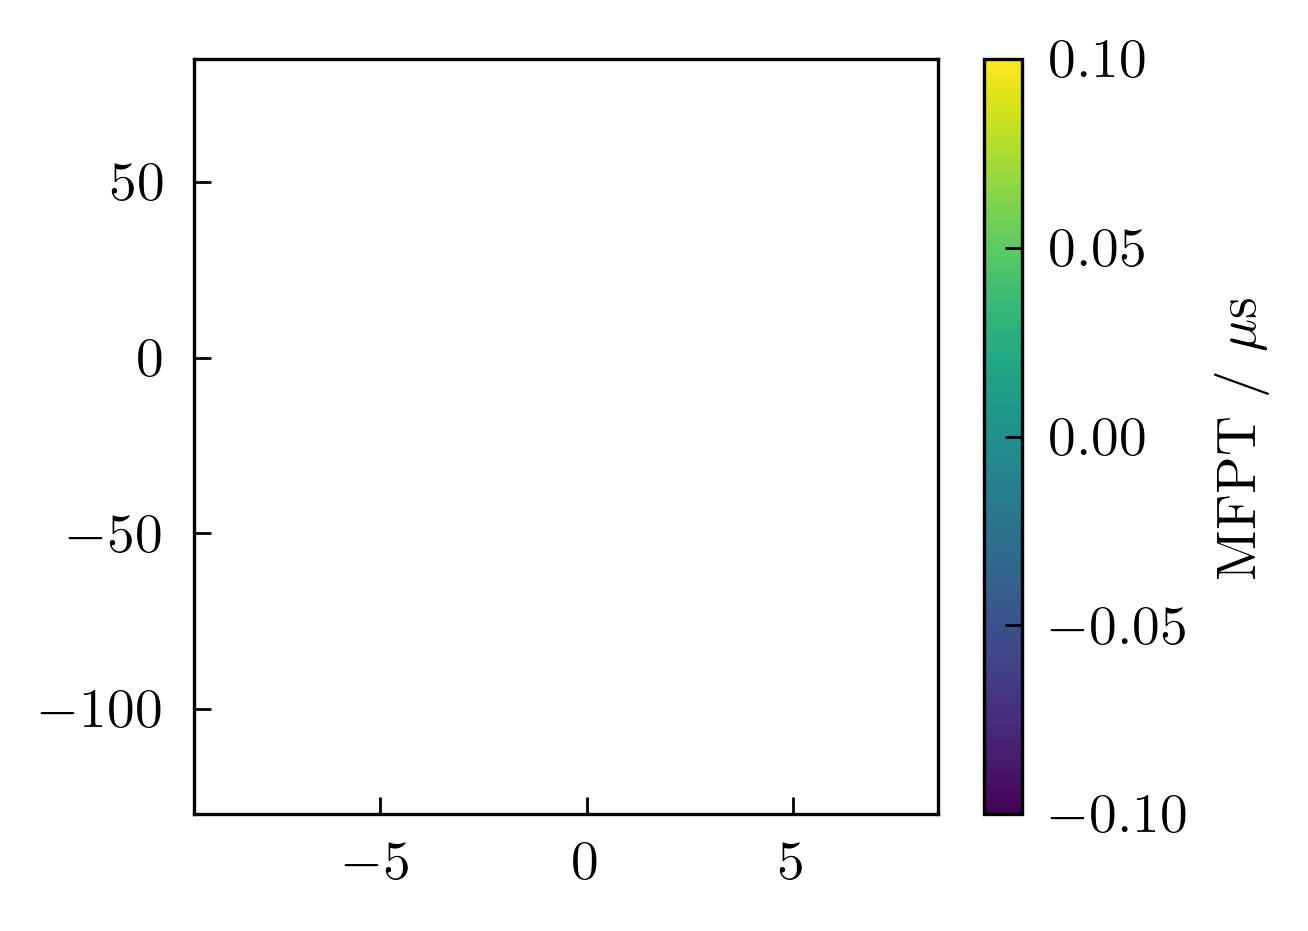

Epoch 106 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


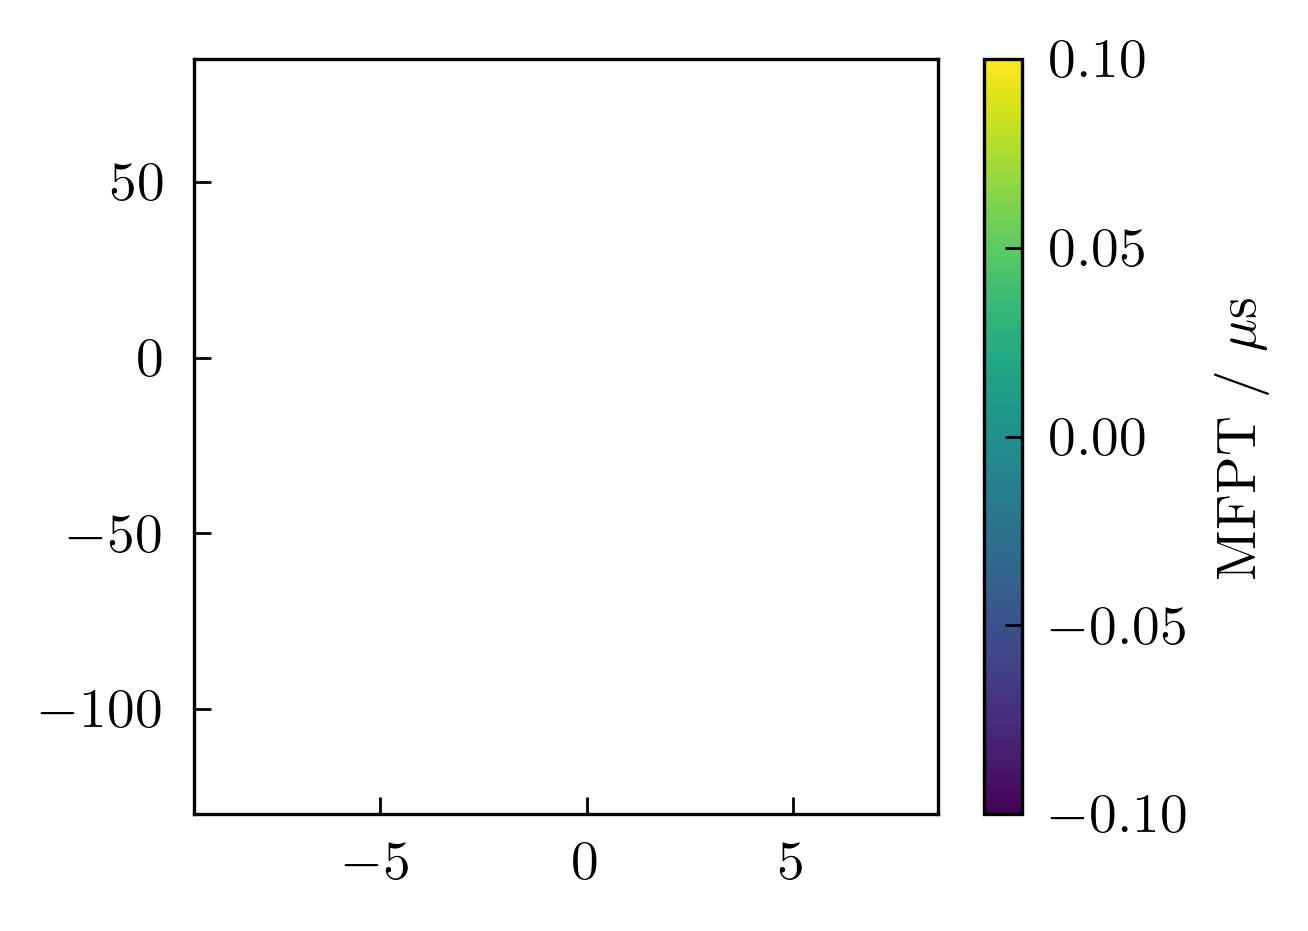

Epoch 107 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]
Loss:     nan [ 1000 /  2000]
Loss:     nan [ 1500 /  2000]
Min epoch loss:     nan


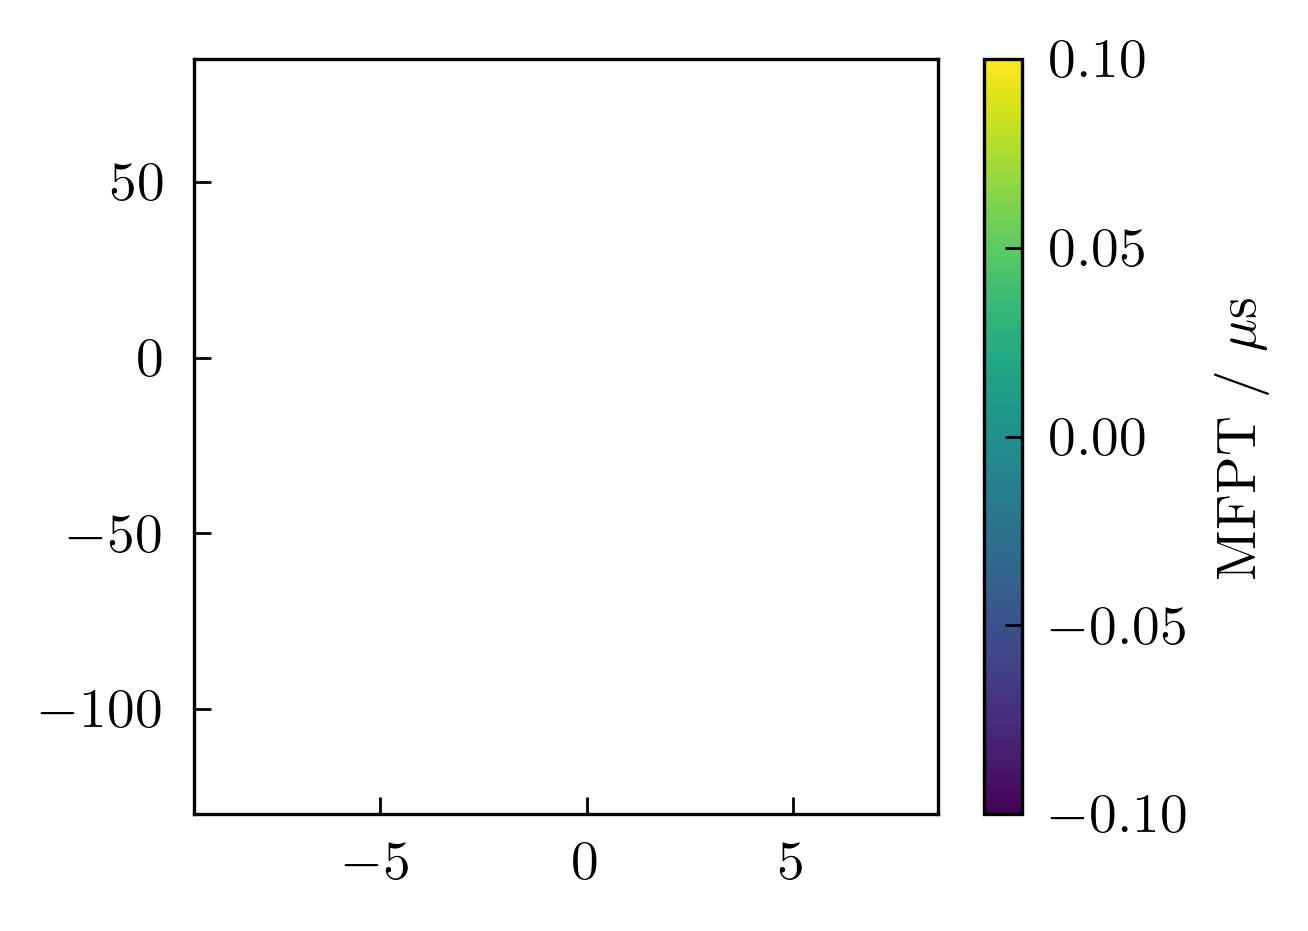

Epoch 108 / 200
Loss:     nan [    0 /  2000]
Loss:     nan [  500 /  2000]


KeyboardInterrupt: 

In [217]:
metrics = {}
metrics["loss"] = []
metrics["params"] = []
state, metrics, basis = train_loop(config_base, metrics, k4, state, dataset, basis, guess)

In [181]:
Phi = state.apply_fn({"params": metrics['params'][-1]['params']}, dataset.dataset, dataset.b_data)
# convert to double precision
Phi = np.array(Phi, dtype=float, copy=True)
Phi_t = Phi[0, ...]
# orthogonalize using QR, but don't normalization
Norm = np.linalg.norm(Phi_t, axis=0)
Q, R = np.linalg.qr(Phi_t)
basis = Phi @ (np.linalg.inv(R) @ np.diag(Norm))

In [207]:
v = metrics['params'][-1]['v'].squeeze()
batch = next(dataset)
xt, xtp, bt, btp, integral = batch.xt, batch.xtp, batch.bt, batch.btp, batch.integral
Phi = state.apply_fn({"params": metrics['params'][-1]['params']}, xt, bt)
def test(v, Phi):
    norm = 2 * v * (jnp.mean(Phi[..., 1:] ** 2, axis=0) - 1) - v**2
    return jnp.sum(norm)

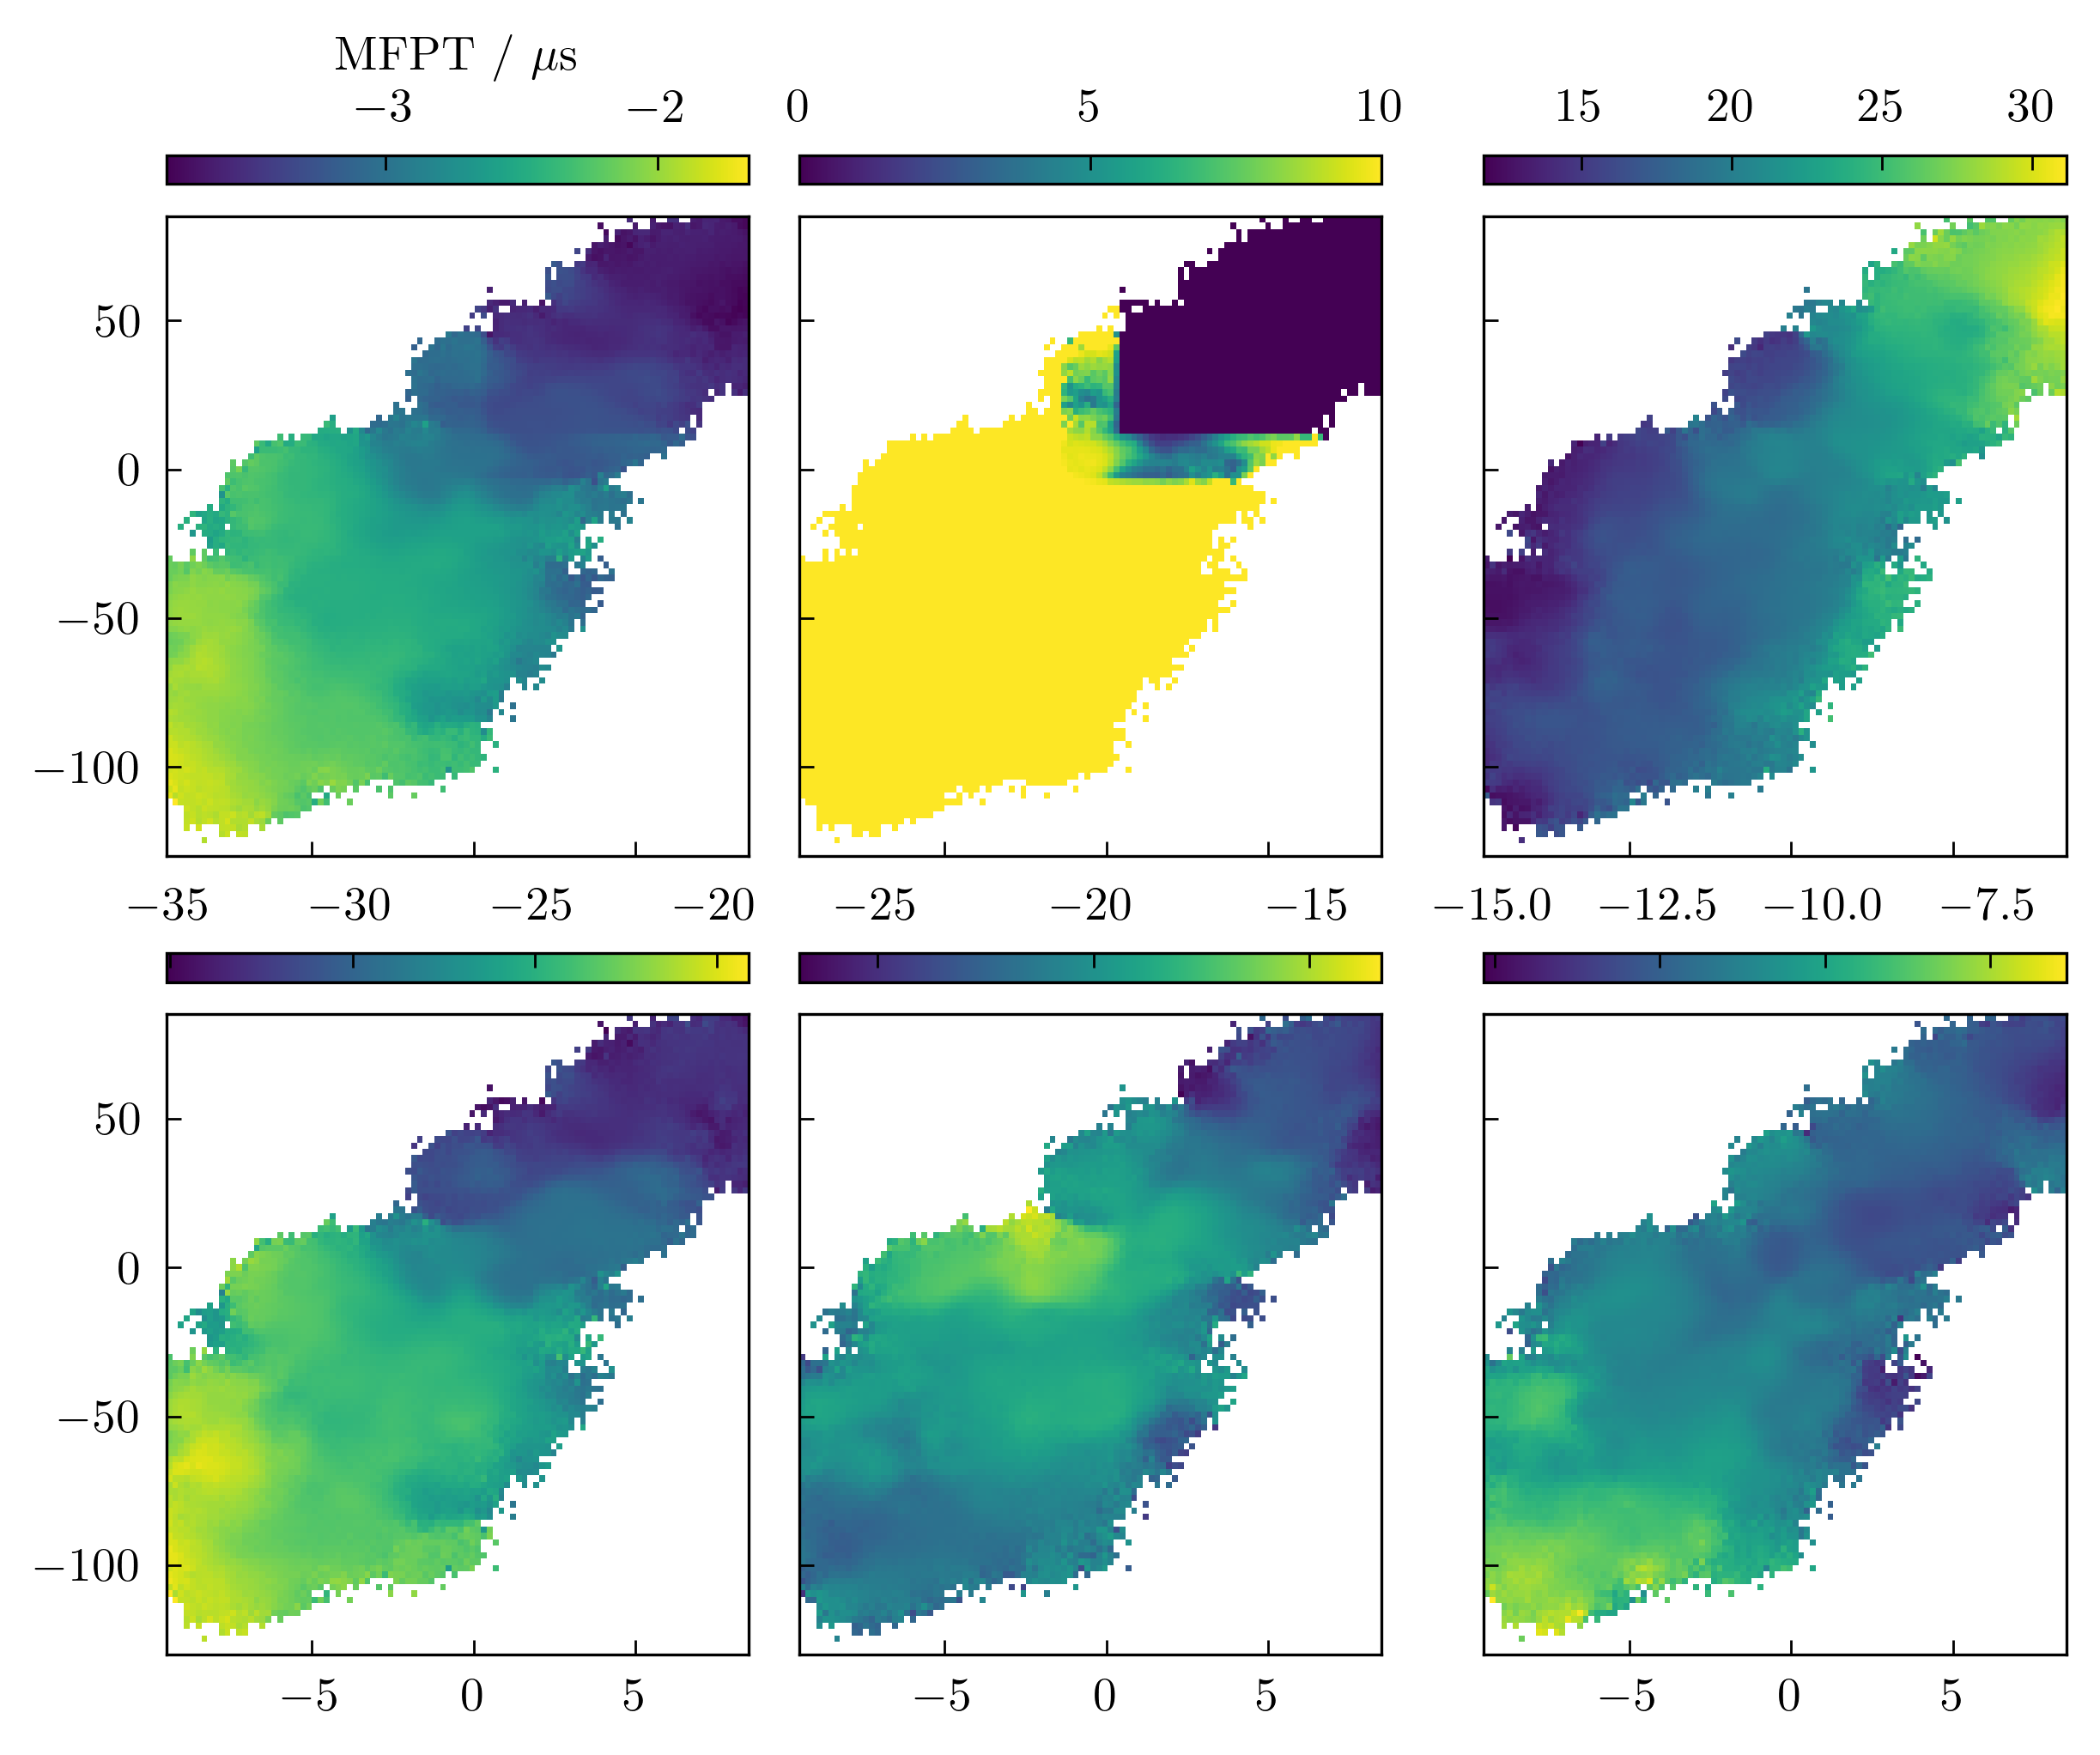

In [218]:
# plot optimized basis functions
f, axs = plt.subplots(2, 3, figsize=(6, 5), sharex=True, sharey=True, dpi=200, constrained_layout=True)
xmin, xmax, ymin, ymax = -9.5, 8.5, -130, 85
xe = np.linspace(xmin, xmax, 101)
ye = np.linspace(ymin, ymax, 101)
xcent = (xe[1:] + xe[:-1]) / 2
ycent = (ye[1:] + ye[:-1]) / 2

cv_dataset = start_dataset(cv_trajs, config_base.lag)
w_dataset = start_dataset(weights[0], config_base.lag)

for i in range(1, 6):
    ax = axs.flat[i]
    basis_bin = extq.projection.average2d([cv_dataset[:, 0]], [cv_dataset[:, 1]], [basis[0, :, i - 1]], [w_dataset], xe, ye)
    pc = ax.pcolormesh(xcent, ycent, basis_bin.T)
    plt.colorbar(pc, ax=ax, location='top')
    
coeffs, mfpt = solve_dga(basis, dataset.integral, guess)
mfpt_bin = extq.projection.average2d([cv_dataset[:, 0]], [cv_dataset[:, 1]], [mfpt[0, :, 0]], [w_dataset], xe, ye)
pc = axs[0, 0].pcolormesh(xcent, ycent, mfpt_bin.T * 0.0001)
plt.colorbar(pc, ax=axs[0, 0], location='top', label="MFPT / $\mu$s")

In [154]:
basis[0].T @ basis[0]

array([[ 9.11397275e+08,  2.42360443e-09,  1.87823446e-09,
         2.36402684e-08, -3.57150896e-08],
       [ 2.42360443e-09,  1.13420700e+05, -1.09760201e-10,
        -5.77323078e-10,  1.19100285e-10],
       [ 1.87823446e-09, -1.09760201e-10,  1.70993031e+05,
        -1.06762599e-10, -1.70299330e-11],
       [ 2.36402684e-08, -5.77323078e-10, -1.06762599e-10,
         1.45430386e+07,  3.72317288e-10],
       [-3.57150896e-08,  1.19100285e-10, -1.70299330e-11,
         3.72317288e-10,  1.80651736e+06]])

In [155]:
np.linalg.norm(basis, axis=1)

array([[30189.35699037,   336.77989835,   413.51303578,  3813.53361593,
         1344.0674679 ],
       [30113.15390992,   335.74504829,   413.42586799,  3805.27529501,
         1338.4091122 ]])